# Advantage Actor-Critic (A2C)


https://arxiv.org/pdf/1506.02438.pdf

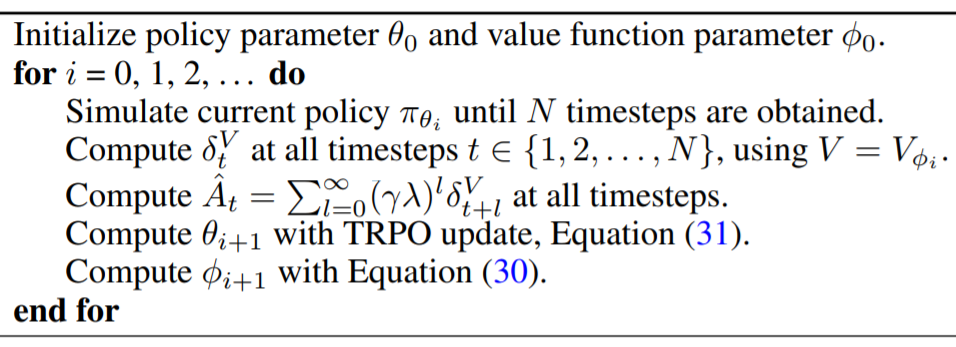

There is no TRPO update here, just advantage and MSE

In [1]:
import numpy as np
import gym
import tensorflow as tf
import scipy
from baselines.common.vec_env.subproc_vec_env import SubprocVecEnv
from baselines.common.vec_env.dummy_vec_env import DummyVecEnv

critic_learning_rate = 1e-4
actor_learning_rate = 1e-4
epochs_number = 50000
batch_size = 128
replay_buffer_size = batch_size
l2_regularization = 0

discount_factor = 0.98
lambda_factor = 0.96

env_name = 'Humanoid-v2'
environments_count = 40

# This code gets action and observation space sizes for 1D tasks
env = gym.make(env_name)
action_space = env.action_space.n if isinstance(env.action_space, gym.spaces.discrete.Discrete) else env.action_space.shape[0]
observation_space = env.observation_space.n if isinstance(env.observation_space, gym.spaces.discrete.Discrete) else env.observation_space.shape[0]


## Create environments vector

In [2]:
def make_env(env_id, seed):
    def _f():
        env = gym.make(env_id)
        env.seed(seed)
        
        # Desync environments
        env.reset()
        for i in range(int(env.spec.max_episode_steps*seed//environments_count)):
            env.step(env.action_space.sample())
        return env
    return _f

envs = [make_env(env_name, seed) for seed in range(environments_count)]
envs = DummyVecEnv(envs)

## Define model architecture

In [3]:
epsilon = 1e-8

def gaussian_loglikelihood(x, mu, log_std):
    pre_sum = -0.5 * (((x - mu) / (tf.exp(log_std) + epsilon))**2 + 2 * log_std + np.log(2 * np.pi))
    return tf.reduce_sum(pre_sum, axis=1)

In [4]:
tf.reset_default_graph()

class ActorNetworkContinuous:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        mu = tf.layers.dense(l3, units=action_space)

        log_std = tf.get_variable(name='log_std', initializer=-0.5 * np.ones(action_space, dtype=np.float32))
        std = tf.exp(log_std)

        self.action_op = mu + tf.random.normal(shape=tf.shape(mu)) * std


        # Training
        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None, action_space], dtype=tf.float32)

        action_logprob = gaussian_loglikelihood(self.action_ph, mu, log_std)

        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = -tf.reduce_mean(action_logprob * self.weight_ph) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=actor_learning_rate).minimize(self.loss)


class ActorNetworkDiscrete:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])
        l1 = tf.layers.dense(self.state_ph, units=20, activation=tf.nn.relu)
        output_linear = tf.layers.dense(l1, units=action_space)

        output = tf.nn.softmax(output_linear)
        self.action_op = tf.squeeze(tf.multinomial(logits=output_linear,num_samples=1), axis=1)
        #action_op = tf.expand_dims(tf.constant(1), axis=0)

        # Training
        output_log = tf.nn.log_softmax(output_linear)

        self.weight_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        self.action_ph = tf.placeholder(shape=[None], dtype=tf.int32)

        action_one_hot = tf.one_hot(self.action_ph, action_space)
        responsible_output_log = tf.reduce_sum(output_log * action_one_hot, axis=1)
        self.loss = -tf.reduce_mean(responsible_output_log * self.weight_ph)

        optimizer = tf.train.AdamOptimizer(learning_rate=actor_learning_rate)
        self.update_op = optimizer.minimize(self.loss)

    
class CriticNetwork:
    def __init__(self):
        self.state_ph = tf.placeholder(tf.float32, shape=[None, observation_space])

        l1 = tf.layers.dense(self.state_ph, units=100, activation=tf.nn.tanh)        
        l2 = tf.layers.dense(l1, units=50, activation=tf.nn.tanh)
        l3 = tf.layers.dense(l2, units=25, activation=tf.nn.tanh)
        output = tf.layers.dense(l3, units=1)
        
        self.value_op = tf.squeeze(output, axis=-1)
        print(self.value_op)

        # Training
        self.value_ph = tf.placeholder(shape=[None], dtype=tf.float32)
        
        all_params = tf.trainable_variables() 
        loss_l2 = tf.add_n([tf.nn.l2_loss(v) for v in all_params])

        self.loss = tf.losses.mean_squared_error(self.value_ph, self.value_op) + loss_l2 * l2_regularization
        self.update_op = tf.train.AdamOptimizer(learning_rate=critic_learning_rate).minimize(self.loss)
    
actor = ActorNetworkContinuous()
critic = CriticNetwork()

W0721 13:40:24.139086 15160 deprecation.py:323] From <ipython-input-4-f1ca94053e9b>:7: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0721 13:40:24.144072 15160 deprecation.py:506] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0721 13:40:24.467296 15160 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Tensor("Squeeze:0", shape=(?,), dtype=float32)


In [5]:
config = tf.ConfigProto(device_count={'GPU': 0})
sess = tf.Session(config=config)

sess.run(tf.local_variables_initializer())
sess.run(tf.global_variables_initializer())

In [6]:
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
np.hstack((a, [[11], [12], [13]]))

array([[ 1,  2,  3, 11],
       [ 4,  5,  6, 12],
       [ 7,  8,  9, 13]])

In [7]:
def f(x):
    x[0] = 6

In [8]:
a = np.array([1, 2, 3])
f(a)
print(a)

[6 2 3]


In [9]:
def discount_cumsum(x, coef):
    """
    magic from rllab for computing discounted cumulative sums of vectors.
    input: 
        vector x, 
        [x0, 
         x1, 
         x2]
    output:
        [x0 + discount * x1 + discount^2 * x2,  
         x1 + discount * x2,
         x2]
    """
    return scipy.signal.lfilter([1], [1, float(-coef)], x[::-1], axis=0)[::-1]

discount_cumsum([1, 2, 4, 8], 0.5)

array([4., 6., 8., 8.])

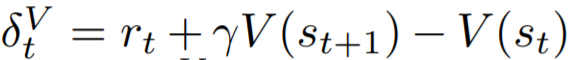

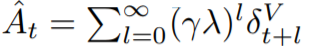

In [10]:
def estimate_advantage(states, rewards):
    values = sess.run(critic.value_op, feed_dict={critic.state_ph: states})
    deltas = rewards - values
    deltas = deltas + discount_factor * np.append(values[1:], np.array([0]))
    
    advantage = discount_cumsum(deltas, coef=lambda_factor * discount_factor)
    
#     gamma_labda_powers = [(discount_factor * lambda_factor) ** l for l in range(len(states))]
#     advantage2 = np.zeros_like(rewards)
#     for t in range(len(values)):
#         for l in range(len(states) - t): # We have finite sum case
#             advantage2[t] += gamma_labda_powers[l] * deltas[t + l]
    return advantage, values

In [11]:
def generate_batch(envs, batch_size, replay_buffer_size):
    envs_number = envs.num_envs
    observations = [[0 for i in range(observation_space)] for i in range(envs_number)]
    
    # [state, action, advantage, discounted reward-to-go]
    replay_buffer = np.empty((0,4), np.float32)
    
    # [state, action, reward] rollout lists for every environment instance
    rollouts = [np.empty((0, 3)) for i in range(envs_number)]

    while True:
        history = {'reward': [], 'max_action': [], 'mean_advantage': [], 'mean_value': []}
        replay_buffer = replay_buffer[batch_size:]
        
        # Main sampling cycle
        while len(replay_buffer) < replay_buffer_size:
            actions = sess.run(actor.action_op, feed_dict={actor.state_ph: observations})
#             actions = [envs.action_space.sample() for i in range(envs_number)]
            observations_old = observations
            observations, rewards, dones, _ = envs.step(actions)
            
            history['max_action'].append(np.abs(actions).max())
            
            time_point = np.array(list(zip(observations_old, actions, rewards)))
            for i in range(envs_number):
                rollouts[i] = np.append(rollouts[i], [time_point[i]], axis=0) # Regular python append
            
            # Process done==True environments
            if dones.all():
                print('WARNING: envs are in sync!!')

            done_indexes = np.arange(envs_number)[dones]
            for i in done_indexes:
                rewards_trajectory = rollouts[i][:, 2].copy()
                history['reward'].append(rewards_trajectory.sum())
                
                # Perform generalized advantage estimation
                advantage, values = estimate_advantage(states=np.array(rollouts[i][:, 0].tolist()),
                                                       rewards=rewards_trajectory)
                history['mean_value'].append(values.mean())
                history['mean_advantage'].append(advantage.mean())

                rollouts[i][:, 2] = advantage

                discounted_reward_to_go = discount_cumsum(rewards_trajectory, coef=discount_factor)

                
                rollout = np.hstack((rollouts[i], np.expand_dims(discounted_reward_to_go, axis=-1)))                
                replay_buffer = np.append(replay_buffer, rollout, axis=0)
                rollouts[i] = np.empty((0, 3))
        
        np.random.shuffle(replay_buffer)
        replay_buffer = replay_buffer[:replay_buffer_size] ### QUESTIONABLE
        yield replay_buffer[:batch_size], history

a = generate_batch(envs, 8, 64)
# Makes them of equal lenght
for i in range(10):
    next(a)
next(a)[0]

array([[array([ 1.21058958e+00,  9.80590834e-01,  9.45097271e-03, -1.77840878e-01,
        8.20055886e-02,  1.95650078e-01,  4.99071046e-01,  9.98746308e-02,
        4.42064019e-02,  2.16059463e-01, -9.68854439e-01, -2.00727123e+00,
        5.04882435e-02, -7.70389904e-02, -5.20546959e-01, -8.32434508e-01,
        7.85727041e-01, -8.37374390e-01, -1.78551870e-01, -2.28756262e-01,
       -1.56116273e-01, -1.03579755e+00, -4.48992587e-01, -1.62908105e-01,
       -7.13773144e-01, -8.51554376e-01, -7.43167035e-01,  5.62843095e+00,
       -3.87529388e+00, -5.23974924e+00,  9.28808782e+00, -6.81284033e+00,
       -5.19431017e+00,  3.88540216e+00, -1.03064626e+01,  7.12838548e+00,
        5.09061419e+00,  8.55149923e+00,  2.15447901e+00,  5.20929789e+00,
       -4.47283096e+00, -3.77808170e+00, -4.11855815e+00, -8.21183891e+00,
       -1.33978032e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.0000000

## Train agent 

In [ ]:
history = {'reward': [], 'actor_loss': [], 'critic_loss': [], 
           'max_action': [], 'mean_value': [], 'mean_advantage': []}

In [38]:
from tqdm import tqdm_notebook

batch_generator = generate_batch(envs,
                                 batch_size=batch_size,
                                 replay_buffer_size=replay_buffer_size)

# Makes them of equal lenght
print('Charging generators')
for i in range(20):
    next(batch_generator)

saver = tf.train.Saver()
max_value = 1535

for epoch in tqdm_notebook(range(epochs_number)):
    batch, batch_history = next(batch_generator)
    history['reward'] += batch_history['reward']
    history['max_action'] += batch_history['max_action']
    history['mean_advantage'] += batch_history['mean_advantage']
    history['mean_value'] += batch_history['mean_value']


    value = int(np.mean(history["reward"][-10:]))
    if max_value < value:
        save_path = saver.save(sess, f'./models/{env_name}-reward-{value}.ckpt')
        print("Model saved in path: %s" % save_path)
        max_value = value

    _, actor_loss = sess.run([actor.update_op, actor.loss], feed_dict={
                                                actor.state_ph: np.array(batch[:, 0].tolist()),
                                                actor.action_ph: np.array(batch[:, 1].tolist()),
                                                actor.weight_ph: batch[:, 2]})

    _, critic_loss = sess.run([critic.update_op, critic.loss], feed_dict={
                                                critic.state_ph: np.array(batch[:, 0].tolist()),
                                                critic.value_ph: batch[:, 3]})
    
#     history['gradients_max_abs'].append(np.max([np.max(np.abs(var_grad)) for var_grad in gradients_]))
#     history['gradients_equal_zero'].append(np.sum([np.sum(var_grad == 0) for var_grad in gradients_]))    
    history['critic_loss'].append(critic_loss)
    history['actor_loss'].append(actor_loss)



Charging generators


Model saved in path: ./models/Humanoid-v2-reward-1549.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1561.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1572.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1751.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1775.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1802.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1818.ckpt
Model saved in path: ./models/Humanoid-v2-reward-1860.ckpt


KeyboardInterrupt: 

Learning rate - очень чувствительный 1e-3 - не учится (взрывается до +беск), 1e-4 не сходится, 3e-4 ОК



Похоже, что policy gradient должен иметь как можно более быстрый отклик от среды, иначе мы штрафуем его за действия из другого распределения

Кажется, теперь понятно зачем нужны trust region'ы - без них что-то происходит и policy умирает


## Plot results

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

# Moving average
def smoothen_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot(array, title='', axis=plt):
    axis.title.set_text(title)
    axis.plot(np.arange(len(array)), smoothen_curve(array))    

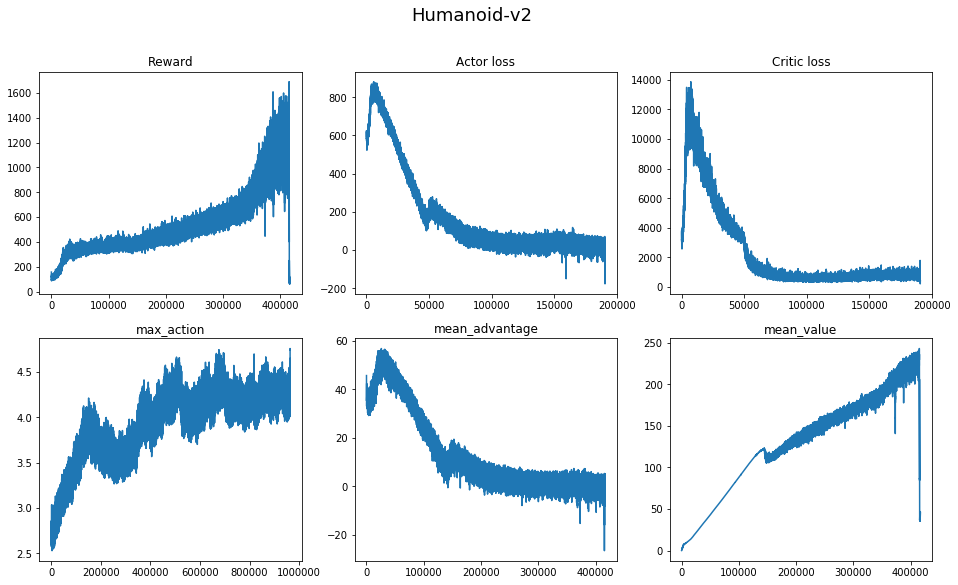

In [46]:
fig, axs = plt.subplots(2, 3, figsize=(16, 9))
plot(history['reward'], 'Reward', axs[0, 0])
plot(history['actor_loss'], 'Actor loss', axs[0, 1])
plot(history['critic_loss'], 'Critic loss', axs[0, 2])

# plot(history['gradients_max_abs'], 'Gradients max (not from adam)', axs[1, 0])


# parameters_number = np.sum([np.ones_like(g).sum() for g in gradients_])
# plot(history['gradients_equal_zero'], f'Gradients equal zero out of {int(parameters_number)} parameters', axs[1, 1])

plot(history['max_action'], 'max_action', axs[1, 0])
plot(history['mean_advantage'], 'mean_advantage', axs[1, 1])
plot(history['mean_value'], 'mean_value', axs[1, 2])

plt.suptitle(env_name, fontsize=18)

# plt.savefig(f'logs/{env_name}')

## Our agent

In [8]:
observations = env.reset()

for i in range(10000):
    env.render()
    actions = sess.run(actor.action_op, feed_dict={actor.state_ph: [observations]})
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[0])

    print('h', rewards, actions[0])


    if dones:
        observations = env.reset()
        print('Done')


Creating window glfw
h 4.770948991732646 [-0.02457428 -1.1527355   3.6043484  -1.0810443   1.9071137   2.7343674
  0.99569076  1.8097403  -1.8908571   2.96734     1.0609782  -1.693946
 -0.272906    0.154449   -1.1975011  -0.14734471  0.6055958 ]
h 4.733147231998747 [ 0.80992585 -0.86472785  2.973815   -1.1003913   1.6317549   2.4580734
  1.817554    2.9986405  -1.8051763   2.3019478   2.2301295  -0.9453156
 -0.85533667  1.5775808  -1.33964    -0.9258802  -0.14628848]
h 4.756173425841324 [ 1.3272336  -1.1394484   3.9018438  -1.5883442   1.2734807   2.8061366
  2.5480232   1.7755309  -2.5511713   2.2414575   1.6693242  -1.4062675
 -0.20751226 -0.95241004 -0.2538538  -1.0364662   0.01483637]
h 4.754128662494742 [ 0.83785063 -0.15559834  2.9598787  -0.86266005  2.4306014   1.6961095
  2.2388606   2.4006531  -1.8585744   0.57938445  1.224942   -1.210571
 -1.2148867  -0.10287453 -1.8282815  -0.73653364  0.30939966]
h 4.719050606522972 [ 1.0500578  -0.91530067  2.5828454  -0.59494543  2.14348

h 5.839223359942886 [-1.8393383  -1.9377692   0.5744106   1.6289586  -1.5086085  -1.096823
  1.1622243  -1.4074808   0.4520346  -1.760084   -2.308433    0.64483184
  0.29404297  0.5514793   1.64317    -0.19470343  2.1056914 ]
h 5.844847137967226 [ 2.0364416  -0.21965629  2.5392988  -1.2996968   0.5115348   2.4155889
  2.7700288   1.3610502  -1.1813687   1.295697   -2.2515516  -0.00984192
  1.5450069   0.9577731   1.4557937  -0.96787125  2.0465605 ]
h 5.91700393255751 [ 1.3638632  -1.8995538   3.5619192  -1.8854237   1.8447385   2.752932
  1.32025     2.633484   -2.930664    2.5645697   2.016713   -1.5064114
  0.21336347  1.3282375  -0.48348248 -1.1719688  -0.18302393]
h 6.082068512530353 [ 0.451507    0.11852139  3.04709    -1.0727125   1.7784934   2.3872297
  0.9882107   1.8169565  -2.128976    2.420322    1.9528441  -0.6878564
  0.05139256  0.63211554 -0.5137167  -1.020569   -0.5199815 ]
h 6.176260021566985 [ 0.23864353  0.45057523  2.4200385  -0.2939655   1.1136637   1.5157661
  1.5

h 6.460442252682341 [ 1.3254321  -0.96002567  1.5574871  -2.0626864   0.61838585  2.4781284
  2.2648711   1.185409   -0.43364453  0.44868332 -2.1010287   1.6208549
 -0.28060776  0.9324344  -0.02204219 -0.3048891   0.2587266 ]
h 6.4328832803296585 [ 0.20122111 -1.3487498   2.7298307  -1.5428152   1.4313561   3.2368193
  2.0646007   2.7786531  -2.639979    1.6378545   1.8127973  -1.7018883
 -1.3119817   0.44600552 -0.479896   -0.6274624  -0.67221314]
h 6.455955062549137 [ 1.18109    -0.04316008  1.8269405  -0.8234596   2.0562425   2.425777
  1.4098805   3.1410036  -2.1062906   1.2508767   3.3120203  -0.9158434
  0.94012564  0.01430029 -1.5677608  -0.3603715   0.70650774]
h 6.44953117275092 [ 0.89906716 -0.09025152  0.98641026 -0.15627347  1.1138929   2.257094
  2.2100415   2.6936998  -1.0646348   2.9527721   2.461874   -0.61421025
  0.49641013  1.3864402  -1.3899623  -1.714473    0.4452064 ]
h 6.4361071467417545 [ 0.58949006  0.5870017   2.3456562   1.3149188   0.58922994  1.9414939
  2.

h 6.219715541692824 [-1.7685903  -1.4034241   0.54829615  0.97815686 -0.64284605 -1.3368235
  1.1049111  -0.9742023   0.52552676 -2.3833613  -2.296845    1.1051025
  0.17390993  0.13456881  1.3426405  -0.09036528  1.6777816 ]
h 6.375407884645535 [ 0.9681277  -0.02979791  2.460607   -1.4433334   0.7209461   1.8678219
  1.4476167   1.245352   -0.17798775  0.95168847 -2.3858597  -0.125916
 -0.27171     1.4614165   0.9002565  -0.67870903  1.7515684 ]
h 6.467404459472465 [ 0.26229006 -0.64042854  2.969033   -2.2300458   1.8223326   2.5661957
  3.027044    2.4583454  -1.6397977   2.836756    2.9299843  -1.6112105
 -0.42331952  1.0892409  -1.5321254  -0.15139705  0.46352145]
h 6.498610784222318 [ 1.2101421  -0.29001054  3.073488   -1.9496212   1.6662228   2.3889194
  1.7148579   1.9566536  -2.3010564   2.6407309   2.107701   -2.2289672
 -0.18486926 -0.09141399 -1.5389905  -1.6250179  -0.06047197]
h 6.446511480284235 [ 1.3946704  -0.77126294  1.9312015  -0.87877864  2.9770942   2.2754362
  1.5

h 5.942109648848924 [-1.7319934   0.7144576  -0.73167866  2.702907    1.4800577   0.22686274
  0.6736171   0.16645704 -1.4385669  -0.85147053  2.8813918  -1.7516264
 -1.5774863  -0.6432462  -0.81126964  0.03819644 -1.2230008 ]
h 5.919334653374182 [-1.4313891   1.8572595  -2.533124    2.0035784   0.86470145 -1.6431632
  2.3721538  -2.4417315  -1.1110932  -2.6753097   2.7691455  -2.110637
 -0.7178496  -0.36532992 -1.1884016  -0.75475144 -0.12680364]
h 5.940183482903851 [-1.463359   -0.02933013 -1.8849258   2.7021322  -0.07123989 -1.9984185
  3.3830202  -2.321035    0.7176819  -3.1815395   0.6715852   0.3192459
  1.0155085  -0.8069368   0.444444    0.39532024 -1.5260026 ]
h 5.904664757599227 [-0.80782586  0.5546349  -1.1924176   2.8314593  -1.5058317  -1.1170084
  2.1135817  -1.9345883   0.66368806 -4.0886602  -2.2091405   0.34708896
  1.6496253  -0.5937072   1.5087923   0.45326942 -1.3113611 ]
h 5.967051244652751 [-1.0411683  -0.20636362  0.4960792   1.9174497  -0.00684723 -0.24087846
  

h 6.9186177027564 [-1.3253411   0.09915686 -2.110042    2.5270865  -0.44993877 -2.406163
  1.8239287  -2.462028    1.3356694  -2.7139616  -1.1297299   1.2546271
  0.33588576 -0.72152144  0.07187414  1.1783359  -1.093684  ]
h 6.953190388114984 [-1.268154    0.26134634  0.08243493  2.6352773  -0.0065781  -1.781046
  2.2077272  -0.6237839  -0.16654073 -1.3893641  -1.5771697   1.2947252
 -0.07413189  0.83259094  1.9821993   0.50541645 -0.56281227]
h 6.943512347697444 [-1.1137755  -0.821664    0.8403542   1.5737109   0.00656182 -0.25920144
  2.4719896   0.65863216 -0.6731344  -1.2324077  -2.0075386   0.2800869
 -0.49201655  0.19554788  1.0360664  -0.12134099  1.1928651 ]
h 6.905217409794259 [ 0.47137135 -0.65026265  1.6436249  -0.9219874   0.7169588   2.7184658
  2.4870958   1.6529715  -1.4690286   0.52933115 -1.549941    0.30486292
 -1.0231135   0.88864785  0.5922487   0.02170277  1.8811166 ]
Done
h 4.771244307133555 [ 0.9322617  -0.7543466   2.5487113  -1.1339374   0.61763257  2.8571706
 

h 6.762079287543214 [-0.94002116  1.2055069  -1.6124257   2.5835295  -0.3032132   0.9334607
  3.941168   -2.0618923  -1.3195307  -3.253492   -0.4637866   0.15902907
 -0.34570807 -1.688933    0.74972826 -0.19879228 -0.8159403 ]
h 6.789675180674014 [ 0.4222955   0.20517132  1.545369   -1.4768424   1.7487189   2.503137
  0.17272627  1.6885378  -0.17440766  1.0980831  -1.6386833  -0.14021677
  1.099412   -1.1048946  -0.55077934 -0.22890957  2.0188315 ]
h 6.7350081845772785 [ 0.4306848  -1.5903662   3.4032586  -2.229186    0.26399648  2.465585
  0.89649165  2.6025553  -1.865993    1.8804977   2.8028653  -1.072093
 -1.8816502   1.2300093  -0.51974404 -1.6023359   0.500125  ]
h 6.7087834945450275 [ 1.658582    0.06522265  2.8220959  -0.8063541   2.4056115   2.0322924
  1.1282254   1.6095613  -1.491931    2.211979    2.688313   -0.6061678
 -0.07678485  0.8871531  -2.2512221  -0.35522643  0.44460326]
h 6.576615217661153 [ 0.16887027  1.4348491   2.7811558   0.53700554  1.6058555   1.6840055
  0

h 6.956442271471269 [ 1.2159634   0.49264207  2.004164   -1.6686574   1.1851335   1.8362211
  1.2730811   1.8751465  -1.8357326   1.5262066   2.8017507  -2.1745532
 -0.64190304 -0.50672394 -1.8216566  -0.46052414 -0.82362163]
h 6.961820685205531 [-0.54477     1.002489    1.0229524   2.261625    1.534102    1.9238032
  1.6579418   2.5178404  -2.5140398   0.474732    1.9989495  -1.5638553
 -0.31692743 -0.6943607  -1.9847177  -1.7993069  -0.96059304]
h 7.000638530572781 [-0.53382444  1.5284564   0.18615712  2.0498698   2.3273206   0.7914386
  3.231183    1.2724361  -3.8144898  -0.19313407  2.3979132  -1.8907211
 -0.34866318  0.03536735 -1.2867328  -0.5124916  -1.3180196 ]
h 6.968169711150423 [-0.94772595  1.9168627  -1.305282    2.2209597   2.4204094  -0.34601742
  1.5641198  -1.6803477  -2.0755506  -0.77933455  2.3026214  -1.9783804
  0.94480884 -1.4301813  -1.0348828  -0.6957515   0.2784468 ]
h 7.143798176693115 [-0.7572211   1.1448278  -0.8677111   1.7009075  -0.01615354  0.8979827
  3

h 6.079522385659161 [ 1.078412   -1.2507738   2.506957   -0.25902426 -0.49076343  2.9773831
  0.21108603  2.3375566  -2.5458448   2.7099695   1.6919482  -1.3269261
 -1.8272167  -0.30669284 -1.8729115  -1.1505942   1.9906924 ]
h 6.088747140704037 [ 1.069955   -0.1993089   3.3742807  -2.6166687   1.8978956   2.3558283
  0.57648104  2.6957035  -1.2151778   2.8542573   1.9273446  -1.8304675
 -0.7465717   0.3109825  -1.0330487  -0.29612947  0.22040007]
h 6.103343840717481 [ 0.08206624 -0.7176373   1.6519529  -0.27906173  2.4999292   2.0335054
  1.8108323   1.3114946  -1.0231191   2.4244106   2.165365   -2.1732614
 -0.14435604  0.13025486 -1.7779542  -0.8014726   0.53332317]
h 6.067133321738299 [ 0.06145346  0.9088148   1.3850534   0.627423    1.4117309   2.5600042
  1.2305741   2.389624   -1.8168589   2.3222861   1.553657   -1.5170507
  0.9731915  -0.46347943 -1.4250108  -0.8698591   0.9065418 ]
h 6.086142314497083 [ 0.26998448  1.560915   -0.77431345  1.9264536   2.228554    0.9962268
  1.

h 6.51674621758902 [-0.7588924  -0.8834091   0.3525628   0.95707655  1.2789872   1.2631162
  2.1312623  -0.85453916 -0.49026376 -0.93825734 -1.6913886   1.2628914
  0.11219976  0.84888035  0.94855046 -0.8324536   1.1868203 ]
h 6.497890256264191 [ 1.7485561  -1.1328616   2.2294953  -0.55000734  1.7820946   2.5828385
  1.4840134   3.2563698  -2.022331    3.5112386  -1.1924615   0.45148423
  0.4594828  -0.65576965 -1.0839561  -2.2512274   2.1725192 ]
h 6.542921159811369 [ 0.5811082  -1.28201     2.924776   -0.20480227  2.505024    2.76566
  1.3351929   2.737778   -2.5289865   2.2023203   2.4025693  -1.389252
 -0.55843216  1.0526125   0.03811979 -0.31642073 -0.22934273]
h 6.532423626832779 [ 1.3822317e-03 -4.6027830e-01  2.6389647e+00 -1.1213424e+00
  3.3784647e+00  1.9120024e+00  2.5189133e+00  3.0211918e+00
 -2.4678824e+00  2.0489120e+00  2.1895263e+00 -1.4431278e+00
 -3.8584071e-01  9.4448149e-01 -1.4513371e+00 -1.0726789e+00
  5.6901479e-01]
h 6.563878235806301 [ 0.17825699  0.08235066

h 6.830155082936838 [-1.1999736   1.5426662  -1.6442022   1.7809709   1.4811709  -0.6217374
  1.0930476  -1.4487151  -2.338228   -1.4567478   3.035131   -1.3585209
 -0.07668388 -1.426833   -1.8745638  -0.5976592  -0.5932624 ]
h 6.894549387947187 [-1.3057008   1.0340934  -2.0646696   2.8794777  -0.52325755 -1.3573372
  3.3115404  -2.6451995   0.28588575 -3.1689754  -0.07162338 -0.2766322
  1.0381311  -0.43493757 -1.0070283   0.84386146 -1.5535827 ]
h 6.9805504057157 [-1.5575128   0.42856753  0.5439461   1.4867376  -1.2539146  -0.6390524
  2.0503106  -1.6136706  -0.36813885 -2.2380736  -2.0454774   2.5073154
  0.886698    1.0766096   1.567023   -0.82006687  0.5762783 ]
h 7.059445568904749 [ 0.25738907 -0.46131793  2.7119155  -1.5425491   0.46939147  1.688118
  2.1391485   1.6748624  -0.44549954  0.9731129  -2.2972667   0.52479565
 -0.5420015   0.6182787   0.44122687 -1.110909    2.0818088 ]
h 7.0735228272053305 [ 0.45764884 -0.5213304   3.2556167  -2.14292     0.97069967  2.1708174
  1.5

h 7.330079428744714 [-0.11915405  1.8486603   0.25880685  3.3442059   1.2844908   1.324832
  1.894831    0.78762627 -3.100048   -0.94723415  0.8802928  -1.563843
 -0.46066934 -0.57627475 -0.7869824  -1.2722164  -0.8129584 ]
h 7.327596236446729 [-0.9634787   1.0490977  -1.7183886   2.2892673   1.8135041  -1.1334758
  2.4017415  -1.0216224  -0.89708483 -1.7187636   3.2781212  -0.9116365
  0.21403733 -0.90782046 -1.4485984  -0.86616135 -0.23935121]
h 7.332452632129963 [-0.43219024  1.4906299  -1.7585012   1.5237278  -0.83230156  0.45794162
  3.3431604  -1.4364797  -0.42150563 -2.8423347  -1.2615447  -0.45692357
 -0.84312487 -0.6403577  -0.18326968  0.6256683  -0.18683425]
h 7.3340511106542 [-0.9449009  -0.30045992  3.845346   -2.9469945   0.5394565   1.9857558
  1.4016185   1.9329551  -0.3588292   3.175787   -1.9210595  -0.20533094
  0.7238523  -0.24885558 -1.7489797   1.2477971   1.8426148 ]
h 7.3300883562156525 [ 0.6761079  -1.1224881   2.670384   -2.359664    1.907079    2.6964056
  1.

h 4.754378113145519 [ 0.7464565  -1.0908816   2.656792   -1.3281611   1.56347     2.2981412
  1.5478354   2.2808309  -2.4725149   2.898435    1.827462   -0.81483364
  0.4352253   0.10559243 -1.542477   -1.250147    0.2634831 ]
h 4.793109168042488 [ 1.078681   -0.73063844  2.54527    -1.2882541   1.3162844   2.6325145
  2.4247534   2.3182602  -2.6899834   1.99129     2.2449787  -1.3417437
  0.16675973 -0.2914405  -1.4563092  -0.7210405   0.5748415 ]
h 5.041814571868194 [ 1.6794765  -1.0352643   3.2293153  -1.8653343   2.6027007   2.5004442
  1.685881    2.4568212  -1.7102385   2.1692176   2.656423   -1.1564986
  1.0162361   0.31567997 -1.4131477  -0.8887315   0.5316634 ]
h 5.197329453086645 [ 0.9329017  -0.8737152   2.360907   -1.8150561   0.44272387  2.4355156
  0.9795994   2.448556   -2.8107903   1.417418    2.3377595  -0.48341322
  0.21429458 -1.5205815  -1.1258355  -1.1473024   0.27143914]
h 5.235159942006949 [-0.10307968 -0.8126795   2.9643786  -0.65622216  1.1539676   2.3451717
  

h 6.492653215423579 [-2.0316467   0.88789    -3.1062279   2.989585    1.7463498  -1.4139593
  1.6178155  -1.1058273  -0.8231679  -1.6719434   1.5626352  -1.0138738
  0.12529898 -1.6934897  -1.9926941  -0.91537476 -0.5856143 ]
h 6.478311326991679 [-1.4835339   1.0452707  -2.7321508   3.2628996  -0.7686368  -1.2379707
  2.8343017  -2.0768263   1.6607322  -3.8306346   0.8588419   0.8948209
  1.1523654  -1.3526194  -0.86851877  0.8373437  -1.527469  ]
h 6.512568780941146 [-1.0132859   0.4609462  -2.1168394   2.5171897   0.05838472 -2.3128498
  1.5687766  -1.2968423   2.6011496  -2.7789044  -0.65265816  0.48772287
  1.2969477  -1.7908099   0.87625915  0.92535293 -1.2549446 ]
h 6.574847503368718 [-2.3555598  -1.1563673  -0.2382172   1.8214815  -0.71243024 -0.9556722
  1.2324557   0.06719792  1.7542088  -0.8488821  -1.20398    -0.29633683
  1.8567      0.3520428   1.6831931   0.38108265  0.8501872 ]
h 6.564410364059251 [ 0.16437441 -1.2616221   0.7070743  -1.0880173   0.7107112   0.8638442
  

h 4.748883792084086 [ 0.57606596 -0.4344113   3.372587   -1.6532371   1.4133462   3.1482508
  1.8656849   1.1436217  -2.8943777   2.284976    0.681775   -0.31536853
 -0.8580079  -0.08085388 -1.3228232  -1.017518    1.4145705 ]
h 4.774664091000051 [ 0.4728387  -0.94990003  3.0401094  -1.2893082   1.4046893   1.8220705
  1.0981979   1.8317575  -2.5862668   2.074873    2.026506   -1.7960669
  0.019099    0.03324522 -1.9068054  -0.5171409   0.0995383 ]
h 4.743500651194104 [ 1.8967807  -0.85594493  3.365125   -1.9700389   1.0848405   2.9034064
  1.6545339   3.322531   -2.4464886   2.629879    1.3836911  -1.0227647
 -0.7038998   0.5316529   0.00570416 -1.4681838   0.79502714]
h 4.743151787635049 [ 0.70784396  0.07664329  3.3360837  -1.310142    1.8535444   2.750604
  1.4687359   2.0789502  -1.5973889   1.9684627   1.5946265  -0.887668
 -0.80751073 -0.8753432  -2.0373452  -1.393928   -0.45015934]
h 4.739431322527942 [ 0.68065286 -0.6677474   2.1315846  -0.37585616  2.2714303   2.100179
  1.78

h 6.390040466668575 [ 3.6133510e-01 -5.9012109e-01  3.0366676e+00 -1.8534576e+00
  1.2926197e+00  2.4569948e+00  1.5545151e+00  2.2270989e+00
 -2.4785781e+00  1.7243066e+00  2.2079830e+00 -1.4632490e+00
  2.7078390e-03  5.9457266e-01 -2.0112634e+00 -1.5777003e+00
  1.0181171e-01]
h 6.439098240334431 [ 1.0636756  -1.5307806   2.7582097  -1.5330681   0.7181762   2.055034
  1.7730801   2.6651804  -2.6385252   1.5265408   1.7795504   0.10266244
  0.8052473   0.3584946  -1.1085025   0.64022565  1.1205432 ]
h 6.472487685595085 [ 0.61675847 -0.02809714  2.2823741  -0.77600527  1.575539    1.4617012
  1.1212174   2.5886357  -2.44387     1.5906825   2.6138928  -1.2656947
 -0.38262147 -0.13409705 -1.5565335   0.42084497 -0.11557508]
h 6.439756142032982 [ 0.48963284 -0.17888224  1.0336008   1.6029023   1.1534796   1.9505159
  0.9022363   2.304375   -1.8891276   1.3688757   2.1413817  -0.4555366
  0.5864357  -0.9709282  -1.0574822  -1.2683266  -0.5867271 ]
h 6.425802929179949 [-0.48393068  0.55861

h 7.243312671145645 [-1.8537768   1.4068943  -1.1718743   2.1650553   1.2892911   0.31062317
  1.3604681   1.6499293  -1.72032    -2.0161586   2.786353   -0.8674851
  0.2056441  -1.0068735  -0.8883405  -0.7023159  -0.10010016]
h 7.209169534717461 [-0.5865726  2.3070793 -1.6257186  3.0206187  2.2340198 -1.1327251
  1.6284891 -1.9754186 -2.3043907 -1.8022375  3.3114855 -1.3326619
  1.0919378 -0.7847563 -1.9388711 -0.8935534 -1.581105 ]
h 7.162673736631152 [-1.5000876   1.8760642  -3.341516    2.8195624  -0.49608204 -1.7525024
  2.1835954  -1.5205536   1.2504294  -3.8096802   2.5032206  -0.14764246
  0.827931   -0.7824339   1.1187587   0.37247717 -0.518327  ]
h 7.019955999554471 [-1.2881193   1.1343036  -2.8877578   2.5220778  -1.1011497  -2.5046017
  1.1564772  -1.6640815   2.4716198  -3.0192242  -1.5916139   0.6469209
  0.4575777  -1.5560542   0.6422008   0.22854167 -0.8579198 ]
h 7.0777409167357925 [-1.4804108  -1.0136971  -0.30638283  1.8196714  -0.6121248  -0.9163251
  1.4488381  -1.

h 5.28259182883566 [ 0.58026576  0.76600677  0.8531241  -0.39004916  2.1478505   1.7337706
  1.6431104   0.7408372  -2.6315753   0.4953598   2.8965025  -0.7445557
 -0.37785673  0.5091231  -2.3357067  -0.9795464  -0.5063761 ]
h 5.321153794023882 [-0.2221581   0.683794    0.5861553   0.31392998  2.1073427   2.375458
  1.4801155   1.0346795  -1.710175   -0.02793106  1.7260633  -2.0807767
 -0.5404888   0.0512436  -1.1745327  -2.2833843  -1.179515  ]
h 5.299264599355455 [-1.1265087   1.7413479  -1.5908755   1.2227354   1.417681    0.04617468
  1.3851416  -0.19548151 -2.1849322  -1.9636687   2.7973156  -0.721475
  0.7075623  -1.4156939  -1.2038026  -0.36630577 -0.45082974]
h 5.407773994783996 [-1.2593677   0.864098   -1.6594186   2.28565     2.0602975  -0.54313385
  2.022616   -1.084354   -1.4041495  -2.7664552   2.4682195  -0.9982491
  0.6746951  -0.5971713  -1.0842556  -1.1594915  -0.97409904]
h 5.672624854429329 [-1.5957592   0.56699926 -2.4251134   3.9606156  -0.02942497 -1.0702604
  2.0

h 6.866910474956597 [-0.60576266  0.5332754   1.5831091   0.9666804   2.1171403   1.5265306
  1.2951037   0.93933576 -2.8231354   0.12181538  2.9632583  -1.822068
  0.38677073 -0.9078433  -1.6025294  -1.4511534  -1.5691948 ]
h 6.8508331973796786 [-0.3853622   1.3139985  -0.63648945  2.6951451   0.98231626  1.4073727
  1.3958484  -0.5069171  -2.0174894  -1.5818383   1.8682878  -1.2106895
  0.9341909   0.87844014 -0.9514962  -2.0378675  -0.56875145]
h 6.865877254927542 [-1.088748    0.29879785 -3.047453    2.4027066   0.53468573 -1.4381187
  2.277229   -2.3676276  -1.9635063  -1.5927105   2.876904   -2.4447412
 -0.2765231  -1.077656   -2.1525512  -1.1667652  -1.1738474 ]
h 6.879474988856803 [-2.3733084   1.1138538  -2.715201    2.9053063   0.02359822 -2.1797166
  1.997771   -2.9865415   1.173665   -3.442747    0.89982843  1.1082736
 -0.16370428 -0.17581922  0.31076288  0.54320246 -1.8818631 ]
h 6.93342946211204 [-0.37450153  0.590195   -1.796196    2.4946456  -0.77486867 -2.0188396
  1.2

h 7.183965241997496 [-1.9258577   1.7578611  -1.6779357   2.240155   -0.0608148   0.9145657
  4.150906   -0.6218641  -1.1214302  -2.611457   -1.3601801   0.16426551
 -0.8680968  -1.1116953   0.6488917   0.9002688   0.18383646]
h 7.235157823199839 [ 0.36159182  0.22790933  3.7905645  -2.749637    2.3450334   1.9179869
  1.4719602   1.7238362  -0.61603343  2.3309853  -1.4911458  -1.1049265
 -0.36225653  0.7241959  -1.3914607   0.6401955   2.35464   ]
h 7.206496024143702 [ 0.94214594 -1.1375976   3.1318514  -1.703085    2.4939492   2.4682426
  1.4971457   1.9455636  -2.363506    1.3493295   1.8877276  -1.4823835
 -0.76358634  0.5969609  -0.7173187  -1.2765101   1.0838195 ]
h 7.236865700642217 [ 0.52417946  0.6835557   1.7840341   0.70173985  1.6629541   1.6066054
  1.5042839   1.9342422  -1.5971959   1.1699321   2.8751495   0.01023567
 -0.35626197  0.18182236 -1.6113687  -1.6726589   1.0781037 ]
h 7.216408352044054 [ 0.06948987  2.015259    0.80824286  1.9223602   2.5883665   1.6558887
  

h 5.217180782540845 [ 9.1763508e-01  1.1029103e+00  4.2960829e-01  1.6695267e-01
  3.8636405e+00  5.5688417e-01  2.2095258e+00  2.0893061e+00
 -2.4402566e+00 -3.6012232e-03  2.3873158e+00 -1.2992523e+00
 -8.9257336e-01  9.8252684e-02 -8.0695224e-01 -1.0838069e+00
 -1.8695399e-01]
h 5.164460548733203 [-0.7950591   2.106182   -0.61589736  1.9866606   2.6046095   0.7463938
  1.7954588  -0.5406986  -3.2766805  -1.280673    3.3877022  -1.4386315
 -0.5550693  -0.9383346  -0.8175473  -1.4370292  -0.5674983 ]
h 5.12769097479091 [-0.60208404  1.0482515  -1.1289849   2.3889549   1.9518418  -1.5531884
  2.1765077  -1.7626203  -0.83137256 -1.8226855   1.6490486  -2.4624197
  0.5064192  -1.7974494  -1.5018108  -1.4092243  -1.6288619 ]
h 5.236269573402346 [-0.8560542   1.6240985  -3.9535227   1.9763703   0.01799172 -1.3552657
  2.225294   -3.3376482   0.75158924 -3.3725085  -0.637548    0.66901654
 -0.43149716 -1.5439227   0.7735616   1.1391929  -1.6660818 ]
h 5.4879602948732344 [ 0.7335261  -1.3988

h 5.795188362610845 [-0.28682172  1.6326323   1.7120475  -1.1670477   2.1931458   1.6468565
  0.13718486  0.7658938  -2.7972348   1.2976594   2.9713445  -1.8108493
  0.8452658  -1.3941827  -0.47632116 -0.5259652  -0.04267655]
h 5.764569816844317 [ 0.30611673  1.5044229   1.0621364   1.0874273   2.331322    1.6761857
  0.84964883  1.7442217  -1.8774341   0.6839409   1.2501119  -2.0214858
  1.3511565  -0.41245574 -1.1251453  -1.5679592  -0.6432436 ]
h 5.757856076683341 [ 0.99303746  1.5534856   0.78031975  2.0405264   1.6961882   1.1731241
  1.2549393   1.4945717  -2.2412777  -1.379333    1.5187687  -1.0156803
 -1.2401747  -0.7452955  -1.8463767  -1.1978986  -0.7189039 ]
h 5.79968311227529 [-0.7657051   1.4669675  -2.1066616   2.890384    1.4214829  -0.2507431
  1.984856   -1.2412794  -2.03681    -1.0119536   1.6391253  -1.3352156
  1.0148071  -1.5854533  -1.1895744  -1.0418618  -0.07341093]
h 6.026335640386164 [-1.8244244   1.4383726  -3.4979944   2.910058   -0.38581717 -0.65618587
  2.

h 7.4519317439431685 [ 1.3747778   1.1533262   1.2414801   0.6107601   0.5000384   2.1700697
  1.3583139   1.9444611  -3.1929188   1.3131747   1.9337515  -1.4571633
 -0.17545488 -0.8437172  -1.321115   -1.2693138  -1.06971   ]
Done
h 4.764231407016151 [ 0.47936925 -0.6327878   2.6378033  -0.59287786  0.3213585   2.6976695
  2.5580564   1.6928449  -0.9942642   2.153667    1.1474978  -2.096589
 -0.04746506 -0.07393929 -0.35282648 -0.37648383  0.80758655]
h 4.722122624745259 [ 1.0350573 -1.3108678  3.4023566 -1.8981873  2.4693918  1.8645668
  1.860791   1.6723869 -3.44064    1.4013072  1.3924688 -1.857125
 -1.2187083 -0.7579839 -1.2423358 -1.3709283  1.0491519]
h 4.742870519634724 [ 1.4866165  -0.74012643  2.4127662  -1.6741476   1.9249524   1.9965576
  1.9182354   2.6416001  -2.5013108   2.1763992   2.4387589  -1.8565954
  0.2674126  -0.7887883  -1.6944999  -1.3160851  -0.19900814]
h 4.722208713095806 [ 0.9964819  -0.93102425  2.9793813  -0.8729087   1.2329895   1.5284201
  1.5044663   1

h 6.046752061343641 [-0.7150015   1.609133   -4.052837    3.5876877  -0.14958176 -1.1827441
  2.9062614  -2.3630512   0.66423726 -3.3321922   0.8292068   0.43223643
  1.2391226  -1.1256171   0.8601466   0.10039628 -1.5647063 ]
h 6.2045624880162125 [-1.6551676   0.10803884 -2.566086    3.10929    -1.4910899  -2.3013766
  1.7460973  -3.0264938   1.3333023  -3.1288352  -2.213694    0.27778175
  1.4378967  -0.37703106  0.8209728   1.3165681  -0.9694538 ]
h 6.282499268716303 [-1.7497575  -0.979965    0.85385877  1.33628    -0.3692177  -0.8685112
  1.061879   -2.1178122   0.84826064 -0.16120195 -1.9584498   0.91831774
  0.6964799   0.97534627  2.3698764   0.08451322  0.5483609 ]
h 6.2529189337445406 [ 0.9329586  -0.7442781   3.2814865  -2.0203998   0.32639092  1.4803448
  1.8035907   1.1841872  -1.763412    1.5170592  -2.7248173  -0.22263092
 -1.0717387   0.5107165   0.42127645 -1.4296871   2.4133527 ]
h 6.3788298835518695 [ 1.1256583  -0.90686667  2.7501194  -0.8674212   2.246798    3.12601

h 7.561637238357045 [-1.1125851   0.3806912   1.3859805   0.84351337  1.9060143   1.5619507
  1.4547411   1.1575137  -1.7355936  -0.8250004   3.6015253  -2.2317772
 -0.00997517 -0.13470033 -0.8973283  -1.5385985  -1.5886381 ]
h 7.543673346122686 [-1.1165503   0.5033976  -2.8415446   2.5507953   2.028865   -1.2931275
  1.9666739  -1.1673214  -1.5906681  -2.1126568   2.2526667  -1.537068
  0.20835918 -2.2549338  -1.5774019   0.36652973 -1.3505433 ]
h 7.540065153266827 [-0.23935568  1.7570674  -2.3214757   3.1196828  -0.5130813  -2.1224608
  2.6608396  -2.5795004   0.6035101  -3.6871626   1.7540088  -0.77822363
  1.571003   -2.246117    0.8108779   0.6008657  -0.9963886 ]
h 7.529461789291471 [-1.7733184   0.9685088  -2.7211735   3.153584   -0.54389435 -1.8635377
  1.517942   -2.4593458   0.9899918  -2.0155942  -1.7361983   0.907639
  1.396658   -0.47293538  1.3902035   1.3375443  -1.2968061 ]
h 7.590186554013436 [-1.9003797  -1.0907162   0.49141428  1.4131775  -0.5876185   0.02744555
  2.

h 6.190813718566099 [ 1.0606523  -1.1631334   2.7767036  -0.9901469   2.166166    2.2466316
  2.3513744   2.9090106  -2.3390436   2.7643967   2.3182826  -0.5121622
 -0.68237233 -0.1418858  -1.1145957  -0.6857859  -0.12701675]
h 6.257800614466686 [ 1.0850306  -0.644719    2.959773   -0.76882297  0.3130188   2.042968
  1.8821013   1.4249494  -2.039195    2.0839243   1.6395447  -1.2193046
 -0.15455352 -0.7574756  -1.2437494  -1.4656672  -0.21641052]
h 6.2319309342983145 [ 0.5701673   1.2276587   2.4612155  -0.37486202  1.9496262   2.3297067
  1.21253     2.0109482  -2.4346037   1.18674     2.0568087  -0.5387688
 -1.0821122  -0.40788448 -1.4092162  -1.4714186  -0.4183192 ]
h 6.255190878430439 [ 0.2854121   1.7968931   1.5628493   1.0513468   2.3258483   1.4785613
  1.1206918   1.545176   -2.393768   -0.3892612   1.6779218  -0.3102392
 -1.1365063  -0.65392154 -0.22254646 -1.2857641  -1.1329215 ]
h 6.253419249961347 [-1.1764468   1.6664441  -1.3492692   1.1294019   1.4950198  -0.8583497
  2.

h 6.272603514129024 [ 0.933097    0.09694023  3.214368   -1.624403    2.294729    1.9183872
  0.714478    1.2371304  -2.8470588   1.7964333   2.195882   -0.841296
  0.1079697   0.57138723 -1.0507662   1.1419601  -0.44936433]
h 6.273819047026777 [ 0.74445355  0.5169761   2.0713558  -0.05317567  2.2589183   1.5852338
  1.7382777   0.6581445  -1.9502344   1.4027009   1.7717148  -2.5461712
 -0.05617943  0.9392606  -1.2234604  -1.443778   -0.42171898]
h 6.266067881157143 [ 0.38221353  1.319708    1.2825006   1.3034811   1.371845    2.0405958
  1.3566736   1.732661   -1.3188834   1.8081666   1.141455   -0.89372104
 -1.0582886  -0.21469885 -2.072829   -1.4600853  -0.12415019]
h 6.232837974104491 [ 0.86707246  1.4468744   1.603781    1.0867603   0.6454501   1.7271025
  1.956209    1.3662052  -1.7110077  -0.28026387  2.301091   -1.1278644
 -0.6188092   0.2666057  -2.4153984  -0.74533546 -0.17782748]
h 6.085972182084744 [-0.5369843   1.9634871  -0.44794178  1.2950643   2.1840627   1.3006877
  2.

h 6.096498486473585 [-0.01447505  0.70550823  1.5887487   0.15147133  1.8468919   2.1202672
  1.5925521   1.0885954  -2.212146    1.1373708   1.8323524  -1.9033053
 -0.21206507 -0.76955456 -0.66301966 -1.8626542  -0.18222198]
h 6.016281458353806 [-0.1303572   1.8231657   0.96765643  1.4954476   1.6061311   1.5905195
  2.4400344   1.9561646  -2.4691753  -1.3720856   2.6218596  -1.6732119
 -0.34678525 -1.0286274  -1.6066725  -2.207443   -0.12400985]
h 5.934405492186017 [-1.0848716   1.7086868  -1.2278302   1.6453242   1.8252988  -0.6464553
  1.458364   -0.8277032  -2.821146   -2.089203    3.2867444  -3.0228627
  0.7046838  -1.1296177  -1.2977991  -0.52704155 -0.5290056 ]
h 5.96772691792456 [-1.2472202   1.1347146  -1.9015648   2.2050734  -0.6561583  -0.1364801
  3.3783176  -1.8933352   0.420784   -2.5760083   0.15891644  0.19201784
  1.0516195  -0.99075705  0.71042     0.35151488 -2.0228615 ]
h 5.953408552609618 [-1.4949551  -0.12548757 -1.0399845   2.093594   -0.8999307  -1.6469215
  1.

h 6.286940891834322 [-0.3130023   1.6483036  -0.00954375  1.1043661   2.7615206   1.3552115
  1.9322608   0.40261775 -1.9163041  -1.6587089   1.9967728  -1.5292325
 -0.5067737   0.00712594 -1.3611501  -0.98696923 -1.4105694 ]
h 6.249397645151542 [-1.4810683   1.2832218  -4.162224    2.361052    2.7798102  -1.2177632
  0.81489635 -1.1905773  -1.6375847  -2.228471    2.516909   -1.4286346
  0.45443115 -1.2556591  -0.8313118  -1.2190504  -0.88493186]
h 6.240462990037852 [-2.0820825   1.5208505  -2.601575    3.0294383  -0.6537801  -1.8100156
  2.640188   -1.8660622   1.3062336  -3.7993352  -0.8573711   0.2771676
  2.0404017  -1.031543   -0.39876306  0.90402627 -1.6655302 ]
h 6.321761474855747 [-1.4851795  -1.2879468  -0.5482679   2.4400907  -0.3821477  -0.9378597
  1.5113395  -0.10466719  1.624054   -2.2730124  -1.9986653   0.39561218
  0.91986954  0.67866576  0.6558633  -0.22649355  0.01570964]
h 6.424456006057649 [-2.0242602e-02  4.2288002e-01 -3.5762787e-04  1.1919060e+00
  3.5433865e-0

h 6.377796405000598 [-1.5679541  -2.2464957  -0.61687845  2.1025605   0.09239319 -1.7021072
  1.3459653  -1.177146   -0.19960672 -0.994407   -1.9542959   0.5991827
  0.7184606  -0.31221467  0.9046343  -0.4773215   1.3189076 ]
h 6.499618360029228 [-0.28881606 -0.25124913  1.6239697  -0.21598434  0.04113543  0.8871749
  2.690915    0.39684153 -0.5010782  -0.17938477 -1.3326523   1.0416881
 -0.08059293  1.3218789  -0.24328655 -0.96956855  0.8938726 ]
h 6.563671306560497 [ 0.3254949  -1.7271146   2.1434386  -1.1926185   1.8595858   2.2092957
  1.73401     1.7269384  -2.0658016   2.4811563   0.697074   -1.5988636
 -1.307925    0.02501604 -1.154309   -0.825303    0.67749774]
h 6.6262288776308935 [ 0.7798613   0.49272788  2.4706087  -0.7350935   1.4740417   2.0233424
  1.5355396   1.7830613  -1.757174    1.8663509   1.7037115  -1.054192
  0.36262092 -0.33886313 -1.6947956  -0.9946369   0.7517903 ]
h 6.66204698859868 [ 0.5487443   0.61510694  2.2747748   0.37242186  1.2663845   1.5740579
  0.9

h 5.552047817070524 [ 0.45889035  2.9433432   0.3745255   3.1834602   2.5730605   0.9114589
  2.160091    0.27938223 -3.3438878  -0.54212594  2.5075412  -1.59954
  0.05183254 -0.6610681  -1.1846881  -2.76899    -1.5008345 ]
h 5.547321020519946 [-1.0522538   1.8534142  -1.8265474   2.2367542   1.3333946  -0.506274
  2.416421   -1.6660706  -2.2956364  -1.830246    2.1926622  -0.25594747
  1.3969162  -2.0109105  -0.5491862  -0.45406103  0.22055882]
h 5.606003655505647 [-1.2448301   1.724298   -2.8480072   2.658444   -0.66533273 -1.0928143
  2.9786708  -2.6209843   0.97608584 -2.3586707  -1.13356    -0.05984023
  2.7296295  -0.49007154  0.32028055  0.06506854 -0.3633421 ]
h 5.787673358458835 [-0.49899292 -2.3807096   0.62338483  0.94009    -0.26566657 -0.03293797
  2.767404   -0.6477872  -0.40144342  0.00799035 -1.9693643   0.80730486
  0.21939394  0.84688485  0.9151918  -0.59823525  2.5090249 ]
h 5.814563347323436 [ 1.465571   -0.94673187  2.7142289  -2.14571     2.1262426   2.8298953
  1

h 6.108779373332117 [-1.2156932   1.2137215  -2.6580186   3.0135791  -1.1169271  -1.1985391
  3.761019   -2.6175895   0.0337261  -3.9116578   0.30083376 -0.31494063
  0.7999175  -0.01969659  0.4636069  -0.32669014 -1.856698  ]
h 6.129852960738034 [-1.7677844   1.712878   -2.031167    2.3299856  -0.42502582 -1.4367139
  1.0510197  -2.5519943   0.18292904 -3.485135   -2.3512814   0.77258533
  0.43140972 -1.037576    0.51455355  0.80716366 -1.1624671 ]
h 6.197151339038029 [-2.02922    -1.0486226  -0.35922366  0.61237717 -0.6867546  -0.84303623
  0.76649344 -0.89614296  0.72234946 -0.8175331  -1.9473562   0.08997941
  0.48063764  0.956292    1.2127802   0.3339411   0.30117935]
h 6.181312805274562 [ 1.3109024  -0.94247854  1.3204212  -0.96378803  0.3865422   1.9096227
  1.6777061   1.492746   -1.4264253  -0.60094666 -2.963945    0.6294917
 -0.8384947   1.680316   -0.44143248 -0.98287505  0.14037383]
h 6.124657966155985 [ 0.603316   -1.9599054   3.0656137  -1.1257521   1.360829    2.6529574


h 6.829414598032887 [-1.6128534   1.9488883  -2.2606316   1.7298696   1.4265931  -0.84551513
  2.4347003  -2.5465534  -1.9459772  -2.0342903   2.4958484  -1.6453197
  0.8589432  -0.84053826 -1.7745676  -0.34824413 -1.1679407 ]
h 7.025908271555872 [-2.593576    1.7312375  -1.9312359   3.95832    -1.112509   -1.500085
  2.2951918  -2.6773968   0.85106647 -3.510137    0.6899508  -0.00999821
  1.3500988  -0.12767279  0.6129105   0.17276141 -1.2367663 ]
h 7.206651270007589 [-1.5240421   0.47363922 -2.6128247   2.6647317  -0.90905666 -1.9956716
  2.0085256  -2.092394    1.5600936  -2.6036623  -2.1430204  -0.93098336
  1.2551353  -1.012567    0.8125831  -0.8826583  -1.3240443 ]
h 7.278430407008729 [-0.8594114  -2.0062199   0.6420445   1.829942    0.39462164 -0.9205039
  1.1673431  -1.2353258  -1.1847603  -1.4010837  -2.3179064   1.5525955
  0.26104078  1.3861511   1.0607656  -0.59936094  0.7821771 ]
h 7.299857884090802 [ 0.47553384 -0.8836534   1.5892582  -2.2537541   1.03371     2.5571773
  

h 5.822211886848602 [ 0.9160575  -0.4756009   2.9635189  -0.54423606  2.7408724   2.7191188
  2.3213568   2.0304534  -2.664134    1.6379763   2.156925   -1.9102013
 -0.13280489 -0.13410623 -1.4635904  -1.2388718   0.1231523 ]
h 5.824566651846283 [ 0.35865736 -0.44300377  3.1766453  -1.7635587   1.5119754   1.9983513
  1.635919    1.9429845  -2.512296    1.741503    2.4852028  -2.1353667
 -1.1120571  -0.4329577  -1.1851052   0.19057721 -0.18863025]
h 5.848225316488765 [-0.09779131  0.15173638  1.1647464   1.148767    3.2049537   1.8670292
  1.0832424   1.505147   -2.3311427   0.863646    2.341651   -1.1853957
  0.33330628 -0.03577098 -1.9052811  -1.230367   -0.36479086]
h 5.8110658277583145 [ 1.0928810e-03  9.6352947e-01  1.0327971e+00  2.1216793e+00
  1.0887443e+00  1.2863033e+00  1.1346927e+00  9.3185842e-01
 -1.5461429e+00 -1.9885403e+00  2.8452153e+00 -1.8522955e+00
 -8.0912763e-01  1.1669029e+00 -1.5888333e+00 -4.4363457e-01
 -1.8030195e+00]
h 5.806625651847848 [-0.18811107  1.6810

h 6.791442502495562 [-0.75247186 -0.88824797 -0.98247266  1.6045542  -0.14511745 -1.2988491
  1.8010213  -2.6602068  -0.26074883 -1.8882753  -1.9364496   1.042883
  1.2330024   0.9003985   1.2356714  -0.6403341   0.3210098 ]
h 6.809651613011114 [ 0.6525812  -0.41444847  3.0011568  -0.8938142  -0.14646661  2.2868643
  1.5661333   1.3443593  -1.0225943   1.3871372  -2.177648    0.11900083
 -0.6308814   0.8843179   0.16829096 -0.33169895  1.5808558 ]
h 6.749350044248702 [ 1.4022832  -0.87298536  2.6786141  -1.3684051   1.6132282   2.9507835
  1.4160533   3.0206146  -1.8349732   1.6319519   0.98139817 -1.2695944
 -0.8580004   0.86050045 -1.8225281  -1.3958409   1.0232911 ]
h 6.771219046769169 [ 0.79664254 -0.32518047  2.8435209  -0.7890992   0.8951265   1.7280703
  1.537838    2.4004583  -2.050074    2.1769583   1.8059036  -1.8564916
  0.00353688 -1.2507423  -1.5069201  -1.2642263   0.16256744]
h 6.830942678752416 [ 0.59935683  0.09785245  3.1316588  -0.03913051  0.70537096  2.4360373
  1.

h 6.3078083641039155 [ 0.44930613 -0.22761256  4.1497207  -1.8234389   1.3927271   2.5420334
  2.193262    2.2164462  -1.7887167   2.116932    0.80770767 -0.5133388
 -0.9776889  -0.539854   -1.1703167  -1.5490488  -0.77468777]
h 6.299891800136503 [ 0.30756146  0.19460636  1.5859317   0.36092913  1.869399    1.8571771
  1.6305649   0.9243778  -2.3466406   0.2883219   2.2891116  -0.7605931
  0.4949288   0.8110749  -1.2225488  -0.65602565  0.06861784]
h 6.256542801045984 [ 0.23849249  1.4540179  -1.2726175   1.8645601   1.9815637   1.3128386
  1.8571169  -0.21714184 -2.3759377  -0.82430875  2.449232   -1.6614726
  0.71025056 -0.9314301  -1.3844709  -2.2243195  -1.2180265 ]
h 6.23542473409965 [-1.1599972   1.7149851  -1.1683971   2.050957    2.328534   -0.9198167
  1.6313885  -1.5713534  -1.558419   -2.030278    1.6565595  -1.6973925
  0.7441094  -1.635965   -1.6226977  -0.68972415 -0.9275719 ]
h 6.305266841152628 [-0.8577049   2.5969563  -3.7966065   3.135269   -0.8223022  -0.8888758
  2.

h 6.185492352757006 [-0.22043844  2.2495186  -0.50723517  2.5649867   2.3177383   1.3641746
  1.0265508   0.47814363 -2.328716   -1.1423403   1.9905238  -1.7071958
  0.08883611  0.3503865  -1.3851864  -0.97258115 -0.8574468 ]
h 6.18425053844871 [-1.5950222   0.1184597  -2.9634116   2.1411946   1.945238   -1.1698794
  2.2805955  -1.8499541  -0.40514666 -2.1455257   3.6615334  -0.84611326
  0.10447568 -2.248067   -1.227363   -0.9248911  -1.7947483 ]
h 6.184979600158793 [-0.72137034  1.822216   -2.5549016   2.5375364  -1.1564595   0.31710505
  3.3959928  -1.6594548  -1.4349399  -3.1006725  -1.2611713  -0.6116763
  0.86683637 -1.9063927   0.63436913  0.06185868 -0.8317534 ]
h 6.182852526625044 [-0.3536283  -0.6826074   2.6305394  -1.5289266   2.2282424   1.7254193
  1.3279452   1.2116945  -1.076726    2.9733586  -1.3021178  -0.67249197
  0.24656008 -0.9893216  -0.58061653  1.2492162   2.639301  ]
h 6.169832054701608 [ 0.7985666  -1.4698613   3.1527505  -1.2892809   1.4967451   2.8925338
  

h 6.996392419433767 [ 0.89351887 -0.5057937   2.4883962  -0.6783477   0.8444508   1.5685542
  1.8795829   2.5359662  -1.9841439   1.9822646   2.1210606  -1.8832618
 -0.5070427   0.05643234 -0.7551119  -1.8248962  -0.09271598]
h 6.980552213565441 [ 0.5066197  -0.7874994   1.7868571  -1.248991    2.2401404   1.7618954
  1.0158203   2.2521436  -2.5330758   2.0787134   1.3915054  -1.0419695
 -1.5210544  -0.02566563 -1.4960309  -1.4698231   0.43415278]
h 6.995442524281501 [ 0.4092978  -0.1042178   2.1145337   0.74171674  0.6595305   1.654225
  1.8774564   2.2024298  -1.7957779   0.00852567  1.7822042  -1.609568
  0.6059494  -0.42696083 -0.92147326 -1.794984    0.407593  ]
h 6.987375928597954 [-1.8676353   2.0368395  -1.1985387   2.5494535   1.3445481  -0.27594692
  1.9544278  -0.871907   -1.0514164  -1.4879917   2.3065407  -1.2275356
  1.8044169  -1.0756096   0.13264668 -0.40378922 -1.0151964 ]
h 6.989026944576247 [-0.9124184   0.88044995 -1.4482557   2.5375273   0.10364899 -1.568987
  2.83

h 4.885117213465819 [ 0.8562293  -1.1748042   1.3733383  -1.8945287   1.689409    2.5925384
  1.5459938   2.0557404  -2.6042907   1.6456745   1.6259931  -1.7050695
 -0.20855087  0.79790616 -0.32296538 -1.0132884   0.772745  ]
h 5.119319743544754 [ 1.2325253  -1.2216494   3.8990877  -0.99886024  2.206842    2.6900215
  1.4588493   2.0884292  -3.2250543   1.1652167   0.50260806 -0.85130024
  0.20433372  0.7757345  -0.8987156  -1.6120279  -0.04855454]
h 5.184606294450715 [ 0.89529175 -0.6054857   2.6817763   0.07165849  1.085058    2.39089
  1.3135271   1.0173882  -2.3760295   1.4163982   2.630232   -1.1653392
 -1.1096748   0.5144393  -1.3545965  -1.8956437   0.694028  ]
h 5.22689939612536 [ 1.1001278  -0.16896981  3.2106416  -1.6552609   1.559963    2.184345
  1.6515921   2.9379718  -3.6254635   1.4935561   2.3885944  -1.8318504
 -0.58606625  0.10663532 -1.1557176  -1.9759846   0.55900705]
h 5.224529621104622 [ 1.6479859   0.40411147  2.3228595  -0.69310033  2.0411463   2.267187
  1.3479

h 6.069418362062294 [-0.76308465  1.560905   -1.1649384   2.990547   -0.77570355 -0.833745
  3.1027024  -2.2249837  -0.503746   -2.5375214  -1.802814    0.5493699
  0.5155203  -0.44608098 -0.23515004  1.8003036  -0.09730595]
h 6.119402324966538 [-0.38661516 -0.27728796  0.7529888  -0.18820572 -0.6166849  -0.00348252
  2.4259417   0.03957896 -1.3060188  -0.15256524 -2.2264965   1.0848899
 -1.4017824   0.5319263   1.3770126  -0.9470254   1.941758  ]
h 6.0985328095433 [ 0.33921486 -1.8985949   3.2614856  -2.3870404   0.87959486  3.1945696
  1.8762984   3.0416808  -1.6456553   2.6927965  -2.074905   -0.23768009
 -0.14992557  0.5589923  -0.02378035 -0.47534284  3.3921924 ]
h 6.128566093926985 [ 0.96910477 -1.7128553   3.3204598  -1.9918568   0.5011169   2.9633017
  1.315778    1.8172824  -2.1986167   1.5340134   2.1673026  -0.22271866
 -1.2154539  -0.5431944  -1.215692   -0.6883307  -0.8227672 ]
h 6.186324103551099 [ 0.3960666  -1.4565974   2.0812364  -1.3059833   1.7783104   2.5875516
  0.

h 5.743876871638236 [ 0.84941316 -0.972392    3.2569783  -1.9059175   1.5629845   2.8290634
  2.3576787   2.1833677  -0.7570903   2.177113   -2.2849112   0.663501
  0.15679751  0.5237917  -0.29331312 -0.14836049  2.121535  ]
h 5.7516047955155845 [ 0.55193347 -0.4977746   3.0798156  -1.1625395   2.1704912   2.619548
  1.5423137   2.4066138  -2.4173734   1.8217835   2.7261837  -0.81882024
 -1.4065814   0.18230575 -1.8764918  -0.95410347 -0.7270241 ]
h 5.867108186883365 [ 0.6712692  -0.4637304   2.7787037  -1.2764506   1.7302192   3.0012593
  0.86556226  2.3836966  -2.6639872   2.3628054   1.6419122  -1.0052755
 -0.6271502  -0.31322873 -1.9137061  -0.46201584 -0.0510039 ]
h 5.920256401819003 [-0.13083583  0.40497732  3.1126227  -1.1181463   0.88574994  1.844985
  1.4625267   1.800077   -2.7786078   2.0378082   1.8515097  -0.9352824
  0.32205433  0.5326193  -1.2783629  -0.6600956   0.44109917]
h 5.9373529623527945 [ 0.08192918  0.9349385   0.4108403   1.2688465   1.3844812   1.4858181
  2.

h 6.753470517975723 [ 1.224662   -1.5586929   4.215729   -0.92336595  0.14844704  2.4760883
  1.9895822   2.4039326  -2.3879142   1.1086292   2.5553894  -1.5601537
  0.29597336  0.72243077 -1.6111767  -0.6260256   1.5392499 ]
h 6.762678072135546 [ 0.05201095 -1.3612407   2.4528954  -1.0803671   2.234687    1.5058937
  1.4814559   2.2988243  -1.1168127   2.0809145   1.804981   -0.74434966
 -0.8115668  -1.332514   -1.2861407  -1.1886629   0.10200606]
h 6.762170420593758 [ 0.5614703  -0.58921015  1.6752617   0.33316606  1.1608286   2.1355681
  1.8345534   2.925465   -2.278236    1.8869847   2.4919834  -1.0887063
 -0.38763446  0.12854053 -1.9245887  -0.8124964   0.25999385]
h 6.732204635171258 [-0.7444999   1.098571   -0.57714033  0.7005268   0.53154266  1.3044273
  1.303955    0.8468102  -2.3909252  -1.7609248   2.5048835  -0.92502284
  0.8427418  -0.50287795 -0.5991435  -0.7653121  -1.7089372 ]
h 6.738237064135287 [-0.9994104   1.8315008  -2.511305    1.5576366   2.3192296  -2.0429752
  

h 7.371479261829986 [-1.9982994   0.49252072 -2.8768046   2.4920232  -0.5032697  -2.2433987
  1.5303252  -1.7331454   1.49908    -1.8761297  -1.5935853  -0.02389765
  0.9368642  -1.0635465   0.29000401  0.36749718 -1.3790408 ]
h 7.352748425071564 [-2.6663947  -1.429111    0.24463871  1.6472459  -0.81741047 -1.6352721
  1.3677627  -0.4007334   0.89073765 -1.2433211  -2.8285549   0.89246833
 -0.37628913  0.55064565  0.37407959  0.5607011  -0.02975583]
h 7.354114871972865 [-0.4332264  -0.19211996  1.0347667   0.3466109   0.14735311  0.77254814
  2.1997793  -0.5215939  -0.9394819  -0.28814945 -1.4117742   1.5370046
 -0.06012374  1.3526415   1.1880546  -0.9070878   1.4433584 ]
h 7.572730972368582 [-0.03968042 -2.1422079   3.6376681  -2.2262201   1.2633414   2.3407333
  0.8379078   3.4843917  -1.2440242   3.047641   -0.3081007  -0.5602169
 -0.0279634   0.13727538 -1.293319    0.70493793  2.0403965 ]
h 7.770448275961395 [ 1.0594524  -1.2917024   2.1091115  -2.403066    0.84224665  2.1238608
 

h 6.322267320479172 [-0.82520396  0.972538   -2.4209027   2.4485834   1.5633769  -1.4693444
  1.3534342  -2.1426265  -1.2188802  -2.6237888   3.1703255  -2.587926
  0.40470573 -0.7028383  -0.67612165 -0.8069253  -0.3552876 ]
h 6.301373828408116 [-0.75163686  2.5231433  -1.9699752   3.1978602  -1.0252342   0.5409729
  3.5547762  -1.365674   -0.6623028  -3.1003788  -1.6375141   0.15780658
  0.32265282 -2.2939715   0.9928079   0.68851113  0.39548546]
h 6.335427125319422 [ 1.2286153   0.17694816  3.2012215  -1.5041666   0.6734345   0.9859953
  1.0771576   0.59628224  0.09879476  3.3670948  -2.2015057  -0.15610585
  0.60005635 -0.25025952 -0.5461296   1.6993891   2.0553799 ]
h 6.298133273621307 [ 0.85175544 -1.5862331   3.8116868  -1.0042629   1.8704631   2.639509
  1.3173767   2.1903658  -1.389514    2.3055727   1.4364665  -1.2802701
 -0.01983285  1.1958073  -1.3517572  -0.4145072   1.7477002 ]
h 6.256450050141571 [ 7.0054674e-01  2.8939199e-01  1.8929608e+00 -4.9165085e-01
  1.2459956e+00

h 7.259400218645467 [ 6.1433858e-01 -1.7619580e-03  2.2830720e+00  1.0981113e-01
  1.9404010e+00  1.7022293e+00  9.5201463e-01  2.3718007e+00
 -2.4388559e+00  1.4589239e+00  1.8066018e+00 -1.0918008e+00
  6.2391754e-02 -5.5905640e-01 -5.9211308e-01 -3.1757119e-01
 -3.2070264e-01]
h 7.2245533578911205 [ 0.4779719   0.7114526   1.8875971   0.2870894   2.2016118   1.8690553
  1.4172335   2.0681043  -2.6347997   1.0530407   1.922909   -1.2240247
  0.43650177 -0.6741862  -1.78581    -1.0853757  -0.05221266]
h 7.229096942626139 [-0.56943005  1.3022168  -0.40820128  0.2931286   2.2652242   1.5872217
  1.8486484   1.3204849  -2.665992    0.31960303  1.7565311  -1.0041056
  0.1134361  -1.0989122  -1.7274182  -0.90888536 -0.470027  ]
h 7.2328318107952665 [ 0.16653255  2.0142188   0.5830019   2.274918    2.0010574   1.5596805
  1.2140155   0.731417   -1.8213431  -1.1127536   1.2152797  -2.3222134
 -1.3796079   0.3655998  -1.6937759  -0.01982749 -0.84387094]
h 7.200806764793482 [-1.6283016   1.519

h 6.3410472407757865 [ 0.72668546 -0.19942611  1.9072394  -2.2666075   0.82380813  1.8783127
  1.4429222   1.5021336  -0.561877    2.4962192  -1.2484465  -1.3674908
  0.95624506 -0.6705984  -0.02690232 -0.0361621   2.275625  ]
h 6.323361669458808 [ 0.47132194 -0.29616088  2.7925253  -2.0657651   2.1520004   2.4159648
  0.83065253  0.8668263  -2.6054082   0.44189894  1.6183345  -1.1922836
  1.1929953   0.599156   -2.0598645  -0.57975954 -0.1154906 ]
h 6.3003998134585215 [ 1.2013918   0.05565991  1.508318    0.5420326   1.6972474   2.3693573
  1.5875559   1.6908151  -2.3137488   2.021088    2.2077622  -1.2646077
 -0.30230033 -0.38380605 -1.6632957  -0.7216671   1.1586761 ]
h 6.1202493792316535 [ 0.4696809   1.6353627   1.6602256  -0.06274372  1.9315062   1.8821864
  1.795944    2.342784   -2.625477    0.3809309   2.2182436  -1.186878
  0.2526936  -0.27068087 -1.4471469  -1.3568598   0.90204483]
h 6.015728469231473 [ 3.4974080e-01  1.7618679e+00  3.8313013e-01  1.3178241e+00
  2.7908113e+

h 4.670622763483031 [ 7.8233993e-01  2.3046732e-03  2.8943791e+00 -2.6774213e+00
  1.5967287e+00  3.0174718e+00  1.1151462e+00  2.3763847e+00
 -1.3355715e+00  2.6308651e+00 -1.8433671e+00 -9.8002017e-01
 -5.7293892e-01 -1.2494843e+00 -7.2659075e-01  3.5352251e-01
  2.3933272e+00]
h 4.671292955394223 [ 1.0154262  -1.2147192   3.085271   -1.057931    2.034293    2.6549783
  0.9132364   2.2297862  -1.6883936   1.9460547   2.8603868  -2.2207313
  0.6104277   0.27980566 -2.5201325  -0.71738505  0.18792048]
h 4.689352107663173 [ 0.5930327  -0.5785874   1.1359609  -1.811152    1.4490649   2.710922
  0.7911626   2.166959   -1.4264326   1.9886012   2.2714803  -1.6190729
  0.68825924  0.28673953 -2.0665538  -0.09187669 -0.04726987]
h 4.705717553794158 [ 0.58262515 -0.23960677  3.169117   -1.0919306   1.6422371   2.2821221
  1.372959    2.6667156  -1.9096282   2.7364292   2.7497118  -1.8202443
  0.04775075  0.1628767  -1.5096387   0.12414783  0.59150696]
h 4.66857379407188 [ 0.32918411 -0.6666601

h 6.37746989308058 [-1.7051439   1.8008715  -1.8355147   1.1165122   1.1270347  -1.8294853
  2.7381747  -2.315147   -1.8623719  -2.2926514   2.0554883  -0.4682256
  0.731594   -0.25651807 -0.98732746 -1.7840974  -1.5678848 ]
h 6.394744133905221 [-0.8987081   1.7425841  -2.2155726   2.5183663  -0.611363   -0.8069617
  3.3484771  -2.000666    0.8499211  -2.8774667  -0.89648753 -0.83823574
  0.6764741  -0.7853717  -0.36970913  1.5259002   0.02600098]
h 6.498555389408192 [-1.3207176  -2.0537252   0.40849328  0.35619843 -0.75517845 -0.44843745
  2.2092443  -0.3900606  -0.11825787 -1.3766963  -1.853273    0.03834236
  0.59660095  0.6889274   1.4175     -0.33163288  2.0547032 ]
h 6.488794314094151 [ 1.7184412  -1.3706152   2.7460928  -3.1268048  -0.22358117  1.9887459
  1.418532    1.8602952  -0.49273172  0.2800448  -2.2625372   0.21078807
 -0.4562353   0.5637541   0.7413496  -0.65565515  1.339372  ]
h 6.4612972303727645 [ 1.5050359  -0.39396656  3.0832248  -1.3388076   1.6348078   1.8379532


h 6.502580017905857 [-1.2083184   0.12299144 -2.9187837   3.4975002  -0.5264605  -1.3845097
  2.9779067  -2.6656196   1.9115678  -3.7659626  -0.7056837   0.5262919
 -0.11177111 -0.8603044   0.73312557  0.72523874 -1.7340833 ]
h 6.657960586547202 [-1.0845954  -0.13327569  0.07967132  0.4765749   0.15828887 -0.25111237
  1.4313605  -1.6555173  -0.53198147 -1.1841279  -1.150769    0.58395135
  0.30154917  0.8984123   1.285379   -0.29731312  1.9886448 ]
h 6.603414679182178 [ 0.74613416  0.62287295  2.3169532  -2.0545566  -0.9656595   2.13408
  1.672359    2.1632848  -0.41894475  1.1672566  -2.2551591  -0.7107726
  0.6541083   0.5179241  -0.22521597  0.51760566  2.155207  ]
h 6.619205113877028 [ 2.0072303  -1.4787539   4.0754476  -2.3406081   1.8900822   2.9543521
  1.8136309   2.8167422  -1.5949862   0.8714925   1.7346715  -0.17574015
 -0.629605   -0.34766817 -0.36567694 -0.19180524  0.9833607 ]
h 6.647277623566981 [-0.5082185   0.17720103  2.5664954  -1.2727684   1.8297247   1.7077595
  1

h 4.733074414837312 [ 0.87246174 -0.854172    3.2364738  -1.0406296   2.1534233   1.9580593
  2.2668667   1.927092   -1.9273201   1.5950582   1.4070458  -1.7672663
 -0.46202987 -0.5528851  -0.7962289  -1.8066931   1.2184122 ]
h 4.764407402754818 [ 0.8102634 -1.1025573  2.7371871 -0.9547264  2.6086311  2.2500865
  1.1081989  2.7893791 -2.7144213  2.3682714  1.60415   -1.0731272
 -0.0320518  0.8435671 -1.8235223 -1.3658291 -0.0743956]
h 4.7479213378295055 [ 1.2888168  -1.1201513   3.1679175  -2.7169409   1.8488903   2.1466327
  1.926385    1.8963729  -1.5306253   1.9607131   1.6164784  -1.0753075
 -1.1869144  -0.11346363 -1.2510015  -0.8786868   0.6532561 ]
h 4.733321415515114 [ 1.0435283  -0.7578105   4.52206    -1.465102    2.238987    2.4839811
  2.1417127   2.732978   -2.768434    1.4364551   0.7780949  -1.4001429
 -1.5901542  -0.6747336  -0.657416   -1.2680393   0.70298076]
h 4.877868022442741 [ 0.2725702  -0.7222568   3.1975303  -1.3981996   2.5363407   2.067791
  2.0956094   0.886

h 6.263516934973907 [-0.45973557  0.02652401  2.509322   -2.456602    1.4326296   2.0871522
  1.3514247   2.146171   -1.5161054   2.9515688  -1.6577517  -0.04677412
  0.16472745  0.18231843 -0.34269378 -0.01519506  1.6437747 ]
h 6.149392571582136 [ 1.916426   -2.1351147   3.5682778  -2.07044     2.3799634   2.1413467
  2.417726    2.605217   -2.3219128   2.1286254   1.8555222   0.47822934
  0.06829304  1.2872756  -1.7958539  -1.6875685   0.6857104 ]
h 6.157883342454215 [ 1.3557659  -0.96848714  3.355729   -1.5525544   0.6241176   2.0656452
  1.7994982   2.342958   -2.2407424   1.6443018   2.179734   -1.1633426
 -0.69583166  0.28351113 -2.3460615  -0.5855644  -0.03094399]
h 6.189035356877013 [ 0.9907618  -0.10954459  2.2967093   0.17317778  0.49410987  2.0864859
  1.1129434   2.7131596  -1.1974472   2.442736    2.1762793  -1.4251996
  0.8538416   0.30173686 -0.9029169  -0.90308815  0.07281488]
h 6.175276038169101 [-0.49361554  1.5806228   0.8208721   0.27448738  2.5663276   1.3066181
  

h 6.768721071113066 [ 1.4106327  -0.58346003  3.0002036  -1.4721681   2.3949165   2.5493834
  1.6105891   2.4157014  -0.9932384   1.7882477   1.4573715  -1.0283483
 -0.27832326 -0.06992252 -2.7157724  -1.189487   -1.2144674 ]
h 6.74278353242589 [ 0.21946734 -0.09325552  1.9550608  -0.8060851   1.0305071   2.2395303
  1.2199198   1.1320771  -2.197185    3.0366259   1.8617911  -1.038402
 -0.89903307 -1.0777285  -1.093255   -0.08020222  0.5100428 ]
h 6.699039122669516 [ 0.19609365  0.12294281 -0.23270631  0.6606372   1.8893042   1.5054458
  1.0592971   1.275169   -2.0760956   1.0063499   3.5324872  -0.9834556
 -0.08463481 -0.7382391  -1.8604221  -1.1637194  -0.7223827 ]
h 6.6713130441038135 [-1.1518533   1.5507406  -0.23094657  2.880159    1.8183111   0.7438676
  1.314448    0.6948173  -1.5508964  -0.9840988   2.4106727  -2.3762054
  0.1475522  -0.7340742  -0.38911325 -1.0005457  -1.6351292 ]
h 6.649356766397042 [-1.4356977   0.60119647 -2.0508773   2.3606462   1.121552   -1.6337032
  0.9

h 5.709362603059474 [-0.45034522 -1.337632    1.1604499  -1.2527007   0.6094197   0.3610639
  1.0291094   1.8195422  -0.3931939   0.92415965 -2.2267122  -0.76796985
  1.1334026  -1.4119444   0.03326431  0.9267316   2.7355065 ]
h 5.714570654166097 [ 1.629697   -1.4268322   3.3998241  -1.85929     2.4909241   3.0998561
  1.8208356   2.4270766  -2.9637952   1.9405656   1.9951073   0.1704762
 -1.5193076   0.6092564  -1.3426776  -0.7748537  -0.06539023]
h 5.627084890607444 [ 0.6196143   0.36382353  3.2206907  -1.2233944   2.1271462   3.215763
  1.4898436   2.6234195  -0.80464196  2.8175683   2.0869095  -2.767434
 -0.07713564  0.6310533  -2.1999464  -0.89597946  0.7070132 ]
h 5.530912036988607 [ 1.1322398   1.4112079   1.4929771   1.6858921   1.9820925   1.2630185
  1.8360602   1.4022553  -1.7571563  -0.20246005  2.9842143  -0.5804631
  1.1780664  -0.9236781  -1.8355458  -2.2235713  -1.1994405 ]
h 5.532810301871577 [-0.5450828   1.360892   -1.2779785   1.2610605   2.3464472   0.9661473
  2.6

h 6.446388361555615 [ 0.16110492  1.8275189   1.9122261  -0.2806589   2.3958197   2.031449
  1.0764178   1.200156   -3.052723    1.6646843   1.0086999  -1.0591362
  0.20530182 -1.921684   -1.2889087  -1.1584346  -0.3011914 ]
h 6.435206476393152 [ 0.9167478   1.4542872   0.9349512   1.6787573   1.9524122   2.1382787
  1.6486623   1.0197985  -1.3618222   0.16763993  2.1617868  -2.242842
 -0.39315557 -0.65010965 -0.7606031  -2.1632216   0.07846072]
h 6.438252020529321 [-0.9380867   1.79796     1.4551843   1.7556294   1.4122947   0.19182718
  2.3991535   0.8999969  -1.720281   -0.62878543  2.3302698  -1.3183064
  0.27222788 -1.1176791   0.08148694 -1.1755298  -0.74922174]
h 6.386830433631296 [-1.5274131   1.6638541  -1.9995055   2.6213758   0.8200124  -1.6555657
  1.8053188  -2.3103647  -1.5827556  -2.0502977   2.5798903  -1.2680324
  0.5003402  -2.2146268  -0.21055007 -1.5975289  -1.089645  ]
h 6.472740972404442 [-1.03054     1.3059537  -2.8658183   2.9417224  -1.0358887  -0.7933326
  1.3

h 5.500213443495621 [ 1.1277386   0.831626    0.7285735   0.03587006  1.2904232   2.276136
  2.081047    1.3491542  -2.4877634   0.89010704  2.2460554  -0.7867658
  0.836011   -0.4452765  -0.8349061  -0.9822982  -0.9474678 ]
h 5.521838000627298 [-0.7340114   1.3097472   0.29557645  0.72543156  2.562759    1.7690244
  2.4156775   1.865468   -2.4617443   0.445862    2.2905385  -1.0581926
  0.12564531  0.03256661 -0.77824533 -2.12203     0.5766088 ]
h 5.506114912682996 [ 0.49386644  0.88647133  0.77736187  0.6727194   1.8887291   1.6975988
  1.6788244   1.1176263  -2.000847    0.12659594  2.2102506  -2.9452312
  1.3990082  -1.0365233  -0.7466302  -0.84055215 -0.2976058 ]
h 5.507388964932634 [-1.1830407   1.3257524  -0.7091238   1.6417592   1.7912335   1.2293931
  1.1383278   0.26048493 -2.9479065  -1.9351459   1.2255658  -2.0213275
  0.17261031 -0.8356256  -1.188587   -2.066289   -0.39468718]
h 5.44055676635588 [-1.4696652  1.4872141 -1.6965762  1.8493972  1.1567597 -1.4794458
  1.3943943

h 4.7371009494275835 [ 0.62516403 -0.76230764  3.2048898  -2.148674    1.4670606   1.87893
  1.5912704   2.5505977  -2.0581033   1.4419886   0.7302389  -0.88362306
 -1.6854694  -0.40398973 -0.81532896 -1.4480168  -0.09305543]
h 4.753612908342654 [ 1.0427612  -1.6900735   2.8962657  -1.5306193   1.0530171   2.9216537
  1.8132594   2.3663566  -2.2539816   2.2869718   1.1485085  -0.69923717
  0.04776484  0.01199584 -2.681931   -1.472395    1.5852525 ]
h 4.728933447440152 [ 2.140627   -0.78026533  2.877499   -2.2905383   2.5148492   2.7705078
  1.2069914   1.620328   -2.2430036   1.9839555   1.3385038  -0.6509772
 -0.70888513  0.37590274 -1.869272   -0.7659277   0.3331032 ]
h 4.748217481760443 [ 0.5815964  -1.920358    2.3112578  -1.3690784   1.7670764   2.302771
  1.6687883   2.1724298  -1.7437615   0.67638564  1.6330432  -1.1035563
 -0.86825776 -0.19910179  0.1387434  -2.1896043   1.0730394 ]
h 4.853339309122089 [ 1.6941006  -0.20353794  3.2648263  -2.3546665   1.9775243   2.597248
  1.2

h 5.752494614642817 [ 0.07586145  2.1828291   1.196826    1.5184841   2.1305933   1.7700845
  2.6647308   1.4560428  -2.5096855  -0.4311018   2.2522926  -1.6838486
 -0.0442897   0.41363338 -1.8202872  -0.77190655  0.7719691 ]
h 5.679055991424101 [-1.1468837   2.177312   -2.0304027   1.6967684   1.7193213   0.70497835
  1.820067   -0.3884681  -3.005838   -1.6300068   2.397724   -2.120397
  0.6552855  -0.22597814 -0.5839087  -0.81436175 -0.37081742]
h 5.490715154652223 [-1.5584263   0.42070526 -2.20017     1.5588938   1.4491413  -1.8375418
  2.4478674  -2.1595817  -1.4495276  -1.4021207   3.2590907  -1.8218536
  0.67628956 -1.4036801  -0.9528443  -0.6253351  -0.78807527]
h 5.45775163366325 [-1.0636481   0.6293607  -3.1407137   2.0888178  -2.018548    0.5431899
  2.4744709  -2.0768526  -1.3767015  -2.7123923  -1.4773848  -0.46196103
 -0.08613807 -1.3039253   1.1374317   0.41499227 -0.46501672]
h 5.506518455909129 [ 0.39805284 -1.3190501   1.5750968  -1.8521216   1.4835446   0.74178123
  1

h 6.618123433241028 [ 0.16027993  1.8316457   0.8038312   0.31611618  2.4737265   1.623552
  1.0999383   1.5989776  -3.040529    0.5479093   3.114627   -1.9722899
 -0.81022435 -0.30309814 -1.3332671  -0.6786272   1.0997652 ]
h 6.63196340844417 [ 0.23498905  1.799651    0.14323513  0.55550873  2.042296    2.1116102
  1.8661923   0.80843914 -2.453536   -1.9557796   2.8388658  -1.5091012
 -0.10400695 -0.46566176 -1.4389309  -1.4466652  -0.98343754]
h 6.576376296523199 [-1.8344676   0.80641335 -2.1107225   2.864925    2.5660243  -1.4132754
  1.2235485  -2.9073486  -1.9491123  -2.3294516   2.2137513  -2.0195317
  1.6515431  -1.1006733  -1.1819822  -1.1555549  -0.9563614 ]
h 6.495598938681912 [-1.0395349   1.3220845  -0.636884    2.3546827  -1.4427745   0.3527284
  3.3735294  -0.7274654  -1.5198429  -2.8743985  -1.156085   -0.6395364
  0.39842817 -1.3018035   1.4301203   0.41590807  0.3031923 ]
h 6.52334979433053 [-2.2950733e-01  6.2158591e-01  2.4179299e+00 -2.6462569e+00
  1.1869552e+00  2

h 6.63744786791761 [ 2.0057645  -0.34709617  1.9040608  -1.6794987   1.0144892   2.7500198
  1.4533437   1.9530988  -2.7586477   2.3037758   2.0425828  -2.9874206
 -0.90785086 -0.42442763 -1.0498357  -0.43713546  0.24046002]
h 6.6255063711292514 [-8.5258484e-04  2.1800035e-01  2.8260741e+00 -6.4906335e-01
  1.9148626e+00  2.2721534e+00  1.4561048e+00  1.9006844e+00
 -1.6149683e+00  9.4864297e-01  1.9599903e+00 -1.4137597e+00
 -4.4075882e-01  1.0083629e+00 -1.3060998e+00 -6.3294411e-01
  4.2569768e-01]
h 6.643834936469749 [-0.34956485  1.4929361  -0.1736896   0.79693633  2.0455613   1.9186772
  1.3063595   1.4569026  -1.9530034  -0.11238062  2.3679607  -1.1625047
 -0.24997246 -0.6635339  -1.8039489  -1.0731488  -0.00706363]
h 6.601465339047373 [-0.74642706  2.004908   -1.6641243   2.1223707   1.8868519  -0.10497475
  1.8241999  -0.46920353 -1.6591663  -1.903094    2.695915   -1.5895536
  0.4119814  -1.3237422  -1.8630687  -0.8148905  -1.0696923 ]
h 6.584617564161371 [-1.4137362  1.21047

h 6.627448569030951 [ 1.1802027  -0.05718397  1.4666252   0.03460824  2.5932302   2.0820284
  1.4470279   2.0861983  -2.2999215   1.845046    2.915196   -1.1490216
 -0.4260209  -0.5374902  -1.3060098  -0.5603156   0.04081504]
h 6.632856398981215 [ 1.8189815  -0.19510195  1.3262703  -1.0678132   1.9555634   2.1664305
  1.8464879   1.7610159  -2.466346    1.3911664   2.4154465  -1.5564408
  0.91414416 -0.7469667  -1.459629   -1.607245    1.145715  ]
h 6.6528088514291195 [ 0.4420086  -0.04582775  2.7723093  -0.2572394   1.0237631   1.6109827
  1.6614981   1.7132168  -2.2636058   1.3108714   2.4696827  -2.5726185
 -0.2886889  -1.5547969  -0.9938266  -1.5211747   0.495149  ]
h 6.6810596561351545 [ 0.4453268   0.18114515  0.3059485   0.2395524   1.7838749   2.2675297
  1.5414939   1.1826172  -2.8716102   1.8832849   2.1855574  -0.7554443
  0.47470492  0.07228428 -0.05369473 -2.082337   -0.59232986]
h 6.635996179788391 [ 0.5173942   0.764272    1.9941732   1.5631878   2.44343     1.2412292
  

h 5.163954595579205 [-0.6015894   1.3536942  -0.31459883  1.5431609   2.912204    1.4684298
  3.0063188   0.7445104  -2.7464428  -1.3004173   2.5213976  -2.6509006
 -0.79989696 -0.91779363 -1.7177038  -1.7576472  -0.8841204 ]
h 5.164231564246931 [-1.8287901   1.3233786  -1.1136866   3.3109548   0.8630727  -1.9759786
  1.7193725  -2.4683936  -1.0847847  -1.8527439   3.3680215  -1.2248744
  0.61963284 -1.3505468  -1.5698193  -0.5235764  -1.127737  ]
h 5.43820100871849 [-1.1709685   1.3650948  -3.1804647   3.5739472  -0.57493615 -0.660169
  2.59577    -2.8897285   0.70597416 -3.0788589  -1.0776608  -0.05305645
 -0.11088181 -1.3520089   1.5911856  -0.03271797 -1.8054805 ]
h 5.68415795556716 [ 0.11250496 -0.320459    0.38259494  0.47710663 -0.6805114  -0.6908275
  1.215205   -1.1449358   0.64724416 -0.15284234 -2.3726196   0.8537033
 -1.0487741   0.06607258  1.7996176   0.13897568  1.1919966 ]
h 5.660134525351662 [ 0.8011459  -0.2591244   1.9256107  -0.5584768   1.8024905   1.7158748
  1.57

h 7.014929020047961 [ 0.20680487 -0.06172084  2.1533267  -1.4439927   1.2338634   2.0865333
  1.2388875   2.0650067  -1.22897     3.1421285   1.4667237  -1.2117264
 -0.5731321  -0.46378082 -2.6205049   0.40971416  1.2282828 ]
h 7.004150202195579 [ 1.1030095  -0.74574566  1.4171834   0.17003483  1.9129851   1.7774516
  1.4067594   1.329385   -1.7283908   1.8645443   2.3265598  -1.6365625
  0.4496774  -0.9254892  -1.5668689  -1.0149155  -0.35976985]
h 6.993677836946392 [-0.7174431   1.350573    0.5984926   0.63117546  2.1933296   1.6565273
  1.2522589   1.5854726  -3.90878    -0.5559632   1.9683732  -2.5203204
  0.5758095  -0.41436058 -1.6075486  -0.44749692  0.29118127]
h 6.985795352252759 [-1.7133679   0.39830887 -1.7508401   3.0322757   1.6728113  -0.99357176
  1.9718004  -1.3615257  -1.2032669  -2.1980727   3.0905328  -1.5673821
  0.94869614 -1.4238415  -1.623013   -0.8548187  -0.5419245 ]
h 7.0399445206488345 [-1.3001547   1.5932081  -3.3572247   2.7215254   0.5224278  -1.2747952
  

h 5.8121463825087165 [ 0.7533756  -0.84239167  2.2439764  -1.6915407   0.97251886  2.0345662
  0.8850011   2.391603   -1.794682    2.2066581   2.2971468  -0.6137738
  0.8427537  -0.29659688 -1.4427843  -0.8698789  -0.9166313 ]
h 5.818199455960288 [ 0.31102988  1.3246658   0.4528013   0.88611674  2.5975685   1.3401775
  1.4673117   1.3436911  -1.5191565   0.34329718  3.1836221  -1.7483007
  0.5518722  -0.8259132  -1.503097   -1.5379301   0.09392416]
h 5.8091022771166 [ 0.28647035  1.1634233  -0.36341807  2.3903239   1.630632    1.123308
  1.6534367   0.32299706 -2.9438205  -1.6947322   2.8480675  -1.7220087
 -0.49115825 -0.20900819 -1.7932146  -1.5510116  -0.6976736 ]
h 5.754227060742305 [-1.0975938   2.1346989  -1.718413    2.8700848   2.2715788  -1.2070198
  2.4066703  -2.4770246  -2.2479177  -1.5095714   2.8051643  -1.8370433
  0.9959328  -0.7896519  -0.82145846 -0.73022735 -0.8232595 ]
h 5.790081619148017 [-1.1778477   1.540925   -2.258668    2.421012   -1.2052797  -0.5995008
  2.49

h 7.124496384098618 [-0.11629546  0.7242402   1.8116494   0.07422648  1.5397338   1.5090859
  1.3081596   1.7071962  -1.7242122   1.0796425   3.227003   -0.63522565
  0.5407694   0.1237773  -0.7913646  -0.9519206   0.94378316]
h 7.088958088759785 [-0.60379815  1.7129501   0.08118674  1.7966353   2.1307642   1.1931733
  1.8099722   1.359617   -3.0567348  -1.3815436   2.2044213  -2.1091466
  1.2152401  -0.71909666 -1.801932   -1.344144   -1.2165284 ]
h 6.989502870469371 [-2.7032542  1.4632436 -2.3950646  1.8281586  2.017676  -1.5229405
  1.4734786 -2.1303873 -1.1888626 -1.6395583  2.8466475 -1.0397632
  0.8297499 -1.6825585 -2.0615008 -0.9399477 -1.7401671]
h 7.046320346503887 [-1.3559115   1.2940128  -2.5648394   2.8294978   0.20332855  0.5897104
  3.215742   -2.6481001  -0.7891166  -3.281692   -1.5691382  -0.02091715
  1.0256299  -1.2064505   0.36929864  0.55891216  0.450734  ]
h 7.072857656733609 [ 0.95638025  0.28563237  2.4901874  -2.69558     1.842022    1.1180532
  1.3697648   1.6

h 8.381314767353384 [ 1.3624091   0.73144436  1.7618045  -1.2634361   1.458566    1.7794375
  1.4117761   1.9113035  -1.6811814   2.6151228   2.9206057  -0.86664927
 -0.6704941  -1.4508297  -1.6859775  -0.9750625   0.47249293]
h 8.393040762677252 [ 1.358181    1.3906366   2.1656408   1.0912927   1.0668495   1.4227662
  2.2011054   1.2548057  -2.267172    0.26869106  2.4042196  -1.9509008
  0.37232363 -0.5577505  -1.7653869  -1.9873948  -0.6317169 ]
h 8.394041409380637 [-0.9124049   1.0663197  -2.0961483   2.9954107   2.1044235   0.4018528
  1.6916351  -0.16058561 -2.2418213  -1.9071921   3.1065183  -0.6588001
  0.68978477 -1.7919714  -0.9357941  -0.55577457 -1.9210644 ]
h 8.381298856396796 [-1.3876985   1.4128107  -2.6221702   3.3299894   1.8776124  -0.75598603
  1.163455   -1.140523   -2.2899086  -2.5754294   2.3512435  -0.68997747
  1.1568934  -1.6920359  -2.0473385  -1.1037915  -1.0930262 ]
h 8.445993235949654 [-1.2373036   1.1021136  -1.3410978   2.00207    -0.18130718 -0.9613025
 

h 6.206832060013551 [ 1.0182891   0.5507667   1.8113797  -0.4738986   1.7253344   2.315892
  1.6156033   1.879274   -2.0731194   1.8946953   3.268961   -0.59321976
 -0.2658598   0.72819203 -1.4467435  -0.58833444  0.22318155]
h 6.222018543541518 [ 0.77496415  0.9410959   1.8464792   0.73829824  2.7319229   1.8313
  1.6894972   1.0612786  -2.6755152   0.22406656  2.9817562  -0.29306388
  0.39359275 -1.3217933  -0.8863046  -1.3798096  -0.63760346]
h 6.2488912418381855 [-0.3579368   1.4807261  -0.29936385  2.4646466   1.9741287   0.68715364
  1.8756185   0.71324116 -2.2395468  -1.7601175   2.8091602  -1.6392733
  0.16188765 -0.64673537 -0.28913015 -0.06421626 -2.1379197 ]
h 6.202520815515699 [-1.4731579   2.1252751  -1.3164127   2.7935734   1.3862399  -1.0716774
  2.4564495  -0.61915064 -1.4753072  -2.16404     3.6212206  -2.4111114
  0.89849675 -2.5244198  -1.9044751  -0.8455968  -0.68414915]
h 6.24524991887843 [-1.65216     2.179883   -3.8804789   3.4411688  -0.31927767 -1.2014296
  2.3

h 6.716667309397981 [ 0.39817047  1.1076576   1.4639623  -0.30942315  1.5372627   1.6539757
  1.25933     0.76632285 -2.484811    0.7820115   3.0493832  -1.9569919
  0.06627968  0.22632903 -1.1220645  -0.97880304  0.94249076]
h 6.7172302632483625 [ 0.64837617  1.6318145   0.19254208 -0.15543747  1.8277819   0.66133463
  1.8561671   0.85825515 -3.1692157   0.48721784  1.5964845  -1.6759462
 -0.28838092 -1.2336383  -1.5464226  -2.0402932   0.9785842 ]
h 6.762676824038187 [ 0.10009689  1.7806909  -0.02385874  0.51139987  1.693929    1.9894054
  1.7024046   0.1507521  -2.3205996   0.30937576  2.1589944  -1.4407318
 -0.16788325 -0.92715627 -2.2532759  -1.2135363   0.1104427 ]
h 6.7099462401890255 [-0.23313075  1.2710667  -0.4629807   1.8365386   1.6285973   1.0811625
  2.507539    0.39742553 -2.9151518  -1.1380137   2.420758   -1.2371049
  0.06022821 -0.4647435  -0.48476332 -2.5715153  -1.7153993 ]
h 6.689118411840191 [-0.49964428  1.0932856  -2.1378918   2.6313968   1.2903547  -2.1418781
 

h 7.178194821218838 [ 0.7174823  -0.608551    3.9429474  -1.251056    1.7783644   2.6673992
  0.8482567   2.254392   -1.9449916   1.4185891   1.7959373  -0.2097385
 -1.6009413   1.1780579  -1.4093751  -0.7621596   0.10927735]
h 7.1923907891104 [ 0.4774876  -0.65319777  2.7706766  -1.7544093   1.6522181   2.7611063
  1.3677076   2.1246295  -1.4685102   2.560111    2.280711   -1.3370972
 -0.23126668  0.13034156 -0.7459007  -0.45337626  0.01365927]
h 7.190000587122018 [ 1.3089547   0.124834    2.0597782  -2.1549253   0.59129524  2.6146677
  0.8536343   2.0413332  -1.3550831   2.016296    1.5926181  -1.5578085
 -1.6529979   1.2645215  -0.38842332 -0.5903611   0.370306  ]
h 7.233039507548159 [ 0.48269838  0.7754131   0.5566294   0.10627702  1.9535147   2.6381624
  1.8032104   1.5087262  -1.6371233   1.156538    1.4732575  -2.033481
 -0.0452365  -0.04823104 -1.1644365  -1.2496928  -0.32391775]
h 7.2146099340759715 [ 0.08681805  2.2453415   0.6905957   1.6550328   2.243543    1.319796
  1.411

h 7.2371329866283 [ 0.7319713  -0.41867545  2.416382   -1.6092497   1.802403    1.5070988
  1.1558497   2.282958   -1.8481753   1.9263597   2.4271572  -0.37947768
  1.3513803   1.6590431  -1.1594424  -0.7151876   0.06462404]
h 7.236899673532168 [ 0.33573443  0.37965682  0.69048023 -0.6174762   1.5149361   1.4033699
  0.86744106  1.9546155  -2.1948066   0.690413    3.0414205  -1.616065
 -0.24947071  0.41136864 -0.7857624  -0.4309971  -0.80522335]
h 7.2448065106792745 [ 0.6700408   1.4278992   0.25739336  0.98625195  1.8631957   0.79720646
  2.2922893   1.3702805  -2.3796473  -0.04516569  2.6462843  -2.158411
  0.51354766 -0.748828   -1.0499023  -1.5594068  -0.7245887 ]
h 7.219236941138805 [-0.949123    2.0729136  -1.4653677   1.217988    1.0979776   0.5131643
  1.7260773  -0.55599475 -2.0691736  -1.65346     3.3062854  -2.5960712
  1.2092233  -2.542894   -1.8860164  -0.5601097  -0.79682   ]
h 7.21980937747262 [-1.5681047   0.64939785 -2.509781    1.4439721   2.4047859  -1.9736941
  1.43

h 6.154314561776262 [-0.87315404 -1.0836167  -0.10382535  1.2625813  -0.9438838  -1.0439497
  1.616678   -0.7716757   0.12948245 -0.3291942  -2.6391907   1.4427502
  0.5340858  -0.46802926  0.96416235  0.04279604 -0.92868936]
h 6.157071980374638 [ 1.1450267  -0.5828465   1.58588    -0.6184263   0.78140986  2.0834632
  1.6449732   1.4543142  -1.3478647   0.20852798 -2.6651597   0.45671484
 -0.02937955  3.3609366  -0.16819346 -0.7191423   2.344708  ]
h 6.146817026761073 [ 0.19297981 -1.2047378   2.270613   -2.2406147   0.7082914   2.0561805
  1.0117426   1.3406076  -2.2828624   2.5477533   1.3797749  -0.5875663
 -0.35460317 -0.2083813  -1.981102   -0.65457463 -0.38833916]
h 6.192541922798542 [ 0.8883559  -1.2696819   2.3835685  -2.3975613   1.5548737   2.600545
  1.3258269   1.7006338  -3.051889    1.5058403   1.4702659  -0.5086317
 -0.48513567 -0.11493284 -2.201466   -1.362194    0.8137602 ]
h 6.214989258369293 [ 0.96995556 -0.42028418  1.9676061  -1.6688032   1.3643628   2.295461
  1.7

h 6.884660076198822 [-0.00689292  1.3759997  -0.3087989   2.9798417   1.3234212   1.1781596
  2.4780517  -0.60763156 -2.6703744  -1.5294931   2.9997025  -1.6067693
 -0.15556003 -0.36863875 -0.6665741  -0.9988457  -0.9845117 ]
h 6.866516490772044 [-1.4419924   1.4536327  -1.0103111   3.2210355   2.62355    -1.4563996
  2.5849988  -1.2840061  -2.182861   -1.6768558   3.1911955  -1.6802298
  0.7196829  -0.8452033  -0.9002621  -0.36338502 -1.4488322 ]
h 7.045713060016505 [-0.9309566   2.3655622  -1.4966532   3.7148304  -0.8513161   0.06107098
  4.26939    -2.3391037  -1.9513488  -1.976245   -0.6606258  -0.86892366
  0.53132164 -1.6019726   0.5294895  -0.25558865  0.9151479 ]
h 7.148174440554115 [ 1.0360165  -1.0858014   2.9675121  -2.2663276   0.40189725  0.9497379
  1.5345242   1.0451863  -1.308621    1.9524964  -2.354608   -1.5059248
  0.54612476  0.12483308 -0.7533752   0.3514986   0.74640954]
h 7.143517906449551 [ 0.6653064  -0.15984428  2.9788785  -2.284023    1.5561165   2.5114934
  

h 6.017848592030198 [-1.5872666   1.8061017  -2.3606052   1.6364312  -0.9685881  -0.9712037
  1.3366685  -0.49694264  1.3018043  -2.8963656  -2.3701422   0.44914532
  0.2646181  -1.752234   -0.14806008  1.3469386  -0.5368434 ]
h 6.06704310204317 [-1.8566251  -1.1094224   0.48918405  1.8925619  -0.83775437 -2.0397086
  1.661141   -1.8738987   0.6582333  -0.89000666 -2.009318    0.8837148
  1.4230664   0.52552235  1.7965909   0.531903    0.4181986 ]
h 6.0976042484969515 [ 0.6119102  -1.4677155   1.7113134  -1.1535423  -0.07773536  1.3600421
  2.5039241   0.42069158 -0.7983293   0.58275986 -1.0909448  -0.3445496
  0.70646733  0.6582056  -0.23635256 -1.0939871   2.1366992 ]
h 6.084957116886535 [ 1.3737146  -1.1107388   2.3271663  -1.3607734   2.5459259   2.776514
  1.9691652   2.0201442  -3.5588067   2.654555    1.1658118  -0.7933753
  0.05637002  0.9021028  -0.9270218  -0.4548413  -0.4945335 ]
h 6.069052108228778 [ 1.2764702  -0.69479376  3.0015647  -1.2891061   0.9416163   1.9210181
  0.

h 6.557133882390707 [ 0.25067514 -1.3278153   3.722058   -1.9689248   1.9061534   2.1278887
  1.0393232   1.7091507  -2.584932    2.8136759   3.0259767  -1.329014
 -2.0198438   1.7402217  -1.5922828  -0.67498636 -1.2698807 ]
h 6.577689801531037 [ 0.7536318  -0.82162225  2.301093   -0.9137557   2.4561963   2.078677
  1.3649853   1.7959532  -1.1577759   2.0221934   1.7824866  -0.87923294
 -0.35659364  0.64386415 -1.6856998  -0.23298785  0.00324303]
h 6.57483699036489 [ 0.54259133 -0.47984624  1.765261   -0.90315974  1.6284518   1.7497097
  1.5798986   0.61648333 -1.5507917   1.6921047   1.03587    -1.3108455
 -0.12272856  0.40044037 -2.6547723  -0.5964734  -0.18315071]
h 6.58412229740078 [ 0.9810624   0.30088454  1.9115189   0.13593096  1.7380565   2.673965
  1.9750774   2.3447769  -1.8034189   2.0925171   2.6393678  -2.0031457
 -0.12998343 -1.3728104  -1.5291407  -1.385745   -0.38766843]
h 6.588040687549584 [-0.5032898   1.0602953  -0.01051101  1.5891726   2.1085787   1.3511643
  1.6526

h 7.74231958191382 [-1.4187684   1.3492848  -2.7880907   2.224529    0.02724092 -1.2911085
  2.2408924  -2.8935292   0.72164583 -3.1757329   0.49985608 -0.5223776
  0.69891137  0.02770174 -0.07589124  0.4841913  -1.9587746 ]
h 7.802591696776579 [-1.1037352   1.872606   -3.4280295   2.720581   -1.8375497  -1.6193953
  2.125783   -2.519011   -0.133511   -2.8122048  -1.5815394   0.53924626
  0.39345944 -0.99153215  0.10499433  0.7039666  -1.8923934 ]
h 7.828930604878932 [-1.0156375  -0.64106226  2.4185157   1.0903484  -0.5040041  -0.35290062
  2.6923118  -0.4100318  -0.41498655 -1.0598704  -2.220034    1.025076
  1.0732449   0.01165348  1.784447   -0.5761614   2.0821939 ]
h 7.821857605825746 [ 0.32071036 -0.5154335   2.7149282  -1.8466008  -0.88790935  2.135691
  1.1988268   1.5830275  -0.58772755  1.8209817  -2.1337442   0.64865494
 -0.9952221   0.6687738   0.2713493  -1.3342787   1.7199739 ]
h 7.822929745623053 [-0.22426522 -1.2146199   2.475664   -1.4994583   1.2620814   2.869168
  2.0

h 6.339866165727094 [ 0.7693816  -1.6775944   3.8739047  -2.918375    1.3503206   1.6015995
  0.58081686  2.3856587  -2.087215    1.8826491   2.3521063  -0.7906823
 -1.3154725   1.6389637  -0.5402898  -0.7119854   0.3380189 ]
h 6.338311232220528 [ 0.8551463   0.33314046  1.2621063  -1.4035943   1.2674031   2.1522226
  1.9172933   2.0651069  -2.3053777   2.2655249   2.3431764  -2.260499
 -0.06917843  1.1955011  -1.8971934  -0.42963195 -0.14352068]
h 6.328495368567209 [ 0.5695906   1.6519113   0.22768104 -0.12270248  2.3853378   1.1763157
  1.8131418   0.8269743  -2.1405983  -0.9072813   3.083897   -0.07051992
  0.8638847   0.5130721  -1.7893909  -0.9277334   0.8776588 ]
h 6.262223974745499 [-0.5645962   2.0903442  -1.4796853   1.7296813   1.2291107   0.3517051
  1.9959303  -0.79434395 -2.8505552  -1.3957688   1.0394144  -1.5838028
 -0.45301425 -1.0298276  -1.3262724  -2.3761725  -0.7760703 ]
h 6.25686429312255 [-1.7685544   1.4997613  -3.0886328   2.0189054   1.9142187  -1.2186275
  2.8

h 5.888667648492572 [ 0.5155208   0.04906535  1.7703553  -0.40961182  1.6782669   1.4699266
  1.6150621   2.9591937  -1.7283839   1.7905661   3.518584   -1.0604577
  0.74822927 -0.40658882 -2.2461512  -0.7935415   0.17604914]
h 5.881859058151732 [ 0.68668437  0.30653     1.6816304   0.07596226  2.071747    1.8729817
  0.72871304  2.5196521  -2.8525016   1.6196373   2.845121   -2.0798016
 -0.36907256 -0.9123502  -1.0908145  -1.6525879   0.76025987]
h 5.846585531119093 [-0.51487327  0.04649258  0.96802545  1.4280791   0.74594855  1.5701828
  1.9225667   0.92378044 -2.0033312   1.0838825   2.0627675  -0.7698709
 -0.17606345 -0.7967486  -1.0225198  -0.5678945  -0.45279402]
h 5.7776087632000275 [ 0.48583567  1.1657434   1.8620338   0.52475536  2.4734185   2.1146193
  1.5692033   1.2409278  -3.1737056   0.06027758  3.1522412  -2.3740451
 -0.6578348  -0.7647797  -1.5246333  -2.3596077  -1.144795  ]
h 5.798539893267648 [-1.1336954   1.2917576  -0.82940114  1.0955727   1.0464554   0.33869997
  

h 5.800967915617959 [-2.0238414   0.827144   -1.8800344   1.8749006   1.8439306  -1.5269785
  1.8658558  -1.5499384  -1.9524606  -1.693228    3.4435701  -2.0477803
  1.5655005  -1.6408632  -2.9048533  -0.01673865 -0.3682319 ]
h 5.834848118377804 [-2.3207965   1.3184257  -2.2867045   3.0685375  -0.03758553 -1.4577448
  2.0865576  -2.6200004   1.5355822  -3.9433434   0.4747366   0.40046537
  0.5035325  -1.346121    0.0312034   0.12888229 -0.30668283]
h 5.918176196710654 [-2.109866    1.2770767  -1.5872078   2.5459988  -1.6983433  -0.93039155
  2.4966836  -1.8075246   1.5102221  -3.022901   -1.5679036   0.96119946
  1.6675372  -0.41909754  1.5068834   0.9745388   0.23156726]
h 6.09670969341044 [-0.73957705 -1.5766479   0.9516423   1.1941551  -1.254105   -0.7136941
  2.093702   -1.7403622   0.28944477 -0.1154882  -2.0734274   0.5479821
  0.12227681  0.96867055  0.7396411   0.21534237  0.93046546]
h 6.042464314496229 [ 0.7314236  -0.3389559   3.2653058  -1.7424716   0.3233198   2.1043491
  

h 7.324817889866339 [-2.4469025   0.60397923 -2.3898149   3.315493    1.2987896  -1.1063526
  1.255861   -2.750689   -0.9175494  -3.0389833   2.8437192  -0.45441413
  1.4650772  -0.90940386 -0.90113235  0.0063585  -0.9152197 ]
h 7.442738606596245 [-0.7362577   0.7135129  -3.188164    1.6261173  -0.01979059 -1.1701812
  3.1872013  -3.117958    0.14920503 -3.3802493  -0.15839139  0.15034814
 -0.5661514  -0.5323106   1.0698342   0.1685086   0.8880534 ]
h 7.59912344701095 [-0.8070104   0.15739357 -0.3934657   1.343616   -0.01588389 -0.1009281
  2.3777056  -0.23054194 -1.004784   -1.8566425  -1.474991    1.122103
  0.5510264   1.1580465   1.2802361  -0.48714453  2.0100303 ]
h 7.615749463633209 [-0.07693091  0.30350152  2.8200552   0.3628254   1.334249    2.0775864
  2.782305    1.9412072  -1.0753684   0.5501651  -2.0865502  -0.58040196
 -0.00303639  0.3486653   0.67839295 -0.2675288   1.8766187 ]
h 7.561427173788854 [ 0.8092257  -1.4165412   2.6614244  -2.3120918   1.7411076   1.9678419
  1

h 5.844665372795345 [-0.01669329 -0.47390375  2.2904394   0.20811717  0.48728997  1.5703261
  1.0328834   0.41485235 -1.6772987   0.61383    -2.7198787   0.49386707
  0.6713435  -0.07292579  0.08820492 -0.8261602   1.6343942 ]
h 5.800877095827716 [ 0.96891284 -0.7489899   2.2306786  -1.3212374   1.8810315   3.0123193
  1.4990687   2.9528427  -1.6921009   3.2923248   1.977974   -0.63041705
 -0.36785805  0.39062536 -1.6236084  -0.49905023 -0.2595201 ]
h 5.80068194556735 [ 1.023025   -0.6599952   3.0269434  -1.5545774   2.066932    1.9600286
  1.6048949   1.5598652  -3.1095767   1.1718738   2.0388281  -0.74761903
 -0.2003879   1.178939   -1.4540331  -0.5687244   1.2367194 ]
h 5.801915473770175 [-0.877883    0.6848718   1.9149817   0.12531896  2.147978    1.2430027
  1.7542684   1.0366066  -3.2418747   1.3938333   2.129461   -1.9608886
 -0.3946634  -0.6163802  -0.7346624  -1.1800296   0.46146452]
h 5.800181753812896 [-0.08803737  1.0416226   1.8604202   1.3542316   2.4015117   1.3768629
  

h 4.726518428948979 [ 0.7465546  -0.39068964  1.9926064   0.34015197  0.40693998  1.6914642
  1.8321412   1.9032856  -1.9924854   1.6348633   2.4156778  -1.4658293
  0.08454806  1.0804391  -1.5944453  -1.1304853  -0.7372565 ]
h 4.63192013550595 [ 0.77108306 -0.3264838   3.118149   -0.77613884  1.6797295   2.3556695
  1.5368143   1.483406   -1.9574289   1.9538169   2.5426352  -0.83049214
  0.96617943  0.30958706 -1.8644567  -0.40507746 -0.3706984 ]
h 4.611088110738234 [ 1.0401783  -0.34544918  3.1581721  -0.5433238   2.3854454   2.799395
  2.5119824   2.7260976  -2.3871114   1.9496993   2.0942988  -0.9665679
 -0.5550908  -0.22624005 -0.69733787 -1.0350627  -0.8795322 ]
h 4.588486190856713 [ 1.28187     0.12830886  2.5961354  -0.7605095   2.1889598   2.258231
  1.1804745   1.0158405  -2.8706434   2.2501056   1.5292236  -1.2547641
  0.18193755 -0.19403498 -1.2510008  -1.0823058  -0.29287875]
h 4.514876250999151 [ 0.49502328  1.0275424   1.3920879   0.0741473   1.7061051   1.7407417
  1.29

h 5.9770718353096175 [ 0.7715459   2.1025403   1.4010755   1.8031939   1.7453924   2.367981
  1.9712262   0.01405752 -3.1665227  -0.09592921  2.228151   -0.40624404
 -0.15130344 -0.3740554  -0.7426311  -2.060257   -0.86831313]
h 5.953761418979837 [-0.19776139  1.5996805  -0.08085167  0.63798404  1.2573892   1.0629758
  2.290729   -0.8044059  -2.0845647  -1.2022341   2.8584628  -2.1083636
  0.04773933 -0.45013887 -0.76029694 -1.1256263  -1.3932567 ]
h 5.892116149667566 [-1.5778148   0.881249   -0.9528928   2.6877854   2.1960666  -0.66547024
  2.7015963  -0.7989135  -1.4164243  -1.0845717   2.6680086  -2.3028834
  0.37119445 -1.754611   -0.6220438  -0.89520335  0.427127  ]
h 5.858748110212185 [-1.2352504   2.160969   -0.5337165   2.297198   -0.7197936   0.47576785
  3.7975714  -1.5638269  -1.944943   -2.3856206  -2.2395308  -0.5047339
  0.64777803 -0.6397597   0.4677267  -0.09777279  0.16547304]
h 5.851260504515878 [ 0.14671475 -0.4357758   2.4350972  -2.7730744   0.23087746  2.2917554
 

h 6.2485933088278225 [-0.5761621   2.0019903  -0.32089788  2.3260589   2.3481584   0.91247296
  1.2208297  -0.30241543 -2.0632577  -1.4692311   2.7405932  -2.326209
 -0.20345186 -0.7246821  -0.50248617 -0.52476496 -0.36222348]
h 6.175222032504065 [-1.2738788   2.551573   -1.7719872   2.6135974   2.5074592  -2.0039673
  0.6841494  -2.0908504  -1.1131475  -1.573148    3.2865753  -0.9348444
 -0.30380338 -2.402664   -2.6086764   0.54441994 -1.8252428 ]
h 6.174278457578608 [-1.2835722   0.8296906  -2.6386645   2.6101112  -0.83746207 -0.5199714
  2.5254753  -2.4339464   1.0315547  -3.3894653  -0.20242295  0.3654033
  0.7308779   0.2829237  -0.97172964  1.4987065  -1.0127447 ]
h 6.175446095312805 [-1.783425   -0.8858876   0.49047542  1.2254524  -1.6867262  -1.5942343
  1.2463343  -0.24578631  0.4148968  -1.9434631  -1.8588918   0.95326734
  1.1394646   0.43238223  1.4818708   0.0181908   1.0300868 ]
h 6.246906339817317 [-0.15464884 -0.4800135   1.7565805  -0.4232322  -0.22761244  1.5237991
  

h 4.753818736055526 [ 0.4063061  -0.22178161  3.7328227  -1.5783811   2.188034    2.2856822
  1.7233924   2.9804115  -2.1422093   1.6966807   2.143431   -0.6792429
 -0.3369616   0.24688986 -0.9460943  -2.0973217   0.366158  ]
h 4.749193550008562 [ 0.40670377 -0.6409494   2.8336668  -0.29097784  1.801817    2.5519032
  2.7138085   2.1632411  -3.0349872   1.8411367   2.4032924  -0.91888833
  0.02024889 -0.702993   -1.8447268  -1.6204085  -0.8596294 ]
h 4.777970891585715 [ 1.04209    -0.45156723  3.0757413  -0.0149678   2.1577344   2.6897597
  2.1267557   2.5666454  -2.186713    2.3240943   2.502424   -0.9022373
 -0.686532    0.01591788 -0.23921776 -1.1835917   0.242897  ]
h 4.865816417851882 [ 0.8974104  -0.576102    3.9559965  -1.5846348   1.5014354   2.5273056
  2.5931969   1.7537067  -2.838926    1.6175674   1.6319115  -0.27341044
 -1.3454835   0.4676937  -1.292419   -1.8448578   0.41658384]
h 5.053368807021748 [ 0.9199982  -0.81676316  2.5415208  -1.4720311   2.136272    1.600697
  1

h 5.77800785186984 [ 0.6364353   0.78011656  0.6747819   1.5597241   2.3912878   2.4166937
  1.9757547   2.0614135  -2.9401813  -0.13724947  2.4704854  -1.1141701
  0.2987352  -0.152246   -1.7220268  -2.3364325  -0.32445654]
h 5.7371544265560805 [-1.3673017   2.418261   -1.8851568   1.8323662   1.5938302  -0.6441282
  1.7315313  -0.75169337 -2.7009459  -1.844292    2.657888   -1.9665804
  0.64721334 -0.89940226 -0.47434396 -0.5324437  -1.0960058 ]
h 5.771332640193121 [-1.7010467   1.7884743  -4.065872    2.9317389  -0.06646621 -0.79414713
  1.7924657  -1.8724551   0.6821844  -4.263289   -0.54275244 -0.04151013
  0.82620746 -1.9980805  -0.36908132  1.9858656  -1.6371261 ]
h 5.790012702652425 [-1.1634463  -1.6322763   0.42704976  0.7636061  -0.8059002  -0.48576456
  1.9415817  -0.10532987  0.17079133 -0.06799865 -2.246542    0.883601
  1.2710407   1.2369123   1.4544406  -0.27257317  1.255058  ]
h 5.764442098918147 [ 0.7731718  -0.15724847  2.8941658  -1.0805769   0.46320125  2.0838413
  

h 7.036702419473832 [ 0.7550472  -1.617506    3.2002802  -0.9311318   1.7776979   2.59684
  1.3634346   1.8206768  -2.0159712   2.2721145   2.6259568  -0.82193184
 -1.333958    0.60951495 -1.4486276  -1.3165736   0.30832925]
h 7.059754884708468 [ 1.3778306  -1.2436267   2.1031303  -1.5938698   1.9473562   1.9223711
  1.0581685   1.5377614  -1.3494592   2.7435448   1.6726376  -2.1696439
 -0.53054374 -0.49226677 -0.32399422 -0.95822364 -0.33130252]
h 7.157598119461815 [ 1.0608575  -0.7830169   1.3015256  -1.2413793   3.369349    1.8719187
  0.98936415  2.2659345  -2.8047879   1.2485883   2.3005805  -0.6670977
 -0.10169756  0.04705298 -1.1627303  -0.74121     0.13745579]
h 7.137089101684747 [ 1.2794847   1.2283505   1.7550678  -0.6027055   1.8179847   2.1358464
  1.9166251   2.1166391  -1.7699275   1.5346447   2.0303745  -1.3577939
 -0.6706489  -0.33435655 -0.8147636  -0.9064459   0.86304253]
h 7.141023870532473 [ 1.1655126   0.34874368  1.0449369   0.51821256  1.366195    0.97556365
  1.

h 7.705259216917032 [ 0.66202754  0.09471363  2.5082483   0.0927006   1.1817809   2.3639374
  1.7047158   1.9676987  -1.6555383   2.307685    2.3869588  -2.055721
  0.22646989  0.02541892 -1.5610807  -1.729923    0.33857295]
h 7.691716482902414 [ 0.621838    0.31526813  0.59373826  0.54701406  0.28157425  2.3664408
 -0.19510198  1.3031116  -2.0816875   1.4471836   2.8553958  -1.6434808
  0.2096645  -0.9918701  -2.551987   -1.8446064  -0.2329332 ]
h 7.659559194042885 [-0.31574452  0.6638694  -0.5870241   1.3511237   0.8653411  -0.23153517
  0.5681417  -0.49997166 -1.4179766  -1.0318596   2.7166939  -1.1750717
  0.73311687 -1.5437742  -0.50506043 -0.6250144  -0.6663184 ]
h 7.671856977974183 [-1.7352436   0.7279252  -2.0750952   2.086451    0.2298744  -1.049964
  2.8279953  -2.481444    0.46753013 -2.6040988   2.0686305  -0.7267488
  0.7262591  -1.2523448   0.02417412 -0.8058672  -0.81219864]
h 7.794448694130974 [-0.507925    0.76069814 -3.4003568   2.629012   -1.8591808  -1.9572427
  2.2

h 6.042221173461574 [-2.2277942  -1.4286674  -0.21707845  1.5723343   0.65787435 -0.40741038
  1.6526842  -1.059758   -0.5683     -2.3190355  -2.1720703  -0.38511032
  0.9152417   0.74302256  2.1391792   0.09811738  0.9322533 ]
h 6.114781678695482 [-0.40105927  0.1376127   1.7388084  -1.6281137   0.896355    2.3832085
  1.0727012  -0.32287347 -0.98367083  2.4594264  -2.0479584   0.0779309
 -0.04194033  1.7543826  -0.28650117  0.11340514  2.3243265 ]
h 6.076570294216493 [ 0.90754235 -1.294116    4.459127   -2.0579407   1.4483722   3.1050103
  0.6918904   2.9631207  -2.1319854   3.0526793   0.5899139   0.19095597
  0.05029643  1.8053358  -1.3611693  -0.62910366  0.7600332 ]
h 6.076825510067107 [ 0.35611337 -0.09880489  2.787898   -0.2288971   2.1506371   2.2685988
  1.5742792   2.5543485  -2.097119    1.2996119   1.8193154  -1.0790818
 -0.50111234  0.38780513 -1.0365386  -1.5040369  -0.6055698 ]
h 6.043931042442881 [ 1.0716708   0.3411101   2.1003458  -0.7480048   1.7711443   2.1687098
 

h 7.014581437495064 [-0.29473245 -1.2507331   0.3000849   2.108089   -0.5004411  -0.9533398
  2.2445757  -0.32885945 -0.13365485 -0.23772144 -1.9582378   0.88559556
 -0.07559466  0.31476408  0.99015015 -0.09991148  1.0495727 ]
h 6.980228532197888 [ 0.83822185 -0.15331998  1.4843624  -2.3375664   0.48511416  2.7526147
  1.5755264   1.814079   -1.0764436   1.9092712  -1.6049182   0.95499337
 -0.7620418   0.26676357 -0.28854734 -0.54288     1.7364182 ]
h 6.976349277560354 [ 0.03943354 -0.61082387  2.7553492  -2.1171737   1.9304106   2.3659492
  1.3624777   2.0523007  -1.7102437   1.5645696   2.732534   -1.5725834
  1.023065    0.9674991  -0.72732604 -0.7686525   1.4884163 ]
h 7.044650158742346 [ 1.8283358  -2.0522065   3.0450177  -1.7383692   1.4195558   1.8917633
  0.94508606  2.0343876  -2.82821     1.3388371   3.0617604  -1.5328958
 -1.1449726   0.90882784 -1.1467013  -0.61309266  0.8946875 ]
h 7.134866509091707 [ 0.4207868  -0.33250377  2.4839036  -1.2751133   1.1840082   2.0686486
  

h 4.748744801578188 [ 1.327245   -1.2198378   3.136572   -1.6905806   2.6478775   2.55509
  1.8812176   2.5716252  -2.6704876   2.4733934   1.7895119  -0.5316169
 -0.6695424  -0.02829999 -0.24816728 -0.64100754  1.4618528 ]
h 4.735766806259134 [ 0.8660525 -1.6084278  2.41023   -1.8031399  1.605764   2.2649798
  1.4639987  2.396567  -3.051853   2.232423   1.8484102 -1.5290796
 -1.0242155  0.1852222 -2.1200686 -1.4390519 -1.025352 ]
h 4.899514444479268 [ 1.2113347  -1.8445213   2.6769056  -2.2381914   2.0010147   2.394492
  1.9985      1.6721278  -3.1404674   1.0215266   1.6818404  -0.821185
 -1.7811947   0.10319437 -0.5484596  -0.8538739  -0.31240526]
h 5.044756787253129 [ 1.293202   -0.5623888   3.6571875  -1.5652437   2.1062758   2.2804236
  0.8714189   2.3832362  -2.69885     1.7316421   1.7700225  -0.9914316
 -0.99672985  1.8151157  -1.3218651  -1.063583   -0.6371455 ]
h 5.129707543226484 [ 0.44426316 -1.1840404   2.556264   -0.45498794  1.6294447   2.1433039
  1.7138313   3.0483432

h 6.310005935205378 [ 0.29271364  0.38158393  2.154132   -1.0637105   1.887296    1.5367384
  1.3429221   2.7585936  -2.2219036   2.0486007   1.8103998  -1.3615873
  0.3909863   1.3467433  -1.8300731  -0.6322875  -0.5713742 ]
h 6.319439223591204 [ 0.5576541   0.9917984   1.3638644   0.43478847  1.5353006   2.065034
  1.690432    1.631485   -1.9315853  -0.34453788  2.2497127  -1.4501779
  0.33552852 -1.4216385  -0.47142994 -1.3129036   0.37802494]
h 6.515924969920201 [-1.1978111   1.5160253  -2.9361892   1.6576692   1.4947296  -0.9536708
  2.0308566  -1.9298635  -1.2279941  -2.5791216   1.2620848  -2.241997
  0.6003475  -1.3290665  -1.0166599  -0.12300205 -1.3445511 ]
h 6.807219024613377 [-1.891247    1.1697772  -3.6950643   2.344526   -1.6354095  -1.6566669
  1.547435   -2.0815544   0.749177   -3.0668175  -0.03856289 -0.4858445
  1.6624031  -0.5756105   0.15851909  0.04904258 -1.2978809 ]
h 6.98119460012273 [-0.67149734 -1.2000879   0.66499704  1.4980559  -0.46565437 -0.44434586
  1.58

h 5.631657749328566 [-1.061242    1.1161705  -2.2082431   3.1887102   1.2701168  -1.2949637
  2.866104   -1.3157018  -0.25675145 -3.9178002  -1.1562078  -1.507435
  0.38969105  0.6957221   0.55191916  0.620752   -1.2766223 ]
h 5.758968694431596 [-0.04723269 -1.3363299   0.9984319   1.1998595  -0.03243774 -0.9409055
  2.994995   -0.59945405 -0.780856    0.47993758 -2.2206933   1.1290987
 -0.6796027   0.05817446  0.8357237  -0.9295844   2.1782808 ]
h 5.778758739707265 [ 2.2446237  -0.7732549   3.3518965  -1.4998643   0.20317431  2.1675858
 -0.06873292  3.2940302  -1.4500632   3.1995053  -0.80109525  0.16090336
 -1.201382    0.5595287  -0.00725891 -0.5592198   2.178987  ]
h 5.755918355225902 [ 0.4528509  -1.4099612   3.8777146  -0.7254527   0.87516886  2.551109
  1.2144978   3.1559062  -3.091621    2.3243413   3.0912428  -0.6698619
 -0.23746002  0.2644977  -1.9950819  -0.9476082   0.1226567 ]
h 5.721418679272551 [ 1.2469435 -1.3644227  2.0421033 -1.9754102  2.1804833  3.029457
  2.2871962

h 5.879736347031652 [ 0.44035107  2.1070678   0.7632271  -0.2395376   2.0439305   1.4588151
  2.267906    0.27380663 -2.9429452  -0.08099677  2.5508235  -1.0684699
 -1.1215181   0.6496082  -1.680236   -0.43986326 -0.5479476 ]
h 5.821029757201026 [-0.78009087  1.7975266  -1.5617306   2.0688064   2.197712   -0.17851722
  3.159702    0.6567675  -1.9781373  -2.0030236   1.991859   -1.608152
  0.5314995  -1.346567   -1.7971436  -0.4553234  -0.84324414]
h 5.86409608161428 [-1.2704356   1.3425791  -1.5193287   1.9547477   1.1597474  -1.2247432
  2.614613   -2.5032115  -1.0154767  -2.8261466   2.0897374  -0.23061687
  1.3067467  -1.1686639  -1.0980604  -0.5069396  -0.23751807]
h 5.990276659684496 [-1.2140553   1.4695898  -1.5810015   3.4805574  -0.9013858   0.50811684
  3.319419   -1.7537167  -1.2729045  -2.9516184  -1.989712    0.03427314
  1.6772878  -0.24680486  0.14555728 -0.34138447  0.0345687 ]
h 6.043748366453724 [ 0.87210155 -0.79292685  1.711079   -2.1360981   0.14575505  1.4454845
  

h 7.2579894005287935 [ 0.8674097  -1.5204103   2.364022   -1.8519825   1.6984907   2.5778306
  2.0460906   3.0110884  -1.8408083   2.245187    1.3660455  -1.7174498
  0.31323907  0.26523873 -1.9419298  -0.32142445  0.7827964 ]
h 7.315080302877719 [ 1.4003539   0.27216613  1.0267628  -0.8944253   1.3420784   1.6654328
  0.8068197   1.9591272  -1.8399025   2.04949     1.6342119  -0.11926961
 -0.13535768 -0.86103594  0.29761636 -0.6960754  -1.2176983 ]
h 7.302433954828196 [ 0.9111041   0.67027617  0.9049032   0.61675817  2.9836636   1.0760545
  1.6570537   0.43999958 -1.9825457   0.02805844  1.9908805  -2.3197875
  0.08551234 -1.0359805  -1.3000712  -1.0900488  -1.7356699 ]
h 7.309218625330747 [-0.8994221   1.2983787  -1.5571871   1.7497748   2.2066197  -0.06657425
  1.6270117  -0.34751427 -2.325233   -1.8456482   3.1559126  -1.2934326
  0.8168458  -0.11202502  0.34375334 -1.1867938  -0.78151596]
h 7.283209111404527 [-1.8618743   0.7605779  -1.2888595   1.9974456   1.9745128  -1.312261
  

h 5.760671666985716 [-0.02025273  0.9144396   0.30207628  1.2609177   2.6985157   1.0876673
  1.6296476   0.8438069  -2.5934312  -1.3826516   3.4033237  -1.5665241
 -0.22380507  0.5784532  -0.6368799  -1.0836844  -0.85601455]
h 5.732834102911576 [-1.9967542   0.54732805 -3.4236531   1.3011596   1.4239812  -1.9168807
  1.5169538  -2.8347163  -1.1295377  -2.4260366   3.4116793  -1.7799466
  0.6590396  -0.30768812 -0.684926   -0.85022634 -0.9318732 ]
h 5.772378585281826 [-2.6641471   0.73810786 -2.2081118   2.7107217   0.24241558 -2.2747982
  2.5504055  -1.6243718   2.057424   -3.1374345   0.6222136   1.2019306
  2.0431204  -0.8396636  -0.09626424  1.3656089  -0.73949593]
h 6.005686063381965 [-1.6544666   0.63972473 -3.9231856   2.7405663  -2.1552773  -1.7555696
  1.629853   -1.4471629   0.96131885 -2.4055185  -1.5007561  -0.3874387
  1.2279546   0.55025417  0.31625995  1.241519   -0.16125715]
h 6.1858687849247165 [-2.7161026  -0.23723233 -0.44752336  0.56125623 -0.91241443 -0.88719565
  

h 7.042288165929934 [ 1.2768853   0.8460579   2.3364308   0.62821174  1.3305712   2.230183
  1.2034483   2.4984384  -1.7355697   1.7100253   2.0363293  -1.0804923
 -0.65864325  0.4658014  -1.1631752  -0.7872516  -0.4600274 ]
h 7.035873412920628 [ 0.06862965  1.8253615   0.00955788  1.9284037   2.7052197   0.59669787
  2.4101958   1.7141144  -2.3650615  -0.7517308   1.9039962  -0.6381785
 -0.39528042 -0.7452455  -1.3270264  -1.2595018  -1.0942454 ]
h 7.027411480517528 [-0.7427749   0.60443103 -0.9871044   1.9385571   1.8196832  -1.0358102
  1.7534902  -0.48898542 -1.581576   -2.5871615   2.7696211  -1.3913479
  1.5582762  -1.2895939   0.14554894 -0.27079254 -1.8955171 ]
h 7.042418103140674 [-1.4986527   1.4659075  -1.7926844   3.4303706  -0.6612232  -0.39816707
  2.8327432  -1.359091    0.15756765 -3.6098554  -1.2976335   0.41912255
 -0.49207246 -0.4734791  -0.44482797  0.47134554  0.38269967]
h 7.056907542652099 [-1.1739241  -0.4919007   1.3034685   0.7508161   1.0102355   0.14455135
 

h 5.994936230550659 [ 0.3457244   1.5561745  -0.24043533  1.8045075   1.8659434   1.0689046
  0.4368018   0.81247014 -2.429831   -0.9062085   2.563792   -1.4135624
  0.5335796  -0.3610602  -1.2226298  -0.9653647  -1.6395079 ]
h 5.9895234621870195 [-1.6971692   2.0915177  -1.8469613   1.4860294   1.3006757  -1.031194
  1.81167    -0.9769418  -1.7918044  -1.3510492   2.1006856  -1.8719496
  1.9609087  -0.18346095 -1.1217163  -1.4469295  -1.1250163 ]
h 5.99544714679688 [-1.1416023   0.64292747 -3.2066178   1.9930427  -0.49319512 -1.2844293
  2.6089253  -2.61751     0.5613191  -3.0059152  -1.0769279  -0.33200437
  0.6832169   0.52921134  1.0412462   0.36371568 -0.984326  ]
h 6.097747212507368 [-0.8433874  -0.74632025  0.17810085  1.1562047  -0.56352675 -0.46902952
  1.60867    -2.227123    0.19109374 -1.0304208  -2.080575    2.000072
  1.2984515  -0.5234226   1.5836688  -0.5578252  -0.4995321 ]
h 6.077596177800871 [ 1.04461    -0.43861726  1.7914748  -0.59183544  1.2133247   1.8386196
  2.

h 5.873283626705276 [ 1.314098   -0.09215921  1.9337149  -0.39619988  1.0925641   2.014216
  1.0674334   1.9928343  -2.1857154   2.4512854   2.7989838  -1.9164892
 -0.63540787  0.12329416 -0.966295   -0.9829941   0.62195605]
h 5.843545657446574 [ 0.694518    0.50850487  1.0892653  -0.7261641   1.0518463   1.3537209
  1.5098237   1.9549105  -2.0434432   1.5942419   2.0574837  -0.6904879
  1.4387548  -1.1333169  -1.4917462  -0.8167542   0.6285764 ]
h 5.8552199566676855 [ 0.760228    1.2513441   1.318818   -0.34151256  1.6390036   1.6658508
  2.5344887   1.2568433  -2.2585592   1.7357404   2.5255854  -2.1944427
 -1.0615157  -0.8689233  -1.4644128  -2.3659873   0.29219806]
h 5.826259281310898 [ 0.45696583  1.5582798   0.21651363 -0.33211243  2.7865095   2.0171375
  1.8214067   2.2559707  -1.9838347   1.1209054   2.6848905  -0.31452405
  0.956       0.60551906 -1.6352386  -1.1545309  -0.45150805]
h 5.698402257671301 [ 1.1369753   0.26507044  1.6307181   0.33595496  2.306551    2.1217468
  1

h 4.654788062639607 [-0.3226661   1.590449   -0.7320801   2.0164726   1.3736966   1.24407
  1.5374141   0.37477344 -2.8277116  -1.8722901   1.3313965  -1.0895048
  1.8412017  -0.7434489  -1.629904   -0.7216687  -0.9124181 ]
h 4.650230856656102 [-1.6797845   1.6768646  -2.060634    2.12528     2.8202043  -1.6394794
  1.4292699  -0.82067305 -1.5153544  -2.1659777   2.719338   -1.3519106
  1.6567149  -0.8181063  -2.0835168  -1.1512061  -0.90436286]
h 4.659681153228904 [-1.5440254   2.0261917  -1.7039883   1.9052969   0.41303524  1.040729
  3.921918   -1.5812645  -2.1559122  -2.886305   -2.188901   -0.7191004
  0.23474605 -2.4913495   0.92558265 -0.46197736  0.85572386]
h 4.719541189207047 [ 1.3970584  -0.04233515  3.2502363  -2.4800856   1.1947917   2.225311
  2.0544653   1.964853   -0.95598763  3.2645617  -2.0079298  -0.09453869
  0.0805259  -0.516578   -0.35694885 -1.0023397   2.397649  ]
h 4.793821412149997 [ 1.4770306  -1.4507827   3.5045261  -1.5737174   1.8351091   3.054381
  1.9272

h 5.555785882450154 [-0.7775866   1.2297468  -2.389942    3.9153342  -1.6228423  -1.0204128
  3.4972937  -3.092494   -0.24968702 -2.4257157  -1.1902924   1.3781074
  1.2842715   0.21181005  0.3276123   1.2338688   0.23074841]
h 5.669383561484698 [-0.8621421  -0.98732     1.2764941   0.6530479   0.01872215  0.7932126
  1.4944851   0.23443231 -0.36359757  0.2501824  -1.6810565   0.13677853
 -0.654513    1.0813286   0.49999905 -1.0498558   2.003201  ]
h 5.625710016472596 [ 1.47314   -0.752526   4.026602  -2.138807   1.3029107  2.574438
  1.077349   2.4241257 -2.2898736  2.5652854  0.7374153 -1.0738049
 -1.1357832  0.8937198 -0.2646668 -1.1906646  1.3752452]
h 5.661516342799626 [ 0.9684073  -0.18396717  3.3040006  -0.42172122  1.7706631   2.7999325
  1.128091    2.0479338  -1.381933    2.2865672   2.356234   -1.1998239
  0.01979336 -0.1707593  -0.5144998  -0.5160948   0.35236633]
h 5.648635206828217 [ 0.9488778  -0.17236215  2.1357033  -0.2605105   1.3403391   1.229806
  0.8052496   1.2103

h 7.4591467765826005 [ 1.8857805  -0.6847827   3.0921268  -2.3604395   0.8503896   2.5569453
  0.93872195  2.9722495  -1.4579672   2.2614012   2.1881468  -0.99479645
  0.2682059  -0.07479021 -1.2125338  -0.4175244   0.44883907]
h 7.549265420400943 [ 0.23637259 -0.2989378   2.646957   -0.8198818   1.3694279   2.0969987
  1.2924014   2.1204424  -2.2650332   1.9960873   2.1863642  -1.5955528
  1.0830942   0.01870634 -1.0992959  -1.1647844   0.21988292]
h 7.569639602787406 [-0.03565556  0.18490764  2.7565196  -0.19854403  2.6970427   0.798687
  1.2030199   1.9053491  -2.012451    1.7395473   2.5835538  -0.65625805
  0.8241184  -0.7487261  -1.0182657  -0.31683242 -1.1685925 ]
h 7.55755396479627 [-0.8271899   2.2622533  -0.17628488  1.8514562   0.7293504   1.3204346
  1.6559968   0.28493524 -1.3442272  -2.171006    2.616023   -1.321176
  0.13658097 -0.45207387 -1.2267189  -1.1223298  -0.77012837]
h 7.5376771657525365 [-1.7013587   0.8831973  -2.4796607   1.5724573   2.3249874  -1.9166267
  0

h 8.255347441713033 [-1.4728963   0.41926423 -3.0637054   2.7469673  -0.6910191  -2.133136
  1.867348   -2.0140572   1.0558515  -2.226863   -2.2723446  -0.5253419
  0.56914324 -1.0421094   0.9401123   1.1381216  -0.31873292]
h 8.208200675639578 [-1.3823560e+00 -9.5557189e-01  5.8602571e-01  1.0308905e+00
 -2.4811178e-01 -1.1810819e+00  1.6909857e+00 -7.7840900e-01
 -6.1305010e-01 -8.5828435e-01 -2.9057708e+00  1.0173533e+00
 -2.7427971e-03  9.6452630e-01  5.1934427e-01 -1.4917579e+00
  1.6907849e+00]
Done
h 4.7582208845183445 [-0.06764728 -1.4379814   3.0055776  -1.3153919   1.5679625   2.1520712
  1.8245938   2.657846   -2.651582    2.3369944   1.2945473  -1.4746032
  0.07737809  0.52505696 -0.9586414  -0.8729475   0.593635  ]
h 4.727489134604235 [ 0.6585983  -1.2041804   2.9157526  -0.9043155   1.1784481   2.228184
  1.8314312   1.8154812  -2.5435867   1.5738602   1.6505494  -1.8938175
 -0.9734751   1.5429597  -1.3378911  -1.2803533  -0.48782057]
h 4.7291618748401705 [ 0.9848988  -1.

h 6.338218256871234 [-1.2885268   1.4910245  -0.6995958   2.736319    2.268533    1.5210937
  2.1936839   0.4544856  -3.3753219  -0.836925    2.630201   -1.7042705
  1.2841665   1.1314574  -0.7399954  -1.4521127  -0.84442085]
h 6.368609018428388 [-2.2110193   1.6318777  -3.0205913   2.2660081   1.4741305  -1.6414194
  1.124403   -1.1623378  -1.6018336  -2.3836067   2.8644197  -1.9364944
  1.8854371  -1.2342327  -2.2796202  -0.23699206 -2.4741697 ]
h 6.525279180295385 [-1.1450223e+00  1.5239352e+00 -2.5521843e+00  2.2933187e+00
 -8.3278626e-01 -1.8337736e+00  2.5760231e+00 -2.3565707e+00
  9.2107630e-01 -3.3539350e+00 -6.5743923e-05  1.2851626e-02
  1.3542626e+00 -3.7826088e-01  8.3317542e-01 -1.1785287e-01
 -9.9643868e-01]
h 6.66837848178762 [-1.3667945   0.01509751 -1.0037814   2.545609   -0.8802628  -1.738293
  1.7942106  -1.8635632  -0.6410106  -2.5011125  -2.5698938   0.15124136
 -0.43398356  0.85130465  1.5951555   0.06140727  0.81069434]
h 6.68559065353091 [-0.8436708  -1.4450831

h 6.869150505320762 [-1.6578104   1.3291817  -3.2358432   2.0889874  -0.1396479  -1.2484862
  3.7087834  -2.8910205   0.31317604 -4.980747    0.6245852  -0.3271258
  1.1969223  -0.35187274  0.5394541   1.3245741  -1.410074  ]
h 6.994335564786493 [-1.2558838   1.4149559  -3.0508685   2.1445916  -1.186105   -1.3453962
  2.371453   -2.2160842   1.2478373  -1.5974141  -2.3641837   0.90074295
  1.0509828  -1.1887639   0.23093462  0.8811817   0.05332929]
h 7.1370380358060395 [-1.0987194  -0.37657258  1.206104    0.94888544  0.33658394 -1.1033319
  1.6938622  -1.6451457   0.2801177  -1.7613778  -2.922828    1.4182706
 -0.17285019 -0.6500703   0.07167554 -0.5289468   0.34994814]
h 7.146504281778279 [ 0.0532968  -1.6437438   2.544832   -0.5615635   0.04805058  2.0555773
  2.7704062  -0.57417786 -1.05522    -0.1623128  -2.0551457   0.96310157
  0.8237854   2.0324848   0.3067485  -0.98058176  1.2529979 ]
h 7.129749592398113 [ 1.2362523  -1.459903    3.385961   -1.9135301   2.0235872   2.4935343
 

h 6.756259069817812 [ 2.0545154  -0.614943    2.4464483  -0.9046261   2.4023776   1.3596811
  2.2153287   2.0973263  -2.33449     1.3747072   1.8636267  -1.7811553
 -0.96141434 -0.3709213  -2.1545806   0.02893865  1.3070394 ]
h 6.847575715931958 [ 0.52230966  0.8292558   1.0740331   2.4958143   1.2411296   1.8714603
  2.0634449   1.5783892  -1.818863    0.31342688  3.3242266  -1.4295616
  0.7411785   0.4736348  -1.4640361  -0.8433969  -0.2803789 ]
h 7.096836650079847 [-0.36150998  1.9828981   0.37516946  1.5372949   1.8479506   0.22307003
  1.9144013  -0.33793455 -2.4635968  -1.7038531   3.047425   -1.6770645
  0.15356798 -0.02385187 -0.5449724  -1.4158535  -1.495234  ]
h 7.153730926941523 [-2.808125    1.3187572  -0.8278382   2.0114822   2.0437398  -0.34766528
  2.3320518  -1.9301184  -1.8772062  -1.8279045   1.8134828  -1.80404
  0.7610167  -1.3580748  -1.4288027  -1.7311941   0.00482255]
h 7.2767668897104185 [-1.2075256   1.5518843  -2.7686913   3.332141   -1.0862405  -2.137196
  2.

h 6.195955989371622 [ 1.658223   -1.3146546   3.8231554  -1.502105    1.5826596   2.9743514
  1.1809524   2.3768873  -2.94374     3.4860873   0.73190796 -1.218018
  0.14752728  0.56800336 -1.106794   -1.1702952   0.22746325]
h 6.207662862038422 [ 0.77785355 -0.05417371  2.818513   -1.7707906   1.5386248   2.0645156
  1.0584788   1.605468   -1.707207    1.7179786   1.4650118  -1.3199246
 -0.30189076  0.27753666 -1.1316506  -1.6542414  -0.550331  ]
h 6.217798343627026 [ 1.0288482  -0.43825898  2.9747467  -1.5432873   2.5844965   1.8678498
  1.3595054   2.1559556  -1.9888644   2.355388    1.8852957  -1.5626427
  0.80884945  0.5381005  -1.7051095  -0.42174906  0.5361838 ]
h 6.24584314613774 [ 1.3946786   0.8411808   1.9853946  -0.9505888   0.7669256   1.8106086
  1.1965218   1.3168218  -1.6184827   0.02969623  2.1368053  -2.3123581
  0.18132126  0.07742494 -3.3089762  -0.82329094  0.5237171 ]
h 6.212295334905456 [ 0.07197529  1.0593517  -0.558222    2.0735612   1.8583909   1.1415617
  1.28

h 6.852206302838034 [-1.5798953   1.9606099  -3.715993    2.4966607  -1.1462609  -0.7230258
  2.7963045  -3.183947    0.57291543 -3.4455736  -0.22130194  0.08560185
  0.44488242 -0.644152    0.64010125  0.6700204  -2.6677756 ]
h 6.935765171092065 [-1.2527728  -0.9660355  -0.1396822   2.201691   -0.6940091  -0.67280006
  1.9142276  -1.8377099  -0.67915374 -1.2229664  -1.8849132   1.2597191
  0.30221248  0.5535949   1.6225197  -0.4621011   0.72260755]
h 6.960187072532699 [ 1.5173088   0.31067634  1.9885864  -0.40326178  1.1753479   2.293179
  2.2783659   1.7489626  -1.0562196  -0.575441   -1.8089257   0.42632875
  0.05367862  0.67063767 -0.142846   -0.540098   -0.23185968]
h 6.9269917649572665 [ 0.46205696 -0.13086882  1.4400737  -2.403911    1.7664607   1.5324563
  1.3769637   0.995564   -2.7746725   1.0252386   0.41288278 -1.5328085
  0.47216415 -0.84903985 -1.4497449  -1.5334549   0.42866355]
h 6.939173099667602 [ 1.0100662  -0.08596575  1.5571228  -0.662732    1.4757472   1.6835127
 

h 6.241402109002246 [ 0.9183484  -1.7028205   2.573892   -1.7885596   1.7483027   2.76492
  1.8229028   2.2813988  -2.321954    1.2937205   2.1241903  -2.199857
 -1.063956   -0.5100844  -1.3533182  -0.9010798  -0.21624231]
h 6.238880662257514 [ 1.1923134  -1.4468415   2.6728308  -1.3092188   0.76260257  2.2584488
  1.3189728   1.9602633  -3.0690289   2.0815022   2.1589134  -0.8317381
 -0.26107013  1.1602076  -1.6392094  -1.0914161  -0.35631633]
h 6.209330381897267 [ 0.30549672  0.02999914  1.7483566  -0.91692364  1.0088717   1.6419909
  1.8904368   2.4130924  -2.4565625   1.2122432   1.8003066  -0.0541842
 -0.72521305  0.11141901 -1.843251   -1.4954762   0.5254172 ]
h 6.161425995296643 [ 0.5176579   1.5743816   0.87090045  1.0488615   1.9943271   2.8112879
  1.7388144   1.5326632  -2.1930947  -0.17120746  1.990849   -0.8544539
 -0.04964951 -0.6260849  -2.0246797  -1.5862479  -0.9903667 ]
h 6.133794800190475 [-1.4777895   2.3070724  -3.0680556   1.5794883   1.6702852   0.9448452
  2.648

h 5.0921289740376166 [ 1.2221353  -0.8305223   2.6259563  -0.97776103  1.9344863   2.2912922
  0.78609395  2.3654678  -2.7471998   1.8643049   1.6557748  -0.14357007
  0.4388587   1.0690181  -1.7759879  -1.0142759   0.40468132]
h 5.233430252322067 [ 1.0376995  -1.0135152   2.6619058  -0.8686404   0.20877707  1.9276198
  0.88462055  2.124936   -2.3887956   1.9445165   2.1955795  -1.839144
 -0.9594455   0.14167647 -0.8619591  -1.3641937   0.22132465]
h 5.225819495053874 [ 0.6943952  -0.4093328   3.7980328  -2.1366158   1.5265218   1.9649998
  1.3665636   2.0563521  -2.3157434   1.5647079   1.1545033  -1.9061084
  0.5554508   0.7511117  -1.9235377  -1.6801605   0.25956118]
h 5.238137218662476 [ 0.34747818  0.42219287  1.6128976   0.17999685  1.8649632   1.0625157
  2.163231    1.6250414  -2.0924242   1.4746301   1.8353995  -0.5038955
  0.78033465 -0.5743929  -0.93589675 -1.5259274   0.11073746]
h 5.249288145438307 [ 1.8234700e-02  9.4921052e-01  1.7153621e-03  1.4671357e+00
  1.6002424e+0

h 6.4621015720038235 [ 0.7459531  -0.44209135  3.492975   -2.199785    1.2484031   2.342114
  0.97497904  1.674091   -1.7861522   2.8602023  -2.6103206   0.6553656
 -0.7316472   0.46219677  0.19355719 -0.12206948  1.4878712 ]
h 6.576242019893308 [ 1.5106852  -1.4951634   3.0107572  -1.4730431   1.6018009   2.2969744
  0.00922096  1.949193   -2.2972727   1.9403437   2.683935   -0.33539432
  0.53811276  1.0052444  -0.8186517   0.09851128 -0.42963028]
h 6.646000034744196 [ 1.3882539   0.53896695  1.8262503  -0.171862    1.2388937   1.4316566
  1.4066709   2.0213852  -1.9173357   1.353029    1.9324973  -1.7279084
  0.03460117 -1.330688   -1.3751864  -1.1311543  -0.9602465 ]
h 6.658793868300316 [ 0.9055283  -0.19485408  1.6543045   0.6615269   1.9230168   2.1502964
  1.178681    2.4905782  -2.0415976   0.87222636  2.491721   -2.4550068
 -0.15965974 -0.8830218  -2.162291   -1.0412753  -0.20353226]
h 6.6903212545904776 [-1.2586205   2.0815954  -0.06828564  2.985052    1.4131556   0.9616587
  

h 5.761277154927141 [-0.06222814 -0.63335294  2.5301054  -2.253702    1.3443868   1.7288027
  0.6423499   2.382863   -0.74064285  2.0120852  -1.6193422  -0.69914377
 -0.6596066   0.17026973 -0.35576877  0.8722908   1.2154124 ]
h 5.752383400040854 [ 1.6649715  -0.9453992   2.3553848  -1.7749441   0.90753776  2.4743593
  2.7680197   2.1884017  -3.200935    0.93482935  1.6524811  -2.0308375
 -1.5885037   1.1159151  -1.143544   -0.59951884 -0.09887032]
h 5.788535779989253 [ 0.17531514 -0.2525871   2.769246   -1.6845179   2.2502847   2.1773844
  1.1123714   1.4155053  -3.609018    2.4705157   3.428471   -0.8007605
 -0.11336233  1.0526922  -2.01662     0.11391187  0.53770494]
h 5.751900610682424 [ 0.09524548  0.609571    2.9665     -0.4555883   2.1211624   1.4387349
  0.63407654  1.1685239  -1.9647079   1.4153509   1.4812543  -1.7081172
  0.77595305 -0.46858466 -0.79015326 -0.6065347  -0.57089347]
h 5.6940043399321185 [ 0.6698723   0.81625915  2.2333732   0.51939005  2.7419636   1.982084
  0

h 6.1564165500797365 [-1.2624177  -1.1752608   1.4685142  -0.45556623  0.35305515 -0.6311706
  2.4705548  -1.1357393   0.40267512 -0.90345466 -1.1745467   0.25537336
 -0.57623506  0.2005716   2.4771743  -0.6975676   1.6819322 ]
h 6.094699247552462 [ 0.3656001  -1.1979507   3.15433    -1.9710824   0.3737948   2.9953954
  1.8293931   0.59975576 -0.97894096  1.9682255  -2.8807967  -0.47668087
 -0.9874127   0.06115192  0.88136756 -0.7433819   1.1169143 ]
h 6.14574822402794 [ 1.4025323  -1.0779737   2.4673269  -2.0733933   1.7984474   2.2704232
  1.3566275   2.977457   -2.6988108   1.9345657   3.5375695  -1.4116851
 -0.81191605  0.8743422  -1.5395954   0.41225046 -0.6181533 ]
h 6.24074409941225 [ 0.68539226 -0.53663343  3.139309   -1.5272205   1.4932392   2.2304027
  1.3773013   2.1809514  -1.7780772   1.7867411   2.2531145  -1.0929204
  0.1274049  -0.872503   -0.42947912 -1.5369155   1.4732072 ]
h 6.271845541111937 [ 0.96447587  0.01612064  2.9283178  -0.39770782  2.5942793   2.515443
  1.

h 6.66141223223172 [ 0.61452454 -0.48588884  2.2895918  -1.0179625   1.7351844   2.6247447
  1.7915903   1.3858533  -1.8642323   3.021678    2.6461332  -0.6178463
  0.932574   -1.1231381  -0.45123446 -0.43525493  1.0783043 ]
h 6.728148158266119 [ 0.72343516  0.18935513  2.4238977   0.4015419   2.5803428   1.6456232
  1.2270188   2.0708272  -2.110174    1.8917582   1.5863433  -0.7042116
  0.340573   -0.9295578   0.08513999 -1.0106522   0.6147795 ]
h 6.633382712490885 [-0.3829419   1.345119    0.7634596   0.816309    2.5482726   1.3799937
  0.85095245  0.89894927 -2.3070674  -1.0213329   3.1526253  -1.3678911
 -0.58948845 -1.8370655  -0.89752084 -2.3101645  -0.78335637]
h 6.619218166575014 [-1.2368946   2.3445342  -2.1219687   2.2024162   1.5240674  -1.5110192
  1.6298326  -1.5035359  -2.5961623  -0.9434891   3.199123   -1.6905578
 -0.5865573  -0.82298815 -1.1025081  -0.23711583 -1.1403623 ]
h 6.746200810928212 [-2.5796161e+00  1.0333014e+00 -2.3730228e+00  2.3434203e+00
  1.3326001e-01 

h 8.678704702914722 [ 1.6030046  -0.41818526  2.8563323  -1.8588834   0.68409     2.3284264
  1.1567171   2.8263206  -1.7205033   1.4371202   1.7426877  -1.7959911
 -0.2047663   0.07711208 -0.61228555 -0.84154737 -0.9788711 ]
h 8.6382639182513 [ 0.4611001   0.34040305  2.5581665   0.6184679   0.35941577  2.1614137
  1.0801601   1.7848803  -2.5546412   1.5937806   2.8086     -1.5285306
  0.476685    0.73745483 -1.6832311  -0.8533844  -0.5310808 ]
h 8.628804378055749 [-0.3016787   1.0281396  -1.0838697   1.0463275   2.0460064   0.90028703
  1.6155388   0.86033976 -2.6964076  -0.8766809   2.1223857  -2.1328201
 -0.45209518 -0.75785327 -1.0187173  -0.40156835 -0.63501215]
h 8.605940045638278 [-1.2166522   1.4168539  -1.7483377   2.2708058   1.6852795  -0.7660037
  1.9225689  -1.4887118  -1.4376731  -2.306534    2.118926   -1.9818027
  2.2473316  -0.81960046 -1.3671186  -1.0878799  -1.7183621 ]
h 8.56816481970984 [-1.3174726   1.4717468  -4.0707407   2.653073   -0.3829608  -1.354913
  1.944

h 6.153018027291371 [-0.3052612   1.4892197   0.46885037  2.4540324   1.3700297   0.8402829
  0.93782294  1.3160177  -1.8768559  -0.33064172  1.6694531  -1.9532747
 -0.7870064  -0.21823335 -2.010711   -1.5792885  -0.2815163 ]
h 6.120814613698908 [-1.4193108   2.562747   -2.2379804   1.6821458   2.1932468  -1.0862387
  2.3115435  -2.011332   -2.402626   -1.4517299   2.743941   -1.6515272
  0.91800964 -0.530928   -2.0418959  -0.97354925 -2.0840993 ]
h 6.165129846717736 [-0.216236    1.7716846  -2.1059985   2.2553344  -0.0928033   0.42273083
  3.0907195  -2.4629147  -1.3791184  -2.9399574  -1.831139    0.5214037
  0.91631263  0.345662    0.45715666  0.6830472  -0.00991443]
h 6.089150313715958 [ 0.20489982  0.57158196  2.354942   -2.1405363   1.5432026   1.2162194
  0.8719047   1.9533095  -0.92110103  2.053916   -1.665365   -0.27761802
  0.62113726 -1.8269336  -0.6018315  -0.826586    1.7573347 ]
h 5.956406294604303 [ 0.8850412  -1.7287036   4.465563   -1.2245469   1.685637    2.5108626
  

h 6.352479387559707 [-1.1376106   1.3813457  -2.2435625   2.8321855  -0.90328526 -1.1369913
  3.4281273  -1.6777395   1.0526059  -3.2337146   0.6333191   0.44512567
 -0.22484773  0.4339118   0.08554345 -0.09371705 -1.1284411 ]
h 6.390108446902298 [-0.9310292   1.2632673  -2.3194792   2.4137537  -1.6317408  -0.8496104
  2.868545   -2.3771534   0.359962   -2.8126662  -1.9190481   0.32090744
  0.556658    0.25308228  0.02596563  0.72655904 -1.0581712 ]
h 6.517758028492798 [-0.22293311  0.04641676  0.5110486   1.1478255  -1.1101457  -0.4896942
  2.1839674  -1.8924042  -0.85079396 -0.533815   -1.9734746   1.6285862
  0.2259876  -0.13484484  1.9462109   0.6801499   0.9541692 ]
h 6.516685560100111 [ 1.146298   -0.2748062   1.364114   -1.7927454   1.2630656   2.3481176
  2.3907938   2.7698836  -0.77589464  2.0184548  -2.2915263   0.0882722
  0.52387035  0.3469988   0.04314299 -0.71806675  2.3457654 ]
h 6.497030042095947 [ 1.2427456  -1.1618441   3.50237    -1.9199934   1.4544077   2.855576
  2

h 6.868142960754436 [ 1.412256   -0.35683402  3.4415717  -2.6999385   1.989057    1.8475071
  1.3543487   2.7281055  -1.1454519   2.6068015  -0.8866099  -0.12935549
  1.3582417  -0.36887363 -1.4178963  -0.8481956   2.5711324 ]
h 6.872523341820344 [ 1.2141258  -1.5625615   2.2184577  -1.9276111   1.1713517   2.430809
  1.1946161   3.396008   -2.1680262   1.6295156   2.6598282  -1.8067453
 -1.3356546   1.0755631  -1.7595966   0.15796989  0.22446814]
h 6.848290671608216 [ 0.15865624  0.23560768  1.0777187  -0.4745498   1.1750324   1.6850944
  1.4826057   1.5955046  -1.5752871   1.4893861   2.2943993  -1.5015463
 -0.7137135  -0.01447764  0.24793124 -0.13938642  0.5970744 ]
h 6.736934889290789 [ 0.30260104  0.03907216  2.1523569   0.86293346  1.2191842   2.7081394
  1.1981792   0.7109238  -2.4432092   1.1855605   2.321389   -0.7597517
 -0.9173161  -0.643819   -1.488525   -1.8973918   1.2225013 ]
h 6.7172538777082575 [-0.05178399  1.1532681   0.9902612   1.9431497   2.358108    1.1320497
  1

h 5.997325890681996 [ 0.4527651  -0.963138    2.8994398  -1.5553391   2.573072    2.5528738
 -0.01751924  2.8277903  -2.8169322   2.0703926   1.4777174  -0.44804114
 -1.1819832   0.06560445 -0.7724941  -0.9216645   0.277648  ]
h 6.005740006129811 [ 1.0395236   0.6973328   1.3552823  -0.29437006  1.9944329   1.8768556
  0.6805886   1.4981984  -1.6132919   2.0304594   2.5213199  -1.2646592
 -0.56434023 -1.9346646  -1.8688006   0.00407863 -0.22764203]
h 6.072352767046553 [-0.7235154  -0.11443704  2.7711828  -0.3744411   2.1300788   1.5924941
  0.7983813   0.78038025 -2.3244019   1.953584    2.8810203  -1.4617544
  0.14309762 -0.811151   -2.2151887  -1.1629286   0.7303658 ]
h 6.010776914471046 [-0.09356046  0.0991829   1.5373986  -0.46310568  1.6236374   2.0435488
  1.8802838   1.8064185  -3.0627565   1.6130625   1.9951172  -1.1237557
  0.33770508  0.30866337 -0.7928296  -1.6872509   1.0069779 ]
h 5.962466018501109 [ 1.3603964   0.6560128   1.0787003   0.36493534  2.612796    1.4780596
  1

h 6.083474414798309 [-1.2727258  -0.70929736  1.8156552   1.7747114  -0.01821551 -0.5921179
  0.9454113  -0.36948928 -0.658883   -0.8356039  -1.9427652   0.5710552
 -0.45963934  0.6802693   0.9820959  -0.16783151  1.6711912 ]
h 6.103686015979669 [ 0.91481763 -0.26789963  1.5485166  -1.523469   -0.6358309   2.441263
  1.9076303   2.259589   -1.1491065   1.3671695  -1.9781492   0.12752873
  0.9943886   0.48198572  0.30673447  0.01242329  0.57006454]
h 6.069329407148193 [ 1.8964757  -1.7928436   3.1005507  -1.8732336   2.139269    2.7856538
  2.6800456   2.7267218  -2.07992     2.217114    1.3154874  -0.97588396
 -0.22126567  0.52527285 -1.5258989  -0.93089414  1.3215191 ]
h 6.115784177505562 [ 1.3205965  -1.2173445   2.3658855  -1.3136214   1.5038257   2.3995178
  1.3413953   1.5575439  -2.3680053   2.1965044   2.0594535  -0.6876085
 -0.03465065  0.607662   -2.6533248  -0.45985553  0.21342283]
h 6.156607995231676 [ 0.11726201 -0.6455132   3.0955613  -1.5798857   0.44848335  1.9477862
  1

h 6.766070261321307 [-1.6804707   1.1337663  -2.2857652   2.6447208  -0.9702077  -0.16881812
  3.0638866  -3.0133111  -1.1135871  -3.4322293  -0.79421353  0.29844967
  1.0472543  -1.3074095   0.58693314  0.2510114  -0.7817166 ]
h 6.762319639432943 [ 0.22930416 -0.5938707   1.3008237   0.3697108  -0.47043428  0.9327923
  2.9426894   1.2993585  -1.1754037  -0.6956471  -1.4840021   0.87758017
 -0.3435389   0.0188728   0.29713288 -0.5443374   1.0509864 ]
h 6.738895643523639 [ 0.51497346 -1.2914975   1.1540799  -2.9444678   2.2853856   2.3700204
  0.89516866  1.739324   -1.2769245   3.5311358   0.22739586 -0.69482684
  0.16721305 -0.5797502   0.5270314  -0.7337512   1.3226641 ]
h 6.787355736631482 [ 0.70604557 -1.0824769   2.5630126  -1.990016    1.5070808   2.4137652
  1.3742461   2.8906198  -2.4986238   2.2115643   2.349153   -0.93361706
 -1.065423    0.42376277 -1.7461717  -1.6167115   0.58560586]
h 6.774093389599987 [ 0.52683455 -0.05492213  2.7256365  -0.68060863  1.9969616   2.635128


h 6.813500200104414 [-1.4787135   1.7699629  -1.8364254   2.5951214   1.1043315  -1.3490659
  2.1223238  -1.6397039  -1.6677183  -2.646312    2.8807814  -2.050248
  0.62503576 -1.4996394  -2.1265094  -1.1156898  -1.3228108 ]
h 6.846527897105826 [-1.7976996   2.0156357  -3.1233888   2.2551508  -0.29328263 -2.3520253
  2.6212835  -2.431853    1.3633692  -4.146816    0.6193929   0.21569349
  0.07805181 -0.98585016  0.58958554  1.9203357  -2.0832777 ]
h 6.8270352816584685 [-0.6835361   0.77215093 -3.5077388   2.7420123  -0.31109196 -2.3842075
  2.058935   -1.2042276   2.0232847  -3.1850529  -1.4960468   0.29632857
  2.1571357  -1.1824338   0.4285535   0.4660286  -2.0366626 ]
h 6.841798597384957 [-1.8012874  -1.3102331   0.8476372   2.06451    -1.7652283  -1.4864402
  2.2040806  -0.79185617  0.24553043 -1.516397   -2.7869568   0.72998565
 -0.40332353  0.3507129   1.1667222   0.04773116  0.82315046]
h 6.83958925069298 [-0.16147912 -0.5269451   2.4626613  -0.74684966  0.9237813   1.8354647
  

h 6.229645437037506 [-1.7617888   0.97863525 -2.672105    0.71944904 -1.9166951  -2.949034
  0.8500284  -1.9452844   2.14887    -3.0041625  -0.46394652 -0.17930615
  2.083084   -0.8521135   0.49142295  0.11560088  0.80493605]
h 6.240210512024176 [-1.9334198  -0.91777235 -1.3337263   1.9336154  -0.17545417 -1.3271232
  2.4768057  -0.8937199   0.4032125  -1.5170014  -1.4637442   0.8093109
  0.12493283 -0.23205581  1.7221249   0.47938558  0.48693824]
h 6.201897210795642 [-2.1176863  -1.0486568  -0.521075    1.5175884  -2.1419883  -0.85201627
  0.6137515  -0.7980571   0.55661416 -1.5923154  -2.1601152   0.9574115
  0.8326159   0.84646404  1.0263227  -0.7956219   1.3596463 ]
h 6.231491411122711 [-1.3926437  -1.8789773   0.49844566  1.8434749  -0.44807902 -1.7988405
  0.5418921  -1.3437881  -0.13711655 -1.3067043  -1.6530476   1.4058757
  1.3826835   0.0784229   0.8036689   0.84242374  0.4129497 ]
h 6.273460146162549 [ 0.26798514 -1.1279436   1.0762329  -0.07689488 -0.7453348   0.08083741
  

h 5.559138829171527 [-1.98073     1.8002317  -2.7675154   3.346797   -2.092471   -0.94485533
  2.5885334  -2.9265256   0.2900544  -3.4421492   1.0597138  -0.85035866
  0.923325   -0.5279158   0.17393363  0.8050645  -1.8225796 ]
h 5.555902145536149 [-2.7328608   1.1338923  -2.7058387   2.2183032  -0.7555853  -2.4623673
  1.9806166  -2.2642887   1.4907402  -2.345061   -2.3741183   1.2912552
  0.21613646 -2.0074751   1.4082166   0.70758915 -0.512401  ]
h 5.639211670025804 [-1.9120511  -0.49460483  0.23255111  0.5772029  -1.1606231  -1.0210087
  1.6957624  -2.4343119   0.31664586 -1.1007512  -2.6152244   0.95844936
  1.9225222   0.7711395   1.8987733   0.7742898   0.26205945]
h 5.652472938719304 [ 0.6052963  -0.9625987   2.486752   -1.0938946  -1.160825    1.5857913
  3.092724   -0.02210158 -0.21282828  0.8471514  -2.1480558   0.8910204
  0.71153265  1.0712364   0.08462614 -0.20020294  2.5464504 ]
h 5.652286995459848 [ 1.3226918  -1.1554747   2.9081352  -2.1046133   1.2024741   2.6998835
 

h 5.025368202287375 [-0.6149617  -1.6629295  -1.4905269   1.203233   -1.1650784  -1.7615762
  1.7549766  -0.91514397  0.9408662  -1.6715732  -1.3518941  -0.06891495
  0.5699691   0.93900484  1.6068056   1.2130209   1.0159695 ]
h 4.952438589621377 [ 0.5008773  -0.74668044  1.6329322   0.7722384   0.7337893   0.67341703
  2.547254   -0.47875994 -0.3736415  -1.008873   -1.6891831   0.56314737
 -0.16515452  1.3312237  -0.46431375 -1.9078873   0.29211092]
h 4.837590021947406 [ 0.67742205  0.22037378  1.655039   -1.7191386   1.2967579   1.9961061
  0.87890816  1.749498   -2.0161831   2.6111128   0.08188432 -1.0117621
  1.1410445  -0.38193166 -1.1928589   1.0959691   1.7099926 ]
Done
h 4.768744886882872 [ 0.32383734 -0.65804565  2.897999   -1.4346923   0.13436294  2.5590572
  1.2702086   2.0769193  -2.7588732   1.7951055   1.3546568  -0.9040299
 -1.1724987  -0.75526667 -0.26418334 -1.4481306   0.893791  ]
h 4.749897565009536 [ 1.1065779  -0.9448161   3.2668319  -2.0394418   2.7095437   2.7985

h 6.505283352464186 [ 0.31890503  1.0828195   0.29580206  1.3936229   1.612162    1.7177794
  1.23001     2.391331   -1.7258523  -0.08222838  3.5242517  -2.2251484
  1.1229968  -1.1107819  -2.1121774  -0.9599131   0.22730726]
h 6.484721319466344 [-0.5343312   2.0030186  -0.5614028   2.3693922   1.4761508   1.0193622
  3.117764   -0.91488177 -2.6826358  -1.2533058   1.5734308  -1.5088376
  1.0543973  -0.10823601 -0.7985805  -1.5704207  -0.6312151 ]
h 6.480714577364277 [-0.7457046  -0.10617399 -1.945594    0.5313015   1.892849   -1.7470249
  2.093096   -2.325766   -0.97303724 -2.9597375   1.4823649  -1.8286924
  0.4519152  -1.80564    -2.81149     0.4211638  -0.6610621 ]
h 6.4730199284013565 [-1.8776358   2.197363   -0.795779    3.2418032  -0.33299333  0.2535292
  3.1162806  -2.2879214   0.46971586 -3.1152902  -1.3579283  -0.03367347
 -0.0979721  -0.65126044  1.0982549  -0.30192426 -1.7489209 ]
h 6.477998982117641 [ 2.3223296e-01 -4.6702749e-01 -1.4160872e-03 -1.6951789e+00
  4.3633828e-

h 5.142412656156374 [ 0.87206995  0.38866746  2.5472183  -0.40942538  1.4707093   2.4963837
  2.3778827   2.0506196  -2.2334964   2.18308     2.1253638  -1.1246188
  0.10344368 -0.5225495  -0.38413048 -0.9741899   0.9209001 ]
h 5.229731078704877 [ 1.0627413   0.2959882   3.0199237   0.72287023  1.4145871   1.4487513
  2.0746655   2.4808996  -2.9156299   0.40300566  2.2719643  -1.4456503
 -0.1753951   0.04790461 -0.92299694 -2.226818   -0.00935056]
h 5.232288463530717 [ 1.321475    0.95047975 -0.10977995  1.3759702   2.0505252   1.8193591
  1.7841595   1.02687    -3.5434456  -0.1542514   2.2761197  -1.6811643
  0.6433067  -0.00385639 -0.78149724 -1.4515653   0.46767265]
h 5.204936392884149 [-1.0127345   1.5760639  -0.9879524   1.9451725   2.235324    0.9206184
  2.0775928  -0.42407557 -2.7362616  -1.0692797   2.7435906  -0.7349449
  0.36044696  0.2407062  -1.4618131  -1.8259382  -0.7103838 ]
h 5.229332434590739 [-1.4388362  1.6410344 -2.1582034  1.8785475  1.0607429 -1.4340829
  1.94469

h 4.753485247589103 [ 1.878418   -0.2592529   3.117763   -1.2907383   2.0289366   2.8536532
  2.1600547   1.2952259  -2.1034622   1.0730622   2.4803925  -0.17000115
 -0.42955935  0.5654576  -1.0122646  -1.0554895   0.38535637]
h 4.777109960581464 [ 0.27712995 -0.8165145   1.607982   -0.27130592  1.3259661   2.6805549
  1.1151874   0.9547595  -2.5728393   1.5623188   1.5638785  -1.504556
 -0.49708167 -0.1244497  -0.41530794 -0.7830529  -0.04043964]
h 4.74647983926523 [ 1.0213907  -0.20671636  3.4771788  -1.2827901   1.7792493   1.9331052
  2.0658283   1.9867924  -2.448987    1.6293745   2.3469126  -1.4424816
 -0.33461058 -0.9688916  -1.3650494  -0.6073499  -0.5271225 ]
h 4.764956420528536 [ 0.22181225 -1.267684    2.7524354   0.13936603  1.5325006   2.1295977
  1.7775271   2.2340438  -3.730073    1.719634    1.0922649  -2.1151383
 -0.35653213  0.85194707 -1.2609681  -1.8829658   0.3037476 ]
h 4.75030660795631 [ 0.6100356   0.38324988  2.845627   -1.2495863   0.7324914   2.2852993
  0.95

h 6.116080627168063 [ 1.0764058  -0.18377785  3.6241436   0.39047408  2.4591014   1.6577177
  0.46323562  1.9140552  -2.0642638   1.8615013   2.5975285  -1.4203509
  1.7127382  -1.1367319  -1.4223908  -0.65909564  0.20974958]
h 6.108409767468559 [-9.9863954e-02  1.5021404e+00 -2.1923366e-01  1.9559190e+00
  1.0873463e+00  9.3426859e-01  1.8846627e+00  6.3047850e-01
 -9.1319191e-01 -5.5461544e-01  2.2047503e+00 -1.0845735e+00
  1.3539195e-03 -1.0859326e+00 -2.8486633e+00  8.4145343e-01
 -8.2559657e-01]
h 6.099570534131293 [-1.3448313   2.012456   -1.9343019   2.7802453   0.69059956 -1.5739762
  1.9459999  -1.7566072  -1.1810176  -2.0349922   2.668395   -1.358829
  0.53227437 -2.6563168  -1.6754508  -0.9511368  -1.4592981 ]
h 6.196959828618921 [-0.60962236  0.86946476 -3.635312    2.4644306  -1.9040334  -0.28855702
  2.6910732  -1.0588304  -1.261451   -4.450682   -1.0223509  -0.6138041
  1.6019199  -0.558845    0.5327758   0.3876748   0.5034947 ]
h 6.347894747820288 [ 0.1854902  -2.01906

h 4.728838013734111 [ 1.8512955  -0.85729384  3.3571122  -0.84016764  1.8051564   2.859988
  1.9419588   2.3763916  -2.830556    1.8576269   1.3369191  -1.8148139
  0.49722272  0.93673354 -2.4660382  -2.1266289   0.1340549 ]
h 4.723529584301687 [ 1.781157   -1.4666706   2.8386822  -0.5112726   1.5740066   2.8547955
  1.9540328   2.17348    -2.7990243   1.7121083   1.7421584  -1.3429011
 -0.9630537   0.7873553  -1.1277016  -1.1572872   0.26281303]
h 4.727247921379282 [ 1.1007626  -0.8170505   2.757155   -0.75017637  2.0247264   2.4751484
  2.1648824   2.2711754  -2.2686129   0.5229827   1.7843341  -2.233345
 -0.9657314   0.17845523 -0.89188635 -0.67153263 -0.6935899 ]
h 4.714438929299043 [ 0.6393713  -1.5668793   1.9301537  -2.5644724   2.4883091   2.2880218
  2.623064    3.2185133  -2.0797346   2.1440103   1.4465553  -1.4756062
 -1.5036745  -1.3962215  -0.9276581  -0.39921206 -0.71716285]
h 4.741647167008612 [-0.01102662 -1.5679415   2.8285003  -1.2602749   1.9629633   2.517404
  2.193

h 6.6658294660898285 [ 1.0505373   0.07406804  1.2843307  -1.3389987   1.6226077   1.9412138
  1.772381    3.274098   -1.6607273   1.8924401   1.4288188  -1.4003588
 -0.7815834   0.3038492  -1.4019486  -0.98689866 -0.76991886]
h 6.647501952168273 [ 1.292552    1.8530132   1.561306    1.5975689   1.3810158   2.2758598
  1.1015229   1.269958   -2.601795    0.5659735   2.5159209  -1.0947318
  0.18300867 -0.4568945  -1.6490608  -1.8752959  -0.82134706]
h 6.59971247235375 [ 0.47356153  1.1876549  -1.4646398   3.6308942   0.7494488   1.6957115
  1.1551446  -0.61909795 -2.638934   -1.3014808   2.4531322  -1.4874271
 -0.2966243  -0.13498014 -0.60897547 -1.0787556  -1.4718237 ]
h 6.533940027744711 [-1.9259119  0.9537044 -1.9654268  3.6659298  1.4732223 -1.7320086
  1.8684365 -2.9640925 -1.0604346 -1.7308342  2.4899228 -0.9645593
  1.3666236 -2.0395525 -1.168391  -1.3732884 -1.4961402]
h 6.581187929128182 [-0.73235273  0.9236342  -2.5145674   3.0767436  -1.2094014  -0.6412289
  3.1864133  -1.353

h 6.603564847477094 [-1.2652332  1.715336  -1.9064825  2.5188286  2.2068825 -1.2575065
  1.0673354 -2.1431067 -1.8505371 -2.447077   2.5026937 -1.7453923
  1.3362383 -0.8882468 -1.6024649 -0.2515209 -1.1348478]
h 6.57672956587198 [-1.1544715   1.5002005  -3.3839316   3.0892599   0.7880311  -1.2308321
  2.6184375  -2.1290777  -0.83439255 -3.2400873   0.20858653 -0.6998438
  1.1004659   0.37715584 -0.11151302  0.79566    -1.5626367 ]
h 6.6271084087037755 [-1.7205403   0.6487931  -1.5171586   3.1701007   0.52162015 -0.50272286
  2.8900807  -1.442628   -0.9285343  -2.5524266  -1.0145001  -0.41342393
  1.30181    -1.0467868   0.8590449  -0.8548037  -0.8572094 ]
h 6.805353623423311 [-0.1965155  -0.6350551   0.7923623   0.6785065   0.7427572  -0.40441418
  1.4287627  -0.6503198  -0.37251893 -2.0049167  -1.697164    0.43458688
  0.20390773  0.58519363 -0.09661496 -0.13514695  1.8194798 ]
h 6.773200349694782 [ 0.47931436 -0.4726279   2.5090475  -1.0423172   1.3835422   3.4562862
  2.6374004   1

h 7.800401220910043 [ 0.5386119  -0.49079886  2.8361373  -1.148977    0.98166203  2.6538777
  0.8356626   2.8303847  -2.3788407   1.4142771   2.2563925  -1.0716712
 -0.39217353  0.2591511  -0.64414346 -0.6387774  -0.6587578 ]
h 7.7961858281404615 [ 0.4938832   0.39801532  2.7678092   0.41309088  1.1767282   1.8907585
  0.7097159   1.927213   -1.7525051   1.9849577   2.7109668  -2.1976266
  0.29583347 -0.5895585  -0.6098848  -1.4056847   0.59293544]
h 7.810315545574316 [-0.335076    1.047565   -1.308975    2.6939147   1.5392053   0.5113413
  1.7383243   0.62577224 -1.7093866  -1.3991053   3.0133345  -1.88745
  0.0721083  -1.0806453  -0.87761056 -0.9005841  -1.2442374 ]
h 7.83594181250285 [-2.2228265e+00  9.5027971e-01 -2.3299274e+00  2.5622528e+00
  1.1412755e+00 -1.1624994e+00  1.8996335e+00 -1.3325131e+00
 -2.0625014e+00 -2.0239797e+00  3.1912117e+00 -2.2394295e+00
  1.3126960e+00  2.7855635e-03 -1.6049117e+00 -1.0388607e-01
 -5.3804994e-02]
h 7.797189576910335 [-0.824014    2.0471613

h 5.689096497128865 [-1.3120427   1.7094659  -1.2231941   2.159945    1.135598   -0.6151202
  1.7612638  -1.6879687  -2.7092328  -2.0365453   2.8828986  -1.0710526
  0.00317436 -1.9297438  -1.3947921  -0.3858942  -0.09705567]
h 5.736667392566652 [-9.27115142e-01  9.07993138e-01 -2.19031262e+00  2.76543593e+00
 -6.16570592e-01 -1.14699769e+00  2.25202894e+00 -2.33508444e+00
 -4.98573899e-01 -3.01260114e+00 -1.29809844e+00 -3.16455573e-01
  1.04061794e+00 -1.26597285e-02 -1.06710196e-03  1.58534169e+00
 -2.14112544e+00]
h 5.814997778293577 [-1.3774307  -0.9625416   1.4698927   0.58228755  0.11827058  0.8033334
  3.0619097  -0.2166931  -0.9689545  -0.20810138 -2.8265133   0.34019646
  0.20634125  1.4779912   0.47519642 -0.7745731   2.1324677 ]
h 5.789813580214102 [ 0.87442595 -1.2272501   4.006502   -1.7634304   1.4406937   3.3156843
  2.896171    2.3017743  -1.1199623   4.004097   -1.1988294  -0.1702485
  1.2862483   0.07692531 -0.87216187 -0.7707269   2.487091  ]
h 5.763942918692791 [ 0

h 6.4140783053521515 [ 0.7539396   0.4965008   0.14056647  1.7671171   0.85020125  1.7932348
  1.6370175   0.7440051  -1.7053885  -0.14543292  1.8761783  -2.1602292
  0.34570122  0.46218532 -1.392288   -0.57252383 -1.0822194 ]
h 6.417035215385271 [-1.8760593e+00  1.5039827e+00 -2.7060418e+00  2.4958501e+00
  2.5541143e+00 -2.4488568e-04  1.9505380e+00 -1.4299799e+00
 -1.7849324e+00 -1.9597205e+00  2.3556693e+00 -1.0593872e+00
  5.9806770e-01 -2.4874105e+00 -3.2082450e-01 -1.0960379e+00
 -1.1566967e-01]
h 6.381848526514068 [-2.125413    1.1855775  -0.82980186  2.217007    1.4319082  -1.326871
  1.8795563  -1.9375181  -1.2355618  -2.3261418   2.678238   -1.0331509
  1.1109971  -1.3156338  -2.8187     -0.4335545  -1.666364  ]
h 6.436344317042277 [-1.2436893   0.11318171 -3.6356037   4.0749054  -0.81961864 -0.8053479
  2.660552   -2.9918187  -0.48791647 -4.261434   -0.03324884 -0.26619536
  0.4926     -1.3545873  -0.09856325 -0.43936533 -1.4790126 ]
h 6.384863264321582 [-0.23490357  0.5400

h 6.5038885322186575 [-1.3300104   1.8062506  -2.1719031   3.5391414   1.2535561  -2.0960646
  1.7602293  -3.0005822   1.3011173  -3.7515619   1.3813541   0.28431702
  0.23042738  0.06981069  0.21181302 -0.77516186 -1.5085096 ]
h 6.444960069383656 [-1.0376986   0.14751822 -2.3893416   2.826367   -0.4746362  -2.2238245
  1.9608436  -2.4859152   0.873083   -2.0905178  -0.49564254  1.4693508
  1.440389   -0.67613685  1.0783827   0.8675797  -1.2043216 ]
h 6.425936915391453 [-0.28960443 -1.0550711  -0.21624242  0.99708223 -1.0651225  -1.4434624
  1.9148511  -1.2665867   0.9492212  -1.902112   -2.6801271   0.693365
  0.12078661  1.1387587   1.8596461  -0.74297607  1.4637312 ]
h 6.518436596304885 [ 0.19697353 -0.98746395  0.20389128 -0.22215462 -0.09192991  0.68222654
  2.2448196   1.2552073  -1.6734433  -0.59006184 -2.622118    0.35668173
  0.70634615  1.7190934   0.20234352 -0.49427193  1.1524955 ]
h 6.66158117848826 [ 0.6118983  -0.26335725  1.7785767  -1.1919775   1.8826602   2.3666003
  

h 6.233083811496369 [ 0.81151307  0.5408964   1.6823437  -1.2229855   1.1100519   1.6822268
  1.6797391   1.3262202  -2.2652006   1.7425227   2.4740577  -1.2061002
 -0.54816175  0.07015613 -1.0781713  -1.4925629   0.4594218 ]
h 6.2264837308442385 [ 1.5861475   0.58936644  1.6585828   0.60066265  2.2363684   2.474265
  1.4598918   1.9253762  -2.6194386   1.3347485   2.7398558  -1.7410204
 -0.39590797 -0.39765343 -0.6110311  -1.4298295  -0.27682826]
h 6.254391564607395 [ 0.21955922  1.1854739   0.817859    2.302088    2.3185847   1.4265889
  1.6358968   0.2509911  -2.0144541  -0.5121261   1.9664496  -2.0355299
 -0.27693194  0.2783245  -1.198509   -0.7932204  -0.6420174 ]
h 6.218281425532511 [-1.4942071   1.2173917  -2.2343102   2.4793408   1.0590788  -0.74502546
  1.968817   -2.315337   -1.6527995  -1.2449571   2.5145094  -1.1662219
  1.0606627  -2.356407   -2.1807     -0.38170058 -1.7610745 ]
h 6.231430234740772 [-0.96899223  1.7303892  -2.3303099   2.8133867  -1.954046   -0.46519887
  

h 6.512754173714061 [ 0.41414773  1.7683704  -0.557684    1.9755507   1.3094575   0.9432238
  2.397725    1.4170382  -2.0866132  -0.86034805  2.51401    -1.4546723
  1.1344328  -0.5420248  -2.0230942  -1.0414927  -0.92855227]
h 6.5226130185902615 [-2.0597591   1.6387458  -1.4842746   2.5510042   1.089992   -1.543607
  1.1953381  -1.6610843  -3.79041    -1.3993084   2.7372975  -1.1510712
  0.23578927 -1.3426194  -2.183927   -0.62795675 -0.90353256]
h 6.525064630134953 [-2.207221    1.2019827  -1.5461723   2.0775633   0.28339    -1.6487291
  2.235668   -1.6817404   0.80223954 -3.4625435  -1.1799512   0.5672091
  0.8172563  -1.2426982   0.86282086  0.5092102  -1.9675417 ]
h 6.606459807131403 [-1.7208859  -0.50132537  0.10867739  1.0538716   0.22710752 -0.9864024
  1.6276658  -1.5332578  -0.30909714 -0.8596668  -1.3854514   0.5803764
  0.1554695   0.5892178   1.1680989   0.29448858  0.8057204 ]
h 6.569826613900128 [ 1.3253679  -1.3052521   1.9232457  -1.5312996   1.8366115   2.727101
  1.4

h 6.81615685084568 [ 0.25247455 -0.20527662  0.51679945 -0.46563038  0.578574    1.7872677
  1.3699408   2.3056064  -1.616587    1.2566051   1.0976251  -1.9495249
  0.32024622 -0.39796805 -1.9030024  -0.9698942  -0.08839943]
h 6.862008335000654 [ 0.7316279   0.02490856  2.1952758   0.22718567  1.5019795   1.8863084
  1.059194    2.291431   -1.185301    1.6678445   2.3411245  -1.3785145
  0.15927295 -0.3455843  -0.86643493  0.01365787  0.8178447 ]
h 6.825819067167076 [ 0.34943447  1.6150997   1.5596445   0.37174863  1.5241523   1.7559224
  1.9608648   0.2980134  -1.8588963   0.27052376  2.6619928  -1.7803905
  0.41209894  0.37777835 -1.6972309  -1.4645098  -0.4002811 ]
h 6.862034259613277 [ 0.2932071   2.2760794  -0.05381653  1.7081699   1.4395026   1.311215
  1.7725776  -0.19543737 -2.2627225   0.08316219  3.2206006  -0.8921299
  0.87053823  0.25322372 -0.9855678  -0.52793986 -2.3769903 ]
h 6.854230853292633 [ 0.13223746  1.951532   -0.08626807  1.1632309   2.0740411   1.6933649
  1.73

h 5.308780569230713 [ 0.3056854   0.33680284  1.6515657  -0.906178    1.7055101   1.7613015
  1.928185    1.57314    -2.011002    1.4299457   1.9919186  -0.92208374
  0.03685018 -0.582687   -1.074525   -1.4174632   0.5408532 ]
h 5.297488723524662 [ 2.086942    0.64200777  1.5611713   0.10516986  2.309902    1.4240642
  1.9834021   1.0213411  -2.979577    0.68656594  1.5417256  -1.8316236
 -1.5199716   0.46999833 -1.1374772  -1.7753242  -0.9027169 ]
h 5.294842512842213 [ 0.21376452  0.8652265   1.3809239   2.1218524   2.1164262   1.4687299
  1.4104648   1.0108601  -2.0289173  -0.7298736   2.735433   -2.2278059
  0.7969575  -0.6665213  -1.4256032  -1.1160655  -0.42882314]
h 5.275342793628636 [-1.9819808   1.4650209  -2.7202573   2.467233    1.4929634  -0.27601743
  1.4155328  -2.0771883  -1.3140872  -1.5955602   3.1671965  -1.2420524
  1.4747965  -0.88561344 -1.9332209  -1.5910714  -0.4490519 ]
h 5.474870361035816 [-0.9885187   2.2607415  -1.569953    2.6373177   0.34346277 -0.6198234
  

h 7.241937200524962 [-0.80103695  2.7006903  -1.2444394   2.1160412   2.0332413   1.2386141
  1.2959104   0.55600965 -2.5041678  -0.39964187  3.7724857  -0.62447613
 -0.07291824 -1.7297349  -0.9624802  -0.9498372  -1.8133769 ]
h 7.206954246732982 [-1.6414022   0.75594586 -2.4338021   1.5157368   1.3034346  -1.4828011
  1.6675655  -2.7151961  -1.6361797  -2.1230052   2.558238   -1.5818735
  1.7101481  -0.54150796 -1.8863821  -1.2258369  -1.2607082 ]
h 7.164862526341176 [-0.1185714   1.493288   -2.423561    2.4048345   0.05265543 -1.0747846
  1.9319587  -1.9389743   0.6276221  -2.9036078   0.34868556  0.11183392
  1.5708929  -1.9667091   0.19558135  0.72615606 -1.471997  ]
h 7.161154604194021 [-1.6119308   1.2641612  -3.7196503   1.753942   -0.52463704 -2.0753386
  1.3170505  -2.6781285   1.3417684  -2.94204    -0.65527177 -0.31483358
  0.44241703 -0.37883884 -0.12099272  0.89466447 -1.3480537 ]
h 7.2735982165567075 [-1.0060103  -0.43402708 -0.30161113  0.8233642  -0.32297397 -0.6925461


h 7.546345127519598 [ 0.232811   -0.599969    2.6075196  -1.0429091   1.1318756   1.9870795
  1.1959856   1.4349247  -1.7279316   1.9639652   2.7767177  -1.0223253
 -0.49441707 -1.1526239  -0.9973646  -1.0453836  -1.1009191 ]
h 7.584215517624317 [-0.15409797  0.7397019  -0.0806278   0.78390086  3.0808725   1.2735347
  1.6955634   2.1399043  -2.1412292   0.4922827   3.7256207  -1.6779772
 -0.07049304 -0.7623925  -2.9655752  -1.3608847  -1.70042   ]
h 7.650406902917258 [-0.51678514  1.3977737  -1.7231184   3.0164251   2.0085917   0.85232615
  1.6626682  -0.34980172 -2.2899482  -1.3168421   3.427574   -1.9855549
  0.1304698  -0.8270878  -1.2892528   0.16812956 -1.7428159 ]
h 7.760869950743404 [-1.7607602   0.51536655 -1.606472    2.1198997   2.6591797  -1.680843
  1.1105701  -2.3090525  -1.1751938  -2.7942162   3.0504236  -1.5105505
  2.4166226  -2.252895   -0.99950695 -0.9194623  -1.1738898 ]
h 7.912856053997968 [-1.3653302e+00  8.3438587e-01 -2.0852089e+00  3.6001959e+00
 -4.7322685e-01

h 5.931060983348906 [ 0.9561239   2.5480917   0.95527714  2.5637822   2.073276    2.0581686
  2.358302    0.29602623 -2.4551196  -0.5832536   2.4871812  -1.8697321
 -0.20579337  0.69570416 -1.8872836  -1.1083105  -1.119096  ]
h 5.970646146095594 [-0.10606682  1.6836777  -1.5713352   2.0346122   1.1172655   1.1228608
  3.2529926  -1.0211079  -2.900779    0.00910234  1.4810933  -1.0344296
  1.5882921  -0.31129295 -1.7396073  -1.4244766  -1.4659448 ]
h 5.946745529566655 [-0.6577456   2.4296353  -0.63962287  2.6997893   1.4385432   1.1301353
  2.0243828  -1.4038963  -2.6228914  -0.3261069   2.8355808  -1.0213358
  1.7150788  -0.5115415  -1.351481   -1.513692   -0.51450396]
h 5.926196840350912 [-1.9951625  1.2135631 -1.4530485  2.0261054  2.238733  -1.3359901
  1.9043227 -1.6424985 -1.3909326 -2.8420584  2.5888171 -1.535487
  1.5448902 -1.5084091 -1.6550665 -2.1093612 -1.7665625]
h 6.088419005066918 [-2.090788    0.93185675 -1.9558172   2.9976556  -0.8147127  -1.6251929
  2.9166026  -2.4347

h 6.775844535948358 [-0.27299827  2.086278   -2.313654    2.5832047   2.7637022   0.4495389
  2.3757217  -0.02694643 -2.4619665  -1.9433649   2.3577971  -0.50515354
  0.4369293  -0.03028858 -1.5511644  -0.62367284  0.33117336]
h 6.775778982127363 [-1.160019    1.148766   -2.2771564   2.8062906   1.6730142  -1.257937
  0.96993554 -3.0600724  -1.9209108  -2.7542105   2.2288232  -1.7509391
  0.96261644 -2.2155428  -1.7777874  -1.1055361   0.07365942]
h 6.882953561996001 [-1.8486539   2.2936153  -2.0855618   1.9033827  -0.58167344  0.869614
  3.588968   -1.5275795  -2.2634277  -3.5099113  -1.4834237  -0.42009047
  1.1939199  -0.97400165  1.0901456   0.07959929  0.5077495 ]
h 6.978590703246965 [ 1.3482752  -0.3134852   2.0921638  -3.9207413   0.48489255  1.2637113
  0.4997903   1.6807016  -0.47225296  2.88752    -1.6732731  -0.5764821
  0.1594677  -0.70184815 -0.6069107   0.46697357  2.0740848 ]
h 6.958195573700337 [ 0.71174014 -1.1771694   2.028779   -1.462564    1.6222143   1.7651014
  2.

h 6.109850366702029 [ 1.7891834  -1.0981181   2.921363   -1.2487735   1.4174483   1.6617539
  1.4114248   2.565033   -2.5445304   1.8918741   2.7127864  -0.3610161
 -1.4232349   1.0647434  -0.4749478  -0.35555932 -0.29679477]
h 6.235201508402809 [ 0.08766913  0.1070931   2.5459788  -1.8194034   2.6917644   3.1313977
  1.6654671   1.3558626  -2.6462474   2.591333    2.5866606  -0.29583424
 -0.4939953  -0.48517358 -1.1581174  -0.3079319   0.31801447]
h 6.212501986286544 [-0.39589864  1.3495405   1.9152619   1.1412811   1.5154239   2.4060557
  1.8742949   2.049272   -1.1236439   2.0397408   1.1790378  -0.82948637
 -0.27910453 -1.33599    -2.1798925  -1.1566327  -0.35965136]
h 6.2129072735957775 [ 1.1975609   1.7900448   0.42009372  1.7918162   1.6500835   1.4388349
  2.3007421   1.3813801  -2.8135056  -0.73716736  2.3880074  -2.0035555
  0.46073973 -0.20987953 -1.2461824  -1.294775   -1.3627691 ]
h 6.231009874987439 [-2.0420747   1.5402608  -2.0367453   2.6887567   2.478035    0.02849039


h 6.824480896225229 [-1.4687316e+00  1.7308044e+00 -2.6827793e+00  3.1837475e+00
 -4.2491984e-01 -1.0585887e+00  2.1845334e+00 -1.5196767e+00
  1.3243953e+00 -3.3836958e+00  4.8095113e-01  2.6567802e-03
  2.3462790e-01 -9.6673548e-02 -4.3360537e-01  7.0256412e-01
 -9.0968037e-01]
h 6.83561365582163 [-1.4124838   0.6458132  -2.517904    2.8498614  -1.2867869  -2.2204196
  1.3225996  -1.9473163   0.63178277 -2.842244   -1.7557671   0.35428324
  1.6768966  -0.44627652  0.97732615  0.05858409 -1.4444098 ]
h 6.9546886603137335 [-1.2050619  -1.104832   -0.8882899   0.44396996 -0.73523396 -0.7104319
  1.2263432  -0.43092704  0.85298    -1.8672687  -1.8814117   0.37896436
  1.0415044   0.996269    1.2522484   0.317743    0.26754832]
h 6.97296601738772 [ 1.0889862  -0.585981    2.1574457  -0.9157287   0.6911341   1.7013128
  2.1261861   0.5333563  -0.3938797   1.0122154  -1.9565978   0.11307085
 -0.26669765  1.6660318   0.49282846 -0.67494863  2.0291395 ]
h 6.963902632167741 [ 1.4192454  -0.366

h 7.475373416209408 [ 6.6261554e-01  1.5738010e-03  1.9731872e+00 -2.2920208e+00
  1.3637958e+00  1.9760174e+00  1.0754360e+00  2.0286615e+00
 -1.5484853e+00  2.6034262e+00  2.5752053e+00 -1.7652522e+00
  2.8271946e-01 -2.5228602e-01 -1.2219981e+00 -8.2779467e-01
 -4.6513915e-02]
h 7.6302660558586375 [ 0.44971094 -0.05202207  1.7809868  -0.09234813  1.5235182   1.6069164
  1.7186804   1.9224385  -1.3930067   1.9896079   2.537609   -1.8408828
  0.08533072 -0.9565357  -0.28899288 -0.28198713  0.05385375]
h 7.630845145898857 [ 0.27765667  0.7315849   0.6609167   1.8671227   1.759839    1.2497603
  1.0189903   1.3511834  -2.409065   -0.48940364  2.0629635  -1.8688599
  0.24164057 -2.0188975  -0.5934703  -0.38737068 -0.26674956]
h 7.616294948702765 [-1.6677511   1.2406847  -1.7260082   2.2401855   1.9559219   0.37127078
  2.7194934  -0.54552436 -1.2519598  -2.6663995   2.1971     -0.6834137
 -0.1568802  -1.1634148  -1.4470515  -1.3373874  -0.8901165 ]
h 7.472892978386476 [-2.1310601   0.502

h 5.919439227214097 [ 0.52617645 -0.6428823   2.4772303  -1.8135011   1.7036456   2.429301
  2.4553905   1.5728711  -3.075773    1.832794    2.4676428  -1.633887
 -0.29963806  1.417185   -0.35519773 -0.33097547  0.8174888 ]
h 5.950131824483765 [-0.12912628  0.8285494   1.1282988   1.0748708   1.6888413   1.5716654
  1.5668125   1.938601   -1.8329341   0.8482017   2.4851472  -2.519012
  0.05338058  0.43465215 -0.25177932 -0.29761845 -0.1675511 ]
h 5.955537814205916 [ 0.14715189  1.3975565   0.17180923  2.3221      1.1831328   0.35744536
  2.2065604   0.2380645  -2.3684654  -0.7016744   2.5292823  -2.2733464
  0.06570145  0.18626557 -0.9896449  -1.3405931  -0.44558227]
h 5.8873613888577685 [-1.9187088   1.648016   -2.5608034   3.3164427   0.90048546 -1.017238
  2.4584599  -0.83829904 -1.4429843  -2.1507273   3.3626482  -0.8838795
  0.3845043  -1.9309776  -1.7570076  -0.79010403 -1.6563957 ]
h 5.894989811139159 [-1.2697791   1.0764773  -4.0204854   3.17934     0.33175164 -0.84168303
  2.0

h 7.007049525931423 [ 1.3487751  -0.7061427   2.5065649  -1.8457732   1.934907    2.7747006
  0.99907887  1.7997838  -2.1001196   1.6928381   2.4200253  -1.0346613
 -1.5237474  -0.0248189  -1.7816415  -0.7317355  -0.511344  ]
h 6.929551269495924 [ 1.229589   -1.0580928   2.4965749  -1.1876851   2.8437796   2.00102
  1.0810425   1.514631   -1.8931462   2.2587423   1.5905645  -1.5466346
 -1.3524644   0.45626375 -0.7860193  -1.0232443   0.29135838]
h 6.920641186877285 [ 0.71285605  0.37930492  1.3702087  -0.07854298  2.0463517   2.531659
  0.47917527  0.9601489  -2.7663095   0.92466605  2.2773504  -0.7030203
 -0.8093214   0.06092215 -1.2427118  -1.0841984   0.6586216 ]
h 6.899575347664153 [ 1.2948511   1.2705338   1.5732491   1.088011    1.0763087   1.390687
  1.541654    0.87517375 -2.1626413   0.84177387  2.0948238  -0.7279637
 -0.14930043 -1.7044883  -1.6231259  -1.4249816   0.41765606]
h 6.9047752210951625 [-0.34283352  0.9948164  -0.4225431   2.2404988   1.1869776   1.1170845
  1.310

h 6.6933549910222325 [-2.0604157   0.78611535 -2.1235662   2.924642   -0.32493252 -0.9267297
  2.0412927  -3.0159404  -0.15596676 -3.6133122   0.3666385  -0.09794112
  0.9611198  -0.14865094  0.25210977  1.3630909   0.03509986]
h 6.695143312527864 [-1.0211012   1.041257   -2.3538322   1.3709747   0.25902396 -2.3697965
  1.9167047  -2.645058    1.5155914  -2.6298382  -0.94271874  0.3886194
  1.2339543  -1.2081153   0.5963782   1.2239573  -0.53761774]
h 6.7969842959689535 [-0.8962221  -0.9622163  -0.46002525  1.7998099  -0.97881126 -0.77088165
  1.9412429  -1.0490291  -0.5301354  -0.37368393 -1.4962314  -0.3200367
  0.58930737  0.82336557  1.3027973   0.7729747   1.2362648 ]
h 6.817694378337922 [ 1.1167675  -0.8664821   1.2142234  -1.5394751   2.0276558   2.9095092
  1.8246181   1.4448473  -1.5539976   1.252874   -3.0613966  -0.33799335
 -0.27086288  0.5388224  -0.11803159 -0.47191757  2.0478115 ]
h 6.810659828806506 [ 0.20662928 -0.6515643   2.2228034  -1.8192856   1.637375    2.753642


h 6.613446751713583 [-1.4002404  -0.5503782  -0.0626114   1.404555   -0.5713396  -1.437193
  1.7456238  -0.9236078   0.44203645 -0.97560006 -1.6665939   0.8335286
  0.8923311   0.03155822  0.7331375   0.09094816  2.2116828 ]
h 6.62004036934796 [ 1.6448641   0.7609188   1.5141457  -1.2178173   0.87360525  1.490065
  1.579408    0.55471116 -0.6698107   0.11516136 -2.3341153   1.1051838
 -1.8900394   1.9360992   0.11804509 -0.2226299   0.6126269 ]
h 6.662167197608047 [ 0.51830566 -1.5778968   3.9356177  -1.5173608   1.34037     2.4634566
  1.3117774   2.6654904  -1.1176081   2.3963404   0.9962135  -0.37002206
 -0.28315789  1.0175952  -0.9676456   0.03437006  1.286377  ]
h 6.826926008068395 [ 0.83409226 -0.69035167  2.6008735   0.5252788   0.841448    2.3274076
  1.8192682   2.2644265  -2.7799742   1.9202843   2.4726338  -1.9090087
  0.1973562   0.27121714  0.09622777 -0.05445057  1.1029661 ]
h 6.817842233225921 [ 0.10984999 -0.72557676  2.9186878  -1.4249269   1.4075595   2.0114083
  1.20

h 5.720350821344942 [-1.0132247  -0.5825164   0.7695551  -0.03369975  1.1795571  -0.10518469
  1.6216283  -1.1961358   0.10616741  0.5002213  -2.015827    1.3286293
  0.41394925  0.3217479   1.2698724  -0.54640895  2.6105776 ]
h 5.73925838731345 [ 1.7867926  -1.4157761   4.7733674  -3.130175    1.2461467   2.4254782
  0.22010231  2.932369   -0.9501644   2.4709742  -0.09129828  0.23132637
 -1.6042316  -0.1757307  -0.15524137 -0.9406118   1.1172087 ]
h 5.711521505030552 [ 1.1834679  -0.9694817   2.8692253  -0.28174746  1.3141891   3.2307873
  1.8906852   2.0694883  -2.3836715   1.710617    2.7163653  -1.3650973
 -0.6103169  -0.00806475 -2.8702178  -0.66642547 -0.22232458]
h 5.6845816497171135 [ 0.8989151  -0.78903794  2.525217   -1.7918735   1.0493522   2.6961744
  1.6424522   1.2814282  -2.091199    1.4153438   2.1475194  -0.54392916
  0.25021872 -1.5187466  -1.1529539  -0.4836037   0.6437012 ]
h 5.7060565364673685 [ 0.08539701  0.08432919  1.4254863  -0.6118054   0.9937353   2.2639973


h 5.792556200709741 [-1.6196312   0.2575575  -1.2095462   2.8272815  -0.9539978  -0.743734
  3.142198   -2.2865908   0.7877524  -4.0489426  -1.2074184   1.3249625
 -0.07218641 -0.91010857 -0.14717627  0.04240698 -0.37866962]
h 5.808899392453312 [-1.5460268  -0.03522098 -0.06282982  0.957108   -0.45322037 -0.73357767
  2.285888   -0.46008563 -0.1866757  -1.5391599  -1.6257489   0.5181297
 -0.22159937  1.42169     0.52943265 -0.4172268   1.9241982 ]
h 5.81681210633435 [ 0.07225314 -0.17114383  1.2475245  -0.7163182   1.0655154   1.8312371
  3.1757028   1.5335677  -1.5258639  -0.45813605 -1.8486325   0.36954448
  1.4816868   1.4032245   0.7189667  -0.60947585  1.416969  ]
h 5.802972872835949 [-3.7790185e-01 -7.9097313e-01  2.4219761e+00 -1.2508951e+00
  6.4839768e-01  2.6590884e+00  1.6005752e+00  1.1204225e+00
 -2.3753211e+00  1.6924160e+00 -3.9579391e-01 -1.6074349e+00
  1.0306649e-03 -6.1536312e-01 -1.6155821e+00  7.5348461e-01
  1.1476859e+00]
h 5.817013747848005 [ 0.88974506 -1.51652

h 5.805720961462201 [-1.3150275  -1.5782871   0.28876314  0.87502277 -0.8329308  -0.9593506
  1.4715822  -1.0746514   1.1141188  -0.24611676 -1.7157674   0.10338479
  0.39221084  0.04460029  1.3380505  -1.3566744   0.6550107 ]
h 5.812234330434574 [ 0.82763743 -1.2490588   1.8042146  -1.0732853  -0.50363994  1.7780327
  1.6926365   1.7099404  -1.5028149   1.5041231  -1.5276281  -0.05345464
 -0.79222953  1.9886341   0.03973135 -0.12959331  1.5068156 ]
h 5.778573808977085 [ 1.679851   -0.8131495   3.368646   -1.9214841   1.1623303   2.8366258
  1.0314415   1.7940147  -2.7057881   1.9370648   1.3693861  -0.79537994
 -0.9552945   1.1245933   0.23263109 -1.0312192   0.73810434]
h 5.821324386452639 [ 0.6456404  -1.1092898   2.159708   -1.2532809   1.763073    2.2945642
  1.5943652   3.4307067  -1.4355322   1.5639173   2.0167625  -1.3569117
 -1.1606983   0.10812671 -1.798332   -1.6600355   0.1568117 ]
h 5.84700263863799 [ 0.26866448 -0.06895034  3.5379643   0.42866683  1.6801574   2.515962
  1

h 5.860043251156991 [-1.2498364   1.56256    -0.5129667   2.8379993   2.1275442   0.03534269
  2.2969923  -1.3414629  -2.6665192  -1.3090491   2.562848   -0.80247253
  0.7944853  -0.9494458  -0.60964876 -1.2255906  -0.34230936]
h 5.768692983669711 [-2.1063056   0.461105   -1.0927424   1.7296088   1.0396955  -1.0037479
  1.9749825  -2.707089   -1.2128161  -1.9203967   2.500293   -2.7708664
  1.2968439  -1.3690605  -0.41540754 -0.6381209  -1.2979646 ]
h 5.840540705295497 [-1.6946913   1.1858985  -0.9052344   2.933239   -1.2449415   0.29474512
  3.7817497  -1.5579107  -0.23739368 -3.6144745  -1.3662894   0.33873788
 -0.29133022  0.3450473   1.5028679  -0.35472128 -0.35257596]
h 5.917790134593357 [-0.2762377  -0.36245868  3.4156232  -2.015922    0.9343641   0.82441896
  2.0693035   1.9509171  -1.4457083   1.6182601  -2.163041    0.18979645
  0.42335588  0.14266145 -0.24698743  0.4800197   1.0192091 ]
h 5.8779260838102845 [ 0.39855558 -0.99572486  2.0910265  -1.1164227   1.2594028   2.00114

h 5.587969346518418 [ 0.63883567 -0.98737735  2.8955905  -2.3633657   1.6120043   2.352698
  1.16657     2.2506492  -2.2585669   2.2607946   1.5714748  -1.5578039
  0.05964196 -0.5803994  -1.8624821  -0.6502858   0.1431242 ]
h 5.595284158033429 [ 0.2818364  -0.5978593   2.4907267  -1.5361018   0.49781752  2.432154
  0.6274889   1.8368059  -2.3690066   2.1578753   2.0656042  -0.95055646
  0.78190017  0.6681508  -0.5702397  -0.34083945  1.0679657 ]
h 5.69210085401446 [-0.07092756 -0.47699994  2.937607   -0.9474098   1.0401458   2.1341996
  1.744922    2.105183   -1.9927561   1.7555212   2.50393    -0.8744875
  0.2964427   0.03023972 -0.8641475  -0.71657455 -0.9701264 ]
h 5.661829979095337 [ 0.36911106  0.72656375  1.959056    0.43941572  0.98135626  1.5974195
  2.1988726   1.322298   -2.4058604   1.0979592   2.7096517  -1.9020655
  0.62413836 -0.6839496  -1.7681174  -1.2515311   0.88762325]
h 5.614864032048644 [-0.8214493   1.3870441  -0.28507695  1.8752242   1.901107    0.7667377
  1.90

h 5.224020539948369 [ 1.5668184e-01  2.7380669e-01  2.7379091e+00  1.0008688e+00
  1.6350960e+00  1.0862613e+00  1.3843575e+00  1.3883219e+00
 -2.6041200e+00 -5.4275692e-02  2.9921169e+00 -7.8419572e-01
  9.2841101e-01  1.5197545e-03 -1.3580230e+00 -6.1760211e-01
 -4.6653107e-01]
h 5.183100253672245 [-1.3025359   1.3563683  -0.70497525  2.2812696   1.9984951   1.1003954
  2.5312233   0.3499644  -2.9796996  -1.7058069   2.0598228  -0.07771289
  1.3421873  -0.8442183  -0.7242199  -2.5042615  -1.0331663 ]
h 5.129937978242451 [-0.8452431   1.3708527  -1.2738206   2.7853794   1.7874006  -1.1951461
  1.1818507  -1.4839203  -0.41420096 -2.4826176   2.221618   -1.2697502
  1.8506463  -1.630707   -2.4648077  -0.69452995 -1.3755238 ]
h 5.272854668690638 [-1.1030009   1.5960928  -3.0919437   1.8955854  -0.24644229 -1.6656061
  1.4328129  -3.1735823   0.70631933 -3.8093786  -0.4298556   0.67957896
  1.3815973  -0.83441067  0.2896847   1.1961509   0.13703543]
h 5.4076313923918695 [-1.2732022  -1.51

NameError: name 'exit' is not defined

## Random agent

In [ ]:
observations = env.reset()
rewards_sum = 0


for i in range(10000000):
    env.render()
    actions = [[np.random.randint(2) - 1 for i in range(action_space)] for i in range(1000)]
    
    observations_old = observations
    observations, rewards, dones, _ = env.step(actions[i])
    print(rewards)
    rewards_sum += rewards
    
    if dones:
        observations = env.reset()
        print('Done', rewards_sum)
        rewards_sum = 0

In [ ]:
import time
saver = tf.train.Saver()
#save_path = saver.save(sess, f'./models/{env_name}-reward-{int(np.mean(history["reward"][-50:]))}.ckpt')
print("Model saved in path: %s" % save_path)

In [7]:
# saver = tf.train.Saver()
# saver.restore(sess, "./models/Humanoid-v2-reward-1860.ckpt")

W0721 13:40:37.225119 15160 deprecation.py:323] From C:\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [ ]:
d = 20
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], d)
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], d)
q_table = np.zeros((d, d))

for i in range(len(x)):
    for j in range(len(y)):
        q_table[i][j] = sess.run(critic.value_op, feed_dict={critic.state_ph: [[x[i], y[j]]]})[0]


In [ ]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure(figsize=(9, 7))
ax = fig.gca(projection='3d')


# Make data
x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], q_table.shape[0])
y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], q_table.shape[1])
z = q_table


# Make data.
X, Y = np.meshgrid(x, y)

# Plot the surface.
surf = ax.plot_surface(X, Y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_xlabel('X position', fontsize=20)
ax.set_ylabel('Velocity', fontsize=20)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)